In [7]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
import h5py
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from scipy.stats import norm



In [8]:
def collect_data(filename):
    
    # Open the file
    with h5py.File(filename, 'r') as f:
        # locs
        locs = f['locs']
        
        x_values = locs['x'][:]
        y_values = locs['y'][:]
        
    data = {
        'x': x_values,
        'y': y_values,
    }
    
    return pd.DataFrame(data)

def collect_group_data(hdf5_file, dataset_name):
    group_data_list = []

    with h5py.File(hdf5_file, 'r') as f:
        # Access the dataset
        dataset = f[dataset_name]

        # Extract the 'group', 'x', and 'y' fields
        group_data = dataset['group'][:]
        x_data = dataset['x'][:]
        y_data = dataset['y'][:]

        # Find unique groups
        unique_groups = np.unique(group_data)

        # Collect data for each group
        for group in unique_groups:
            indices = np.where(group_data == group)
            group_dict = {
                'group': int(group),
                'x': x_data[indices].tolist(),
                'y': y_data[indices].tolist()
            }
            group_data_list.append(group_dict)
    
    return group_data_list

def dbscan_filter(data, eps=0.05, min_samples=5):
    clustering = DBSCAN(eps=eps, min_samples=min_samples,).fit(data)

    # Get core sample indices
    core_samples = clustering.core_sample_indices_

    return data.iloc[core_samples]

def find_clusters_k_means(data, k):
    kmeans = KMeans(init="k-means++", n_clusters=k, tol=1e-8, n_init=8, max_iter=1000)
    kmeans.fit(data)
    return kmeans.labels_

def find_com(data, labels):
    com = []
    for i in range(max(labels)+1):
        x = np.mean(data['x'][labels == i])
        y = np.mean(data['y'][labels == i])
        com.append((x, y))
    return com

def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.
    """
    pi2 = np.pi / 2

    # Get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # Calculate edge angles
    edges = hull_points[1:] - hull_points[:-1]
    angles = np.arctan2(edges[:, 1], edges[:, 0])
    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # Find rotation matrices
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles - pi2),
        np.cos(angles + pi2),
        np.cos(angles)
    ]).T
    rotations = rotations.reshape((-1, 2, 2))

    # Apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # Find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # Find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # Return the best box
    x1, x2 = max_x[best_idx], min_x[best_idx]
    y1, y2 = max_y[best_idx], min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval

def distance_to_line(point, line_start, line_end):
    """Calculate the perpendicular distance from a point to a line."""
    if np.all(line_start == line_end):
        return np.linalg.norm(point - line_start)
    return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))

def find_closest_side(points, rectangle):
    """Find the side of the rectangle that has the set of 4 closest COMs with minimal maximum distance."""
    side_closest_sets = []  # To store the 4 closest distances for each side

    # Iterate over each side of the rectangle
    for i in range(4):
        line_start = rectangle[i]
        line_end = rectangle[(i + 1) % 4]

        # Calculate distances from all COMs to the current side
        distances = [distance_to_line(point, line_start, line_end) for point in points]

        # Sort distances to find the 4 closest COMs
        distances.sort()
        closest_4 = distances[:4]  # Take the 4 smallest distances
        
        # Store the set of 4 closest distances for comparison
        side_closest_sets.append((closest_4, i))
    
    # Find the side with the minimum maximum distance among the 4 closest COMs
    min_max_distance = float('inf')
    closest_side = None

    for closest_set, side_index in side_closest_sets:
        max_distance = max(closest_set)

        # Compare the maximum distances to find the optimal side
        if max_distance < min_max_distance:
            min_max_distance = max_distance
            closest_side = side_index
    
    # Debugging: #print the sets of distances and the selected closest side
    #print(f"Closest sets of distances for each side: {[(set, idx) for set, idx in side_closest_sets]}")
    #print(f"Selected closest side: {closest_side}")

    return closest_side




def find_rotation_angle(rectangle, closest_side):
    # Find the angle of the closest side to make it parallel to the x-axis
    closest_line_start = rectangle[closest_side]
    closest_line_end = rectangle[(closest_side + 1) % 4]
    
    # Debugging: #print the coordinates of the closest line
    #print(f"Closest line start: {closest_line_start}, end: {closest_line_end}")
    
    angle = np.arctan2(closest_line_end[1] - closest_line_start[1], closest_line_end[0] - closest_line_start[0])
    
    # Debugging: #print the initial calculated angle
    #print(f"Initial calculated angle: {angle} radians ({np.degrees(angle)} degrees)")
    
    # Ensure the longer side is at the top (if not, adjust the angle by 90 degrees)
    if rectangle[1][0] < rectangle[1][1]:
        angle += np.pi / 2
        #print(f"Adjusted angle by 90 degrees: {angle} radians ({np.degrees(angle)} degrees)")
    
    # Determine if the closest edge is the top or bottom edge
    if closest_line_start[1] < closest_line_end[1]:  # If the closest side is the bottom side
        angle += np.pi  # Rotate by 180 degrees to move it to the top
        #print(f"Adjusted angle by 180 degrees (for bottom side): {angle} radians ({np.degrees(angle)} degrees)")
    
    final_angle = -angle  # Negate to rotate in the correct direction
    
    # Debugging: #print the final rotation angle
    #print(f"Final rotation angle: {final_angle} radians ({np.degrees(final_angle)} degrees)")
    
    return final_angle

def adjust_final_orientation(rotated_com, rotated_rect, rotation_angle, closest_side):
    """
    Adjust the final orientation of the image by comparing the y-values of the closest side 
    before and after rotating by an additional 180 degrees.
    """
    # Calculate the y-values of the closest edge
    closest_line_start = rotated_rect[closest_side]
    closest_line_end = rotated_rect[(closest_side + 1) % 4]
    avg_y_before = (closest_line_start[1] + closest_line_end[1]) / 2
    
    # Perform a 180-degree rotation
    rotated_data_180 = rotate_points(rotated_com, np.pi, find_center_of_rectangle(rotated_rect))
    rotated_rect_180 = rotate_points(rotated_rect, np.pi, find_center_of_rectangle(rotated_rect))
    
    # Calculate the y-values of the rotated edge after the 180-degree rotation
    closest_line_start_180 = rotated_rect_180[closest_side]
    closest_line_end_180 = rotated_rect_180[(closest_side + 1) % 4]
    avg_y_after = (closest_line_start_180[1] + closest_line_end_180[1]) / 2
    
    # Compare the average y-values and choose the orientation with the higher y-value
    if avg_y_after < avg_y_before:
        #print("Adjusting by 180 degrees")
        return rotated_data_180, rotated_rect_180, rotation_angle + np.pi
    else:
        return rotated_com, rotated_rect, rotation_angle

def rotate_points(points, rotation_angle, pivot):
    """
    Rotate the given points around the pivot by the given rotation angle.
    """
    rotation_matrix = np.array([
        [np.cos(rotation_angle), -np.sin(rotation_angle)],
        [np.sin(rotation_angle), np.cos(rotation_angle)]
    ])
    rotated_points = np.dot(points - pivot, rotation_matrix.T) + pivot
    return rotated_points

def find_middle_left_most_com(rotated_com):
    # Sort each com in rotated_com based on its x value and take the first 3
    sorted_com = rotated_com[rotated_com[:, 0].argsort()][:3]
    second_highest_com = None
    
    # Find the second highest y value in sorted_com
    for com in sorted_com:
        if com[1] != max(sorted_com[:, 1]) and com[1] != min(sorted_com[:, 1]):
            second_highest_com = com
            break
    return second_highest_com

def find_right_most_coms(rotated_com):
    # Sort each com in rotated_com based on its x value
    sorted_com = rotated_com[rotated_com[:, 0].argsort()]
    right_most_com = sorted_com[-1]
    second_right_most_com = sorted_com[-2]
    return right_most_com, second_right_most_com

def find_center_of_rectangle(rectangle):
    return np.mean(rectangle, axis=0)

from scipy.spatial import ConvexHull
import numpy as np

def find_robot(rotated_com):
    """
    Find the COM (center of mass) based on the custom logic:
    - Remove the left 3 most COMs (lowest x-values).
    - Remove the top 4 most COMs (lowest y-values).
    - Remove the right 2 most COMs (highest x-values).
    - If multiple points remain, select the one closest to the center of the convex hull.
    
    :param rotated_com: A numpy array of COM points with shape (n, 2)
    :return: The selected COM point.
    """

    # Sort by x-values (to find left 3 and right 2 most COMs)
    sorted_by_x = rotated_com[np.argsort(rotated_com[:, 0])]

    # Sort by y-values (to find top 4 most COMs based on least y-values)
    sorted_by_y = rotated_com[np.argsort(rotated_com[:, 1])]

    # Left 3 most COMs (lowest x-values)
    left_3_coms = sorted_by_x[:3]

    # Right 2 most COMs (highest x-values)
    right_2_coms = sorted_by_x[-2:]

    # Top 4 most COMs (lowest y-values)
    top_4_coms = sorted_by_y[:4]

    # Union of all the points to remove (left 3, right 2, top 4)
    points_to_remove = np.vstack([left_3_coms, right_2_coms, top_4_coms])

    # Remove the points to consider only the remaining COMs
    remaining_coms = []
    for com in rotated_com:
        if not any(np.allclose(com, pt) for pt in points_to_remove):
            remaining_coms.append(com)

    remaining_coms = np.array(remaining_coms)

    # If multiple points remain, find the one closest to the center of the convex hull
    if len(remaining_coms) > 1:
        # Calculate the convex hull of the original COMs
        hull = ConvexHull(rotated_com)
        hull_center = np.mean(rotated_com[hull.vertices], axis=0)

        # Find the distance to the hull center and select the closest one
        distances_to_center = np.linalg.norm(remaining_coms - hull_center, axis=1)
        closest_to_center_idx = np.argmin(distances_to_center)
        robot_com = remaining_coms[closest_to_center_idx]
    elif len(remaining_coms) == 1:
        robot_com = remaining_coms[0]
    else:
        #return a com that is close to the center of the convex hull
        hull = ConvexHull(rotated_com)
        hull_center = np.mean(rotated_com[hull.vertices], axis=0)
        robot_com = hull_center

    return robot_com



def draw_line_between_points(p1, p2, color='white'):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color=color)
    
def intersection_between_point_line(point, line):
    x0, y0 = point
    x1, y1 = line[0]
    x2, y2 = line[1]
    if x1 == x2:
        return x1, y0
    m = (y2 - y1) / (x2 - x1)
    c = y1 - m * x1
    x = (m * y0 + x0 - m * c) / (m ** 2 + 1)
    y = m * x + c
    return x, y

def draw_line_between_point_and_line( p1, p2, p3):
    
    #finding the intersection point
    right_line = np.array([p1, p2])
    intersection_x, intersection_y = intersection_between_point_line(p3, right_line)
    intersection_point = np.array([intersection_x, intersection_y])
    
    #plotting the points between the points p3 and intersection point
    plt.plot([p3[0], intersection_point[0]], [p3[1], intersection_point[1]], color='white')

def calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot_com, right_most_com, second_right_most_com, labels):
    """
    Calculates the exact ratio and displays the clusters with different colors based on labels.
    
    :param rotated_data: Rotated coordinates of the data points.
    :param rotated_com: Rotated coordinates of the centers of mass.
    :param second_highest_com: Second highest center of mass.
    :param robot_com: Robot center of mass.
    :param right_most_com: Right-most center of mass.
    :param second_right_most_com: Second right-most center of mass.
    :param labels: Cluster labels from the K-Means clustering.
    :return: Calculated ratio.
    """
    def distance_point_to_line(point, line):
        x0, y0 = point
        x1, y1 = line[0]
        x2, y2 = line[1]
        return np.abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1) / np.sqrt((y2-y1)**2 + (x2-x1)**2)

    # Calculate the distance and ratio
    right_line = np.array([right_most_com, second_right_most_com])
    robot_distance = distance_point_to_line(robot_com, right_line)
    normalizing_distance = distance_point_to_line(second_highest_com, right_line)
    ratio = robot_distance / normalizing_distance

    # Set the plot background and invert the y-axis for correct orientation
    plt.axes().set_facecolor('black')
    ax = plt.gca()
    ax.invert_yaxis()  # Invert y-axis

    # Define a color palette for the clusters
    palette = sns.color_palette("Dark2", len(np.unique(labels)))  # 'hsv' palette to get distinct bright colors for each cluster

    # Plot each cluster with its corresponding color
    for cluster_num in np.unique(labels):
        cluster_data = rotated_data[labels == cluster_num]
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], color=palette[cluster_num], s=10, alpha=0.5, label=f'Cluster {cluster_num + 1}')

    # Plot centers of mass and important points
    plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='red', s=10, label='Centers of Mass')
    plt.scatter(second_highest_com[0], second_highest_com[1], color='white', s=10, label='Second Highest COM')
    plt.scatter(right_most_com[0], right_most_com[1], color='white', s=10, label='Right-most COM')
    plt.scatter(second_right_most_com[0], second_right_most_com[1], color='white', s=10, label='Second Right-most COM')
    plt.scatter(robot_com[0], robot_com[1], color='white', s=10, label='Robot COM')

    # Draw lines between important points
    draw_line_between_points(right_most_com, second_right_most_com, color='white')  # Right line
    draw_line_between_point_and_line(right_most_com, second_right_most_com, robot_com)  # Line from right-most to robot
    draw_line_between_point_and_line(second_right_most_com, right_most_com, second_highest_com)  # Line from second-right-most to second-highest

    plt.grid(False)
    plt.show()

    return ratio


In [9]:
def plot_helper(
    data=None, labels=None, com=None, rotated_data=None, rotated_com=None, 
    rotated_rect=None, second_highest_com=None, right_most_com=None, 
    second_right_most_com=None, robot_com=None, closest_side=None, hull_points=None, title="Plot"
):
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.set_facecolor('black')
    ax.invert_yaxis()  # Invert y-axis to correct orientation
    
    if data is not None and labels is not None:
        plt.scatter(data['x'], data['y'], c=labels, cmap='viridis', s=10, alpha=0.5)
    elif data is not None:
        plt.scatter(data['x'], data['y'], s=10, alpha=0.5)
    
    if com is not None and len(com) > 0:
        com = np.array(com)
        plt.scatter(com[:, 0], com[:, 1], c='red', s=100, label='COMs')
    
    if rotated_data is not None and rotated_data.size > 0:
        plt.scatter(rotated_data[:, 0], rotated_data[:, 1], color='cyan', s=10, alpha=0.5)
    
    if rotated_com is not None and rotated_com.size > 0:
        plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='red', s=100, label='Rotated COMs')
   
    if rotated_rect is not None and rotated_rect.size > 0:
        for i in range(4):
            if closest_side is not None and i == closest_side:
                plt.plot(
                    [rotated_rect[i, 0], rotated_rect[(i + 1) % 4, 0]], 
                    [rotated_rect[i, 1], rotated_rect[(i + 1) % 4, 1]], 
                    'w-', linewidth=3, label='Closest Side'  # Bright color for the closest side
                )
            else:
                plt.plot(
                    [rotated_rect[i, 0], rotated_rect[(i + 1) % 4, 0]], 
                    [rotated_rect[i, 1], rotated_rect[(i + 1) % 4, 1]], 
                    'b-'
                )

    if second_highest_com is not None and len(second_highest_com) > 0:
        plt.scatter(second_highest_com[0], second_highest_com[1], color='magenta', s=100, label='Second Highest COM')
    
    if right_most_com is not None and len(right_most_com) > 0:
        plt.scatter(right_most_com[0], right_most_com[1], color='orange', s=100, label='Right Most COM')
   
    if second_right_most_com is not None and len(second_right_most_com) > 0:
        plt.scatter(second_right_most_com[0], second_right_most_com[1], color='purple', s=100, label='Second Right Most COM')
    
    if robot_com is not None:
        plt.scatter(robot_com[0], robot_com[1], color='yellow', s=100, label='Robot COM')
    
    # Plot the convex hull if provided
    if hull_points is not None:
        for simplex in hull_points.simplices:
            plt.plot(rotated_com[simplex, 0], rotated_com[simplex, 1], 'c--', lw=2, label='Convex Hull')

    plt.title(title)
    plt.grid(False)
    plt.legend()
    plt.show()

def process_origami_ratio(filename, k):
    #print("Starting process_origami_ratio")

    # Step 1: Collect data
    data = collect_data(filename)
    plot_helper(data=data, title="Initial Data")

    # Step 2: Perform clustering
    labels = find_clusters_k_means(data, k)
    plot_helper(data=data, labels=labels, title="K-Means Clustering")

    # Step 3: Find centers of mass (COM)
    com = find_com(data, labels)
    plot_helper(data=data, labels=labels, com=com, title="Centers of Mass")

    # Step 4: Calculate minimum bounding rectangle
    min_bounding_rect = minimum_bounding_rectangle(np.array(com))
    plot_helper(data=data, labels=labels, com=com, rotated_rect=min_bounding_rect, title="Minimum Bounding Rectangle")

    # Step 5: Find closest side and rotation angle
    closest_side = find_closest_side(np.array(com), min_bounding_rect)
    rotation_angle = find_rotation_angle(min_bounding_rect, closest_side)

    # Step 6: Rotate data points and COM
    rotated_data = rotate_points(data.values, rotation_angle, min_bounding_rect[closest_side])
    rotated_com = rotate_points(np.array(com), rotation_angle, min_bounding_rect[closest_side])
    rotated_rect = rotate_points(min_bounding_rect, rotation_angle, min_bounding_rect[closest_side])
    plot_helper(rotated_data=rotated_data, rotated_com=rotated_com, rotated_rect=rotated_rect, title="Rotated Data and COMs")

    # Step 7: Adjust final orientation if needed
    rotated_com, rotated_rect, final_angle = adjust_final_orientation(rotated_com, rotated_rect, rotation_angle, closest_side)
    
    if rotation_angle != final_angle:
        rotated_data = rotate_points(rotated_data, np.pi, find_center_of_rectangle(rotated_rect))
    
    plot_helper(rotated_data=rotated_data, rotated_com=rotated_com, rotated_rect=rotated_rect, title="Final Adjusted Data and COMs")

    # Step 8: Identify key centers of mass
    second_highest_com = find_middle_left_most_com(rotated_com)
    right_most_com, second_right_most_com = find_right_most_coms(rotated_com)
    robot_com = find_robot(rotated_com)
    plot_helper(
        rotated_data=rotated_data, rotated_com=rotated_com, rotated_rect=rotated_rect,
        second_highest_com=second_highest_com, right_most_com=right_most_com,
        second_right_most_com=second_right_most_com, robot_com=robot_com, title="Key COMs Identified"
    )

    # Step 9: Calculate ratio
    ratio = calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot_com, right_most_com, second_right_most_com)
    #print(f"Calculated Ratio: {ratio}")

    return ratio

In [10]:
def generate_ratio_histogram(ratios, bins=10, title="Histogram of Ratios", xlabel="Ratio", ylabel="Frequency"):
    """
    Generates a histogram of the provided ratios.
    
    :param ratios: List of ratio values to plot.
    :param bins: Number of bins for the histogram.
    :param title: Title of the histogram plot.
    :param xlabel: Label for the x-axis.
    :param ylabel: Label for the y-axis.
    """
    plt.figure(figsize=(10, 6))
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.hist(ratios, bins=bins, color='blue', alpha=0.7, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()
    

def plot_ratio_points_and_lines(ratios, title="Points and Lines Plot of Ratios", xlabel="Index", ylabel="Ratio"):
    """
    Plots points for each ratio and connects them with lines to visualize peaks.
    
    :param ratios: List of ratio values to plot.
    :param title: Title of the plot.
    :param xlabel: Label for the x-axis.
    :param ylabel: Label for the y-axis.
    """
    plt.figure(figsize=(20, 12))
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Plotting the points
    plt.plot(range(len(ratios)), ratios, 'o-', color='red', markersize=8, linewidth=2)
    
    # Annotate the peak points
    for i, ratio in enumerate(ratios):
        plt.annotate(f"{ratio:.6f}", (i, ratio), textcoords="offset points", xytext=(0,5), ha='center')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()


def input_categories():
    """
    Predefine category names before processing groups.
    
    :return: A dictionary with empty lists for each category.
    """
    num_categories = int(input("Enter the number of categories: "))
    categories = {}

    for i in range(num_categories):
        category_name = input(f"Enter the name of category {i + 1}: ").strip()
        categories[category_name] = []
    
    return categories

def categorize_dynamically(group_num, ratio, categories):
    """
    Dynamically categorize each group's ratio or stop the process if 'exit' is entered.
    
    :param group_num: The number of the current group being processed.
    :param ratio: The calculated ratio for the group.
    :param categories: The predefined dictionary of categories.
    :return: Updated categories with the group ratio assigned, or a flag indicating an exit.
    """
    category = input(f"Select a category for Group {group_num} from the following: {list(categories.keys())} (type 'exit' to stop): ").strip()

    if category.lower() == 'exit':
        print("Exiting the categorization process...")
        return 'exit'  # Flag to stop further processing

    if category in categories:
        categories[category].append({"group": group_num, "ratio": ratio})
    else:
        print(f"Category {category} does not exist. Please try again.")
        return categorize_dynamically(group_num, ratio, categories)
    
    return categories


def generate_categorized_plots(categories):
    """
    Generates histograms and points/lines plots for categorized ratios.
    
    :param categories: Dictionary of categorized ratios.
    """
    for category, groups in categories.items():
        #print(f"\nGenerating plots for category: {category}")
        
        # Extract only the ratios for this category
        ratios = [group_data["ratio"] for group_data in groups]
        
        # Generate Histogram
        generate_ratio_histogram(ratios, title=f"Histogram of Ratios for {category}")
        
        # Sort ratios and generate points and lines plot
        sorted_ratios = sorted(ratios)
        plot_ratio_points_and_lines(sorted_ratios, title=f"Points and Lines Plot for {category}")


def gaussian_curve_generator(categories):
    """
    Generate Gaussian curves for each category based on the ratios.
    
    :param categories: Dictionary of categorized ratios.
    :return: A dictionary of Gaussian curve data (mean, std, and points) for each category.
    """
    gaussian_curves = {}

    for category, groups in categories.items():
        # Extract only the ratios for this category
        ratios = [group_data["ratio"] for group_data in groups]
        
        # Calculate mean and standard deviation
        mean = np.mean(ratios)
        std = np.std(ratios)
        
        # Generate points for Gaussian curve
        x_values = np.linspace(mean - 4*std, mean + 4*std, 1000)
        y_values = norm.cdf(x_values, mean, std)
        
        # Store the Gaussian curve data
        gaussian_curves[category] = {
            "mean": mean,
            "std": std,
            "x_values": x_values,
            "y_values": y_values
        }
        
        # Plot the Gaussian curve
        plt.plot(x_values, y_values, label=f'{category} (mean={mean:.3f}, std={std:.3f})')
    
    plt.title("Gaussian Curves for Categories")
    plt.xlabel("Ratio")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.grid(True)
    plt.show()

    return gaussian_curves

def combine_gaussian_curves(gaussian_curve_1, gaussian_curve_2, label1="Curve 1", label2="Curve 2"):
    """
    Combine two Gaussian curves into one plot.
    
    :param gaussian_curve_1: Dictionary with x_values and y_values for the first Gaussian curve.
    :param gaussian_curve_2: Dictionary with x_values and y_values for the second Gaussian curve.
    :param label1: Label for the first curve in the plot.
    :param label2: Label for the second curve in the plot.
    """
    # Plot both Gaussian curves
    plt.plot(gaussian_curve_1["x_values"], gaussian_curve_1["y_values"], label=label1, color='blue')
    plt.plot(gaussian_curve_2["x_values"], gaussian_curve_2["y_values"], label=label2, color='red')
    
    plt.title("Combined Gaussian Curves")
    plt.xlabel("Ratio")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.grid(True)
    plt.show()

def process_multiple_origami_ratio_with_categorize_and_gaussian(filename, k, flipped=False, eps=0.25, min_samples=2):
    """
    Extended version of process_multiple_origami_ratio_with_categorize that also generates Gaussian curves for categories.
    Stops processing if 'exit' is entered during categorization.
    """
    # Initialize categories by taking input from the user
    categories = input_categories()

    # Collect data for each group
    group_data_list = collect_group_data(filename, 'locs')

    ratios = []  # List to store the ratios for each group
    
    # Process each group
    for i, group_data in enumerate(group_data_list, start=1):
        data = pd.DataFrame({
            'x': group_data['x'],
            'y': group_data['y']
        })
        
        # Perform clustering and find centers of mass
        data = dbscan_filter(data, eps=0.25, min_samples=2)
        labels = find_clusters_k_means(data, k)
        com = find_com(data, labels)

        # Find the minimum bounding rectangle for the centers of mass
        min_bounding_rect = minimum_bounding_rectangle(np.array(com))
        
        # Identify the closest side of the bounding rectangle
        closest_side = find_closest_side(np.array(com), min_bounding_rect)
        
        # Determine the rotation angle to align the rectangle
        rotation_angle = find_rotation_angle(min_bounding_rect, closest_side)
        
        # Rotate the data points and centers of mass around the closest side
        rotated_data = rotate_points(data.values, rotation_angle, min_bounding_rect[closest_side])
        rotated_com = rotate_points(np.array(com), rotation_angle, min_bounding_rect[closest_side])
        rotated_rect = rotate_points(min_bounding_rect, rotation_angle, min_bounding_rect[closest_side])
        
        # Adjust the final orientation if needed
        rotated_com, rotated_rect, final_angle = adjust_final_orientation(rotated_com, rotated_rect, rotation_angle, closest_side)
        
        #plot helper
        # plot_helper(rotated_data=rotated_data, rotated_com=rotated_com, rotated_rect=rotated_rect, title=f"Group {i}: Rotated Data and COMs", hull_points=ConvexHull(rotated_com), closest_side=closest_side) 
        
        if rotation_angle != final_angle:
            rotated_data = rotate_points(rotated_data, np.pi, find_center_of_rectangle(rotated_rect))
            # plot_helper(rotated_data=rotated_data, rotated_com=rotated_com, rotated_rect=rotated_rect, title=f"Group {i}: Final Adjusted Data and COMs", hull_points=ConvexHull(rotated_com), closest_side=closest_side)
        if flipped:
            rotated_data = np.array([[-x, y] for x, y in rotated_data])
            rotated_com = np.array([[-x, y] for x, y in rotated_com])
            rotated_rect = np.array([[-x, y] for x, y in rotated_rect])
            # plot_helper(rotated_data=rotated_data, rotated_com=rotated_com, rotated_rect=rotated_rect, title=f"Group {i}: Flipped Data and COMs", hull_points=ConvexHull(rotated_com), closest_side=closest_side)

        second_highest_com = find_middle_left_most_com(rotated_com)

        if second_highest_com is None:
            continue

        right_most_com, second_right_most_com = find_right_most_coms(rotated_com)
        robot_com = find_robot(rotated_com)
        
        # plot_helper(rotated_data=rotated_data, rotated_com=rotated_com, rotated_rect=rotated_rect, second_highest_com=second_highest_com, right_most_com=right_most_com, second_right_most_com=second_right_most_com, robot_com=robot_com, title=f"Group {i}: Key COMs Identified", hull_points=ConvexHull(rotated_com), closest_side=closest_side)
        
        ratio = calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot_com, right_most_com, second_right_most_com, labels)
        print(f"Group {i}: Calculated Ratio: {ratio}")
        
        # Dynamically categorize the ratio
        result = categorize_dynamically(i, ratio, categories)

        # Check if the user typed 'exit'
        if result == 'exit':
            print("Stopping further analysis.")
            break  # Exit the loop if 'exit' is encountered

        categories = result

    # Generate categorized plots for the groups processed so far
    if categories:
        generate_categorized_plots(categories)
    
    # Generate Gaussian curves for each category
    if categories:
        gaussian_curves = gaussian_curve_generator(categories)
    
        # Show the Gaussian curve for the analyzed categories
        for category, curve_data in gaussian_curves.items():
            plt.plot(curve_data["x_values"], curve_data["y_values"], label=f'{category} (mean={curve_data["mean"]:.3f}, std={curve_data["std"]:.3f})')
        
        plt.title("Gaussian Curves for Categories")
        plt.xlabel("Ratio")
        plt.ylabel("Probability Density")
        plt.legend()
    
    return ratios, categories, gaussian_curves if 'gaussian_curves' in locals() else None




In [11]:
def generate_individual_gaussian_curve(category, gaussian_curves):
    """
    Generate Gaussian curve for a single category.
    
    :param category: Name of the category for the plot title.
    :param gaussian_curves: Dictionary of Gaussian curves for all categories.
    """
    # Fetch the Gaussian curve for the specific category
    if category not in gaussian_curves:
        print(f"Category '{category}' not found in the Gaussian curves.")
        return
    
    gaussian_curve = gaussian_curves[category]
    
    # Plot the Gaussian curve for the selected category
    plt.plot(gaussian_curve["x_values"], gaussian_curve["y_values"], 
             label=f'{category} (mean={gaussian_curve["mean"]:.3f}, std={gaussian_curve["std"]:.3f})', color='blue')
    
    plt.title(f"Gaussian Curve for {category}")
    plt.xlabel("Ratio")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.grid(True)
    plt.show()

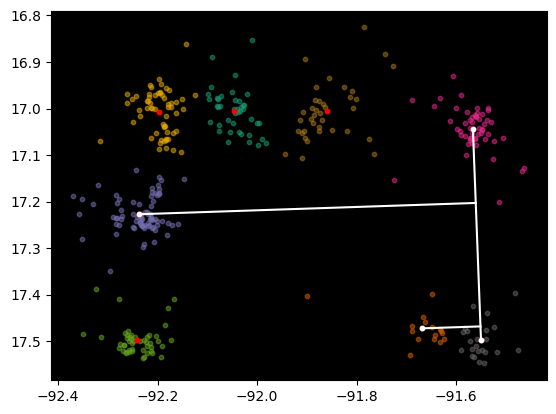

Group 1: Calculated Ratio: 0.1748103680469743


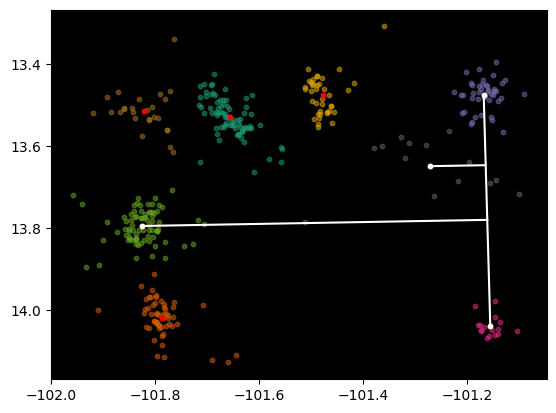

Group 2: Calculated Ratio: 0.16215892370297974


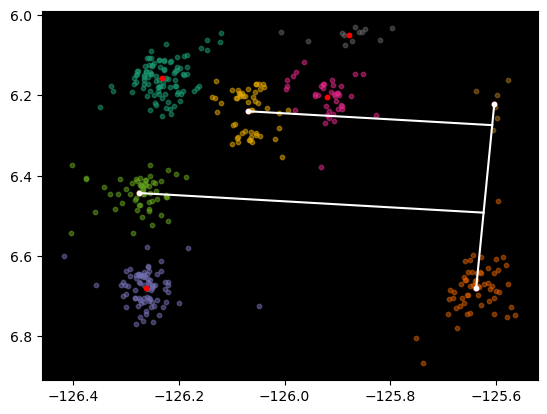

Group 3: Calculated Ratio: 0.7089893595409524


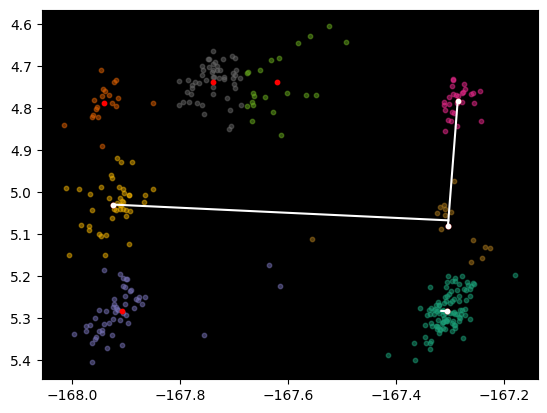

Group 4: Calculated Ratio: 0.01752789504428061


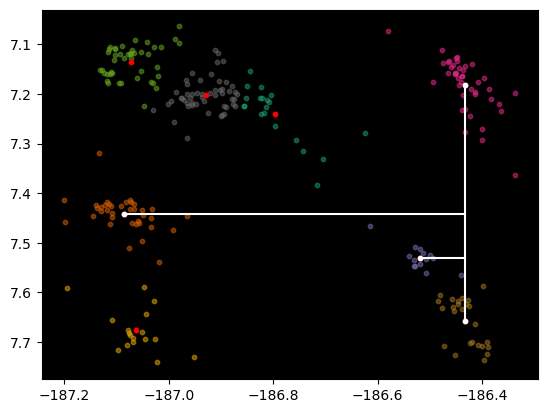

Group 5: Calculated Ratio: 0.13278225665590204


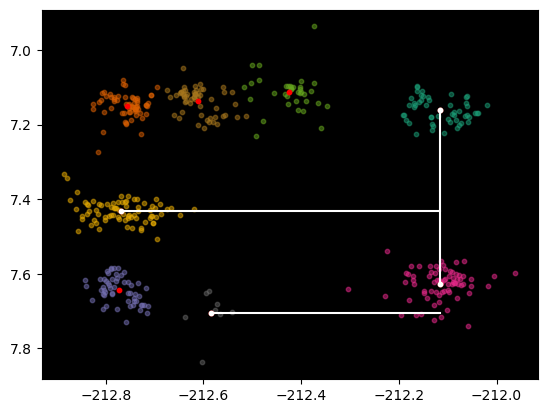

Group 6: Calculated Ratio: 0.7197819254066782


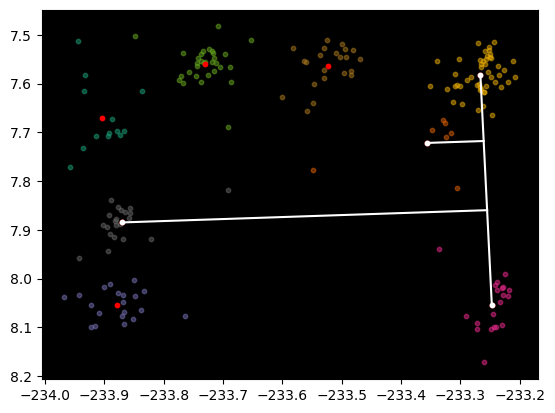

Group 7: Calculated Ratio: 0.15615277709229203


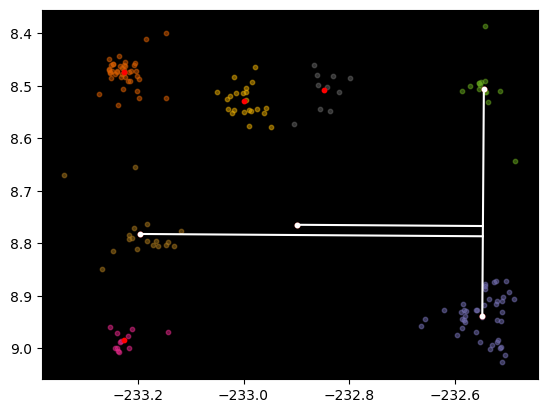

Group 8: Calculated Ratio: 0.5437744042433091


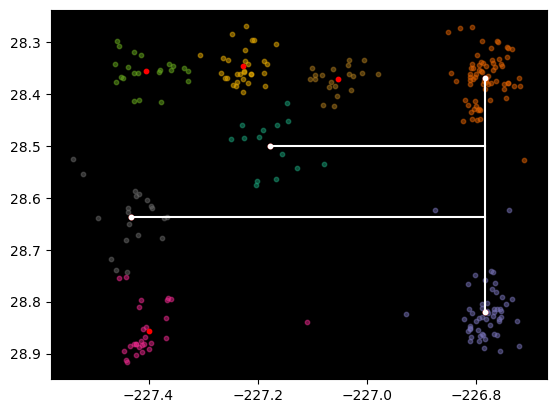

Group 9: Calculated Ratio: 0.6061204775677924


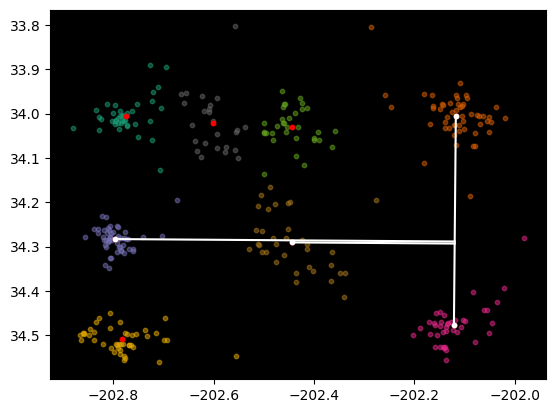

Group 10: Calculated Ratio: 0.47902724737982855


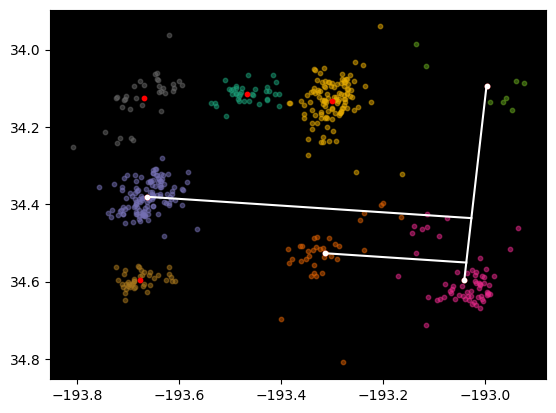

Group 11: Calculated Ratio: 0.43601855890962904


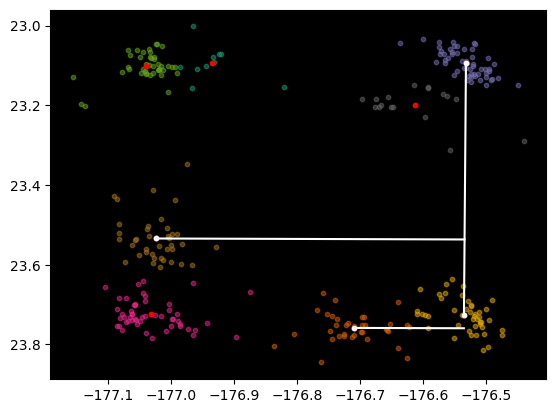

Group 12: Calculated Ratio: 0.3550524523218759


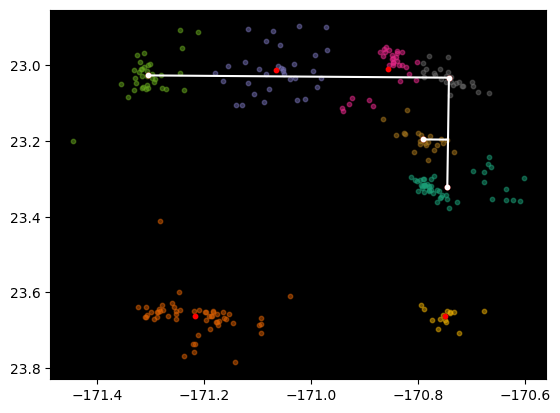

Group 13: Calculated Ratio: 0.08288483279059877


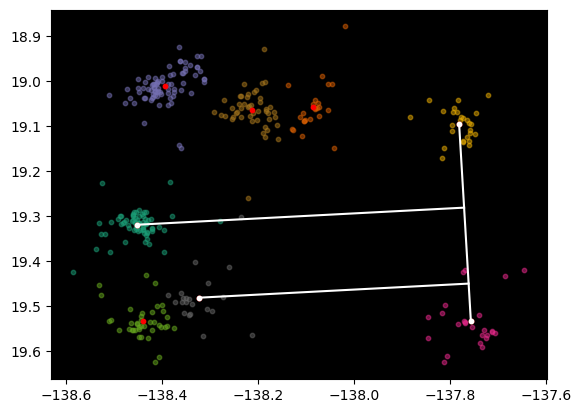

Group 14: Calculated Ratio: 0.8245043331531905


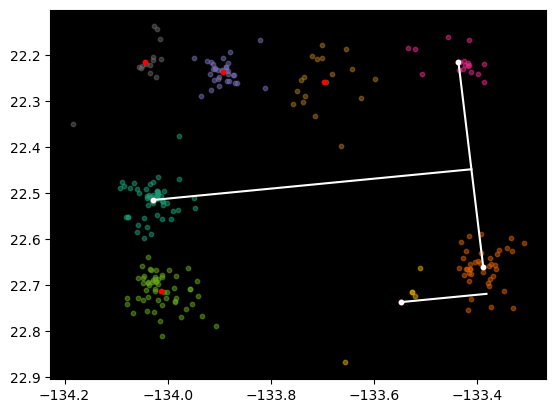

Group 15: Calculated Ratio: 0.2690188271102075


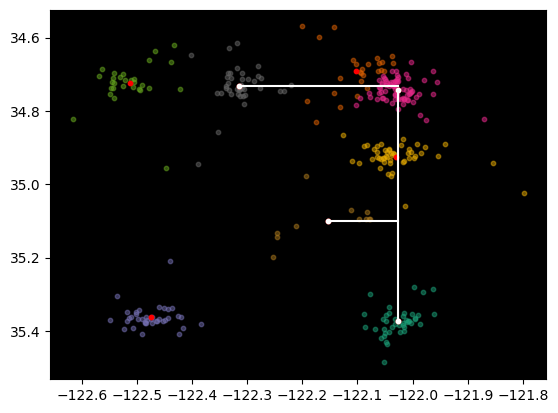

Group 16: Calculated Ratio: 0.43814846174942096


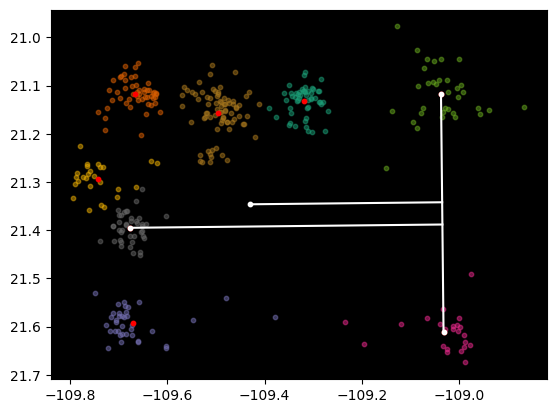

Group 17: Calculated Ratio: 0.6146160825163152


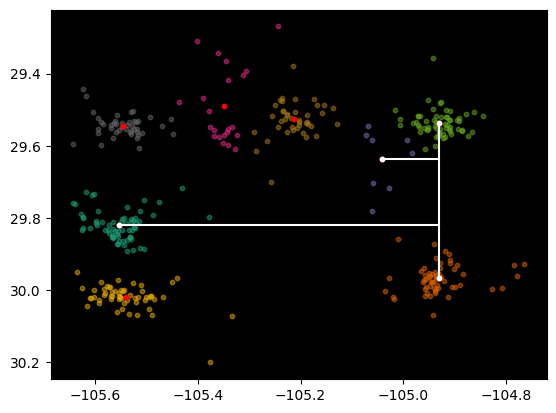

Group 18: Calculated Ratio: 0.17715798003513225


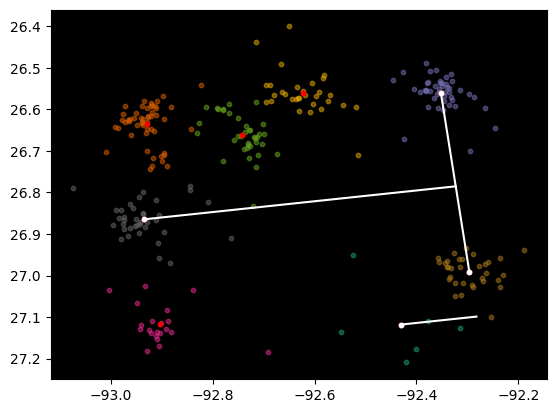

Group 19: Calculated Ratio: 0.24315746583373013


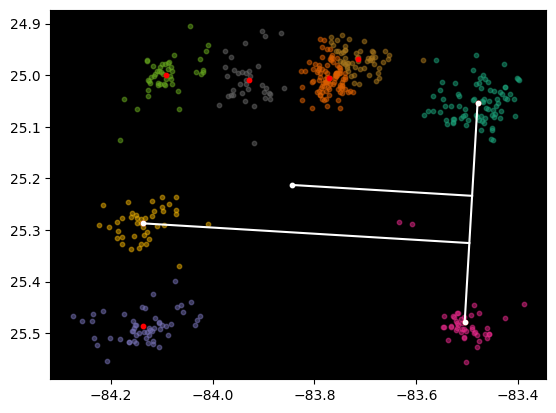

Group 20: Calculated Ratio: 0.5518710734560351


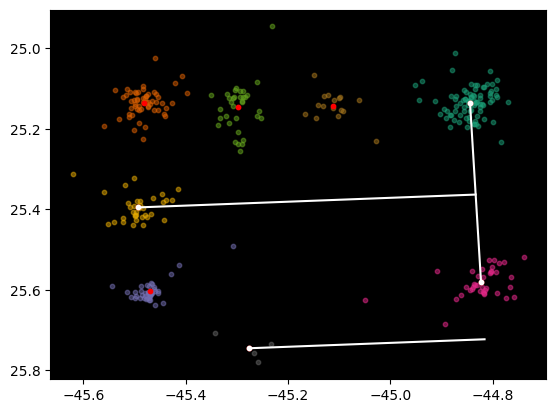

Group 21: Calculated Ratio: 0.6961166832266383


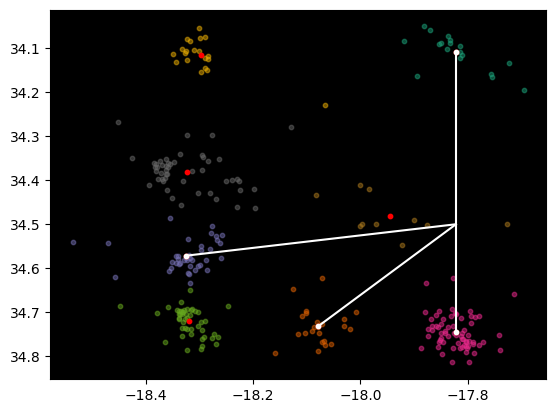

Group 22: Calculated Ratio: 0.5095647438995967


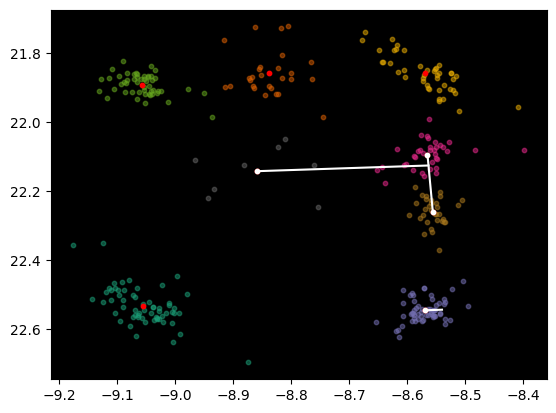

Group 23: Calculated Ratio: 0.10179120315314977


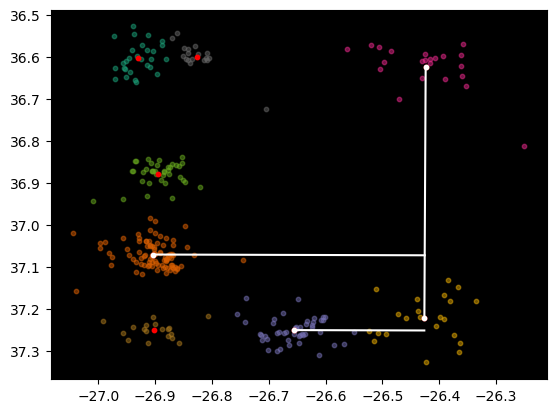

Group 24: Calculated Ratio: 0.4801697624525721


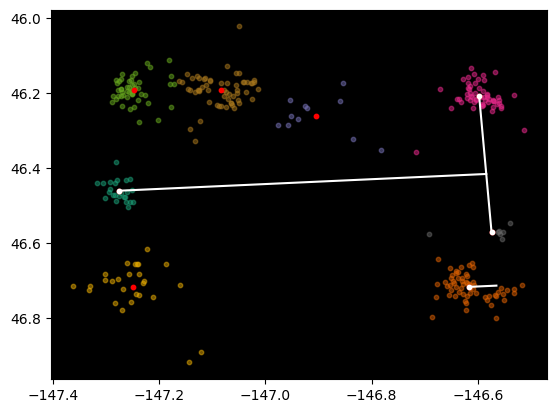

Group 25: Calculated Ratio: 0.07330799190475547


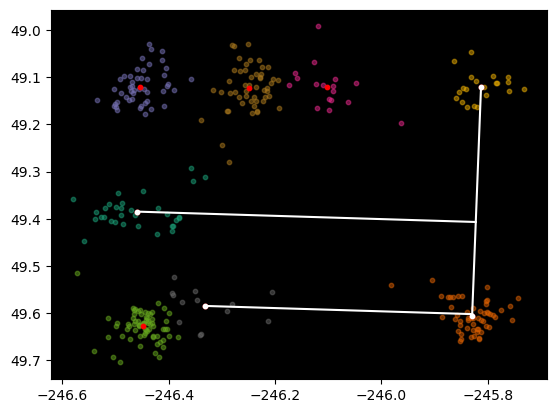

Group 26: Calculated Ratio: 0.7870312550953023


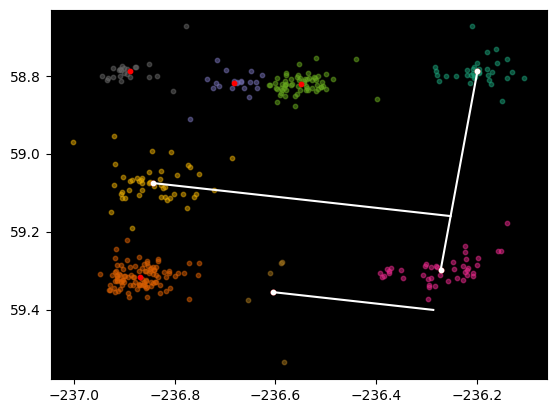

Group 27: Calculated Ratio: 0.5378889397558752


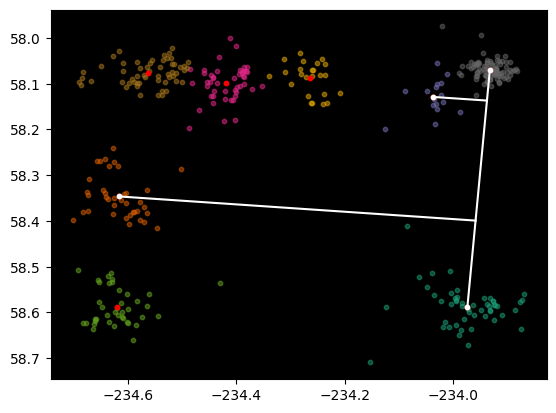

Group 28: Calculated Ratio: 0.15043865740912352


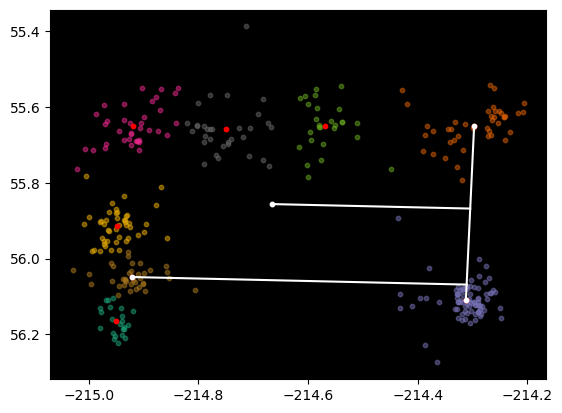

Group 29: Calculated Ratio: 0.5919386760976426


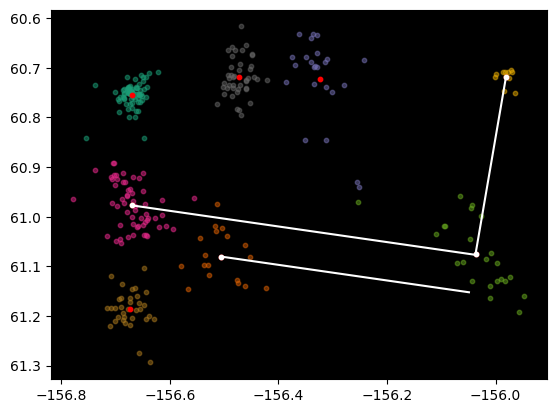

Group 30: Calculated Ratio: 0.7231338153211366


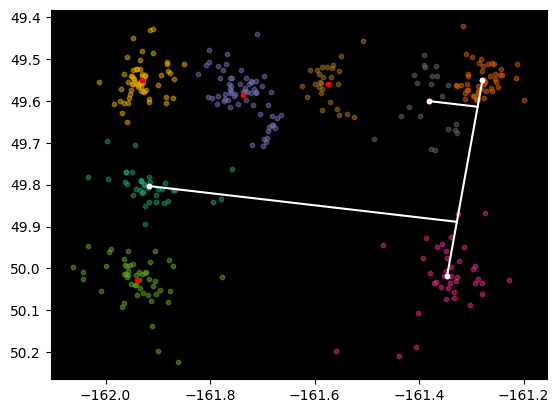

Group 31: Calculated Ratio: 0.1569730307250968


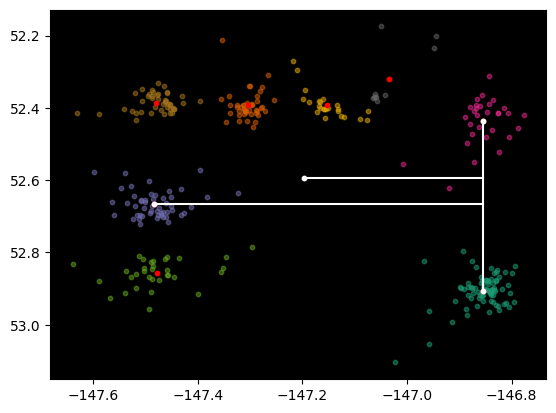

Group 32: Calculated Ratio: 0.5456704503192181


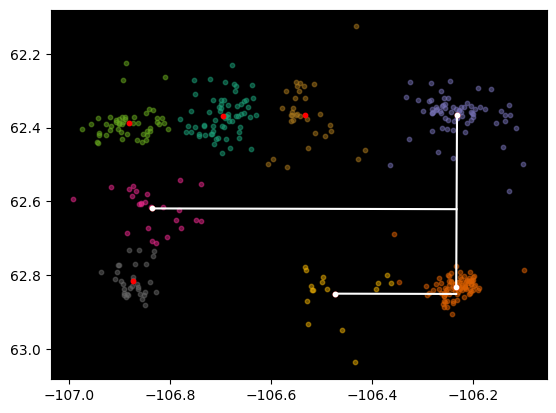

Group 33: Calculated Ratio: 0.3977837575312605


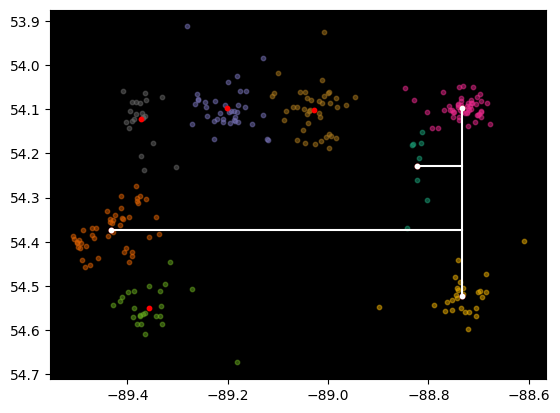

Group 34: Calculated Ratio: 0.1281954776541479


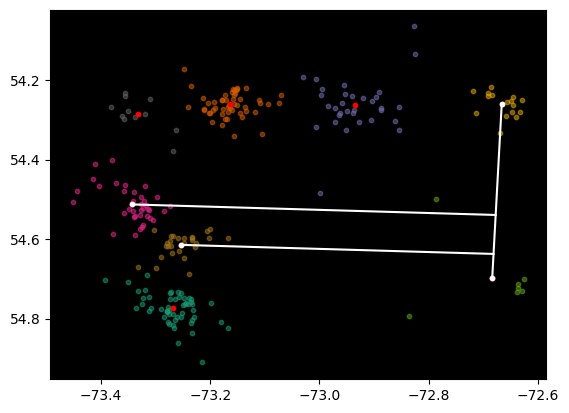

Group 35: Calculated Ratio: 0.8596478970381844


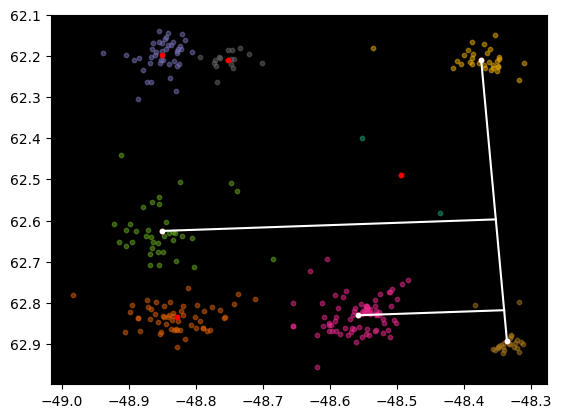

Group 36: Calculated Ratio: 0.43763348381540673


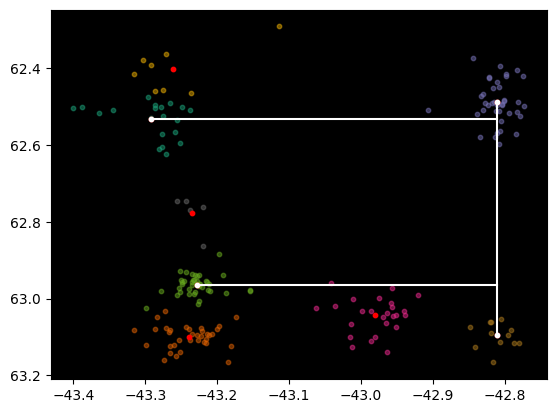

Group 37: Calculated Ratio: 0.8690489942830659


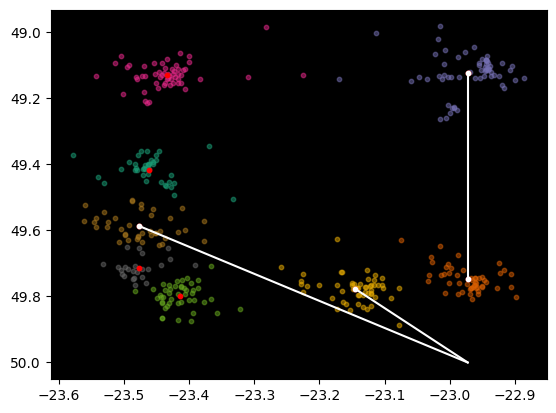

Group 38: Calculated Ratio: 0.3429975690801842


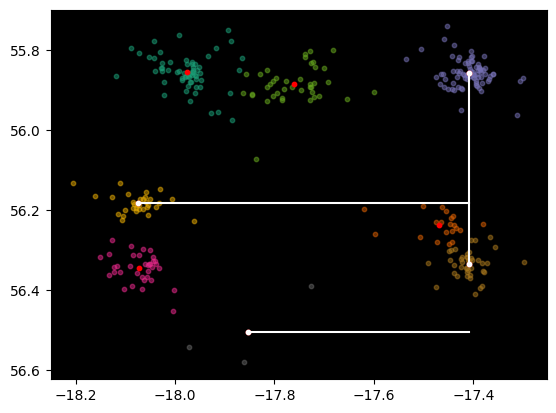

Group 39: Calculated Ratio: 0.6661942692316806


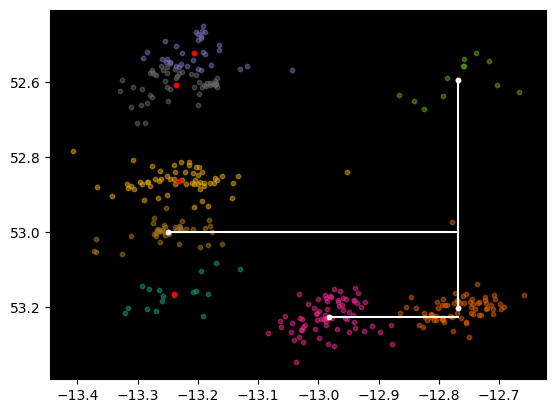

Group 40: Calculated Ratio: 0.44570461945918655


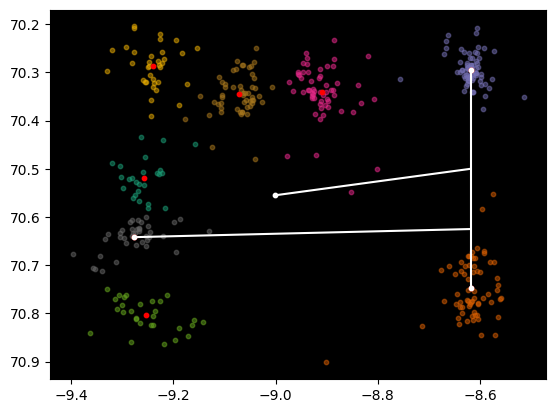

Group 41: Calculated Ratio: 0.5821823863958231


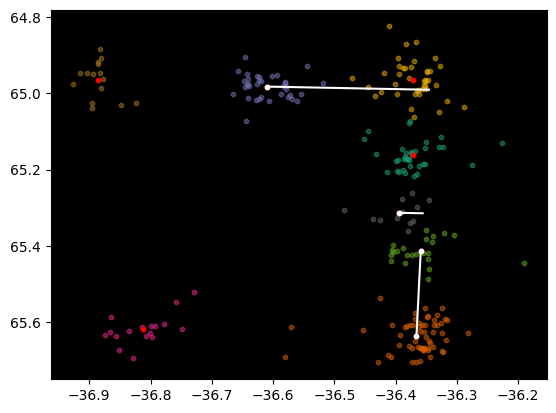

Group 42: Calculated Ratio: 0.14607848713296426


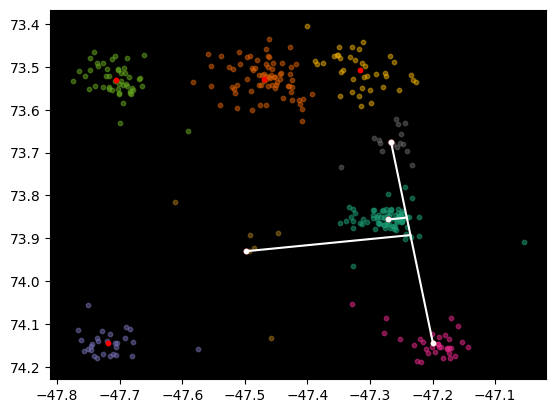

Group 43: Calculated Ratio: 0.11236260646394466


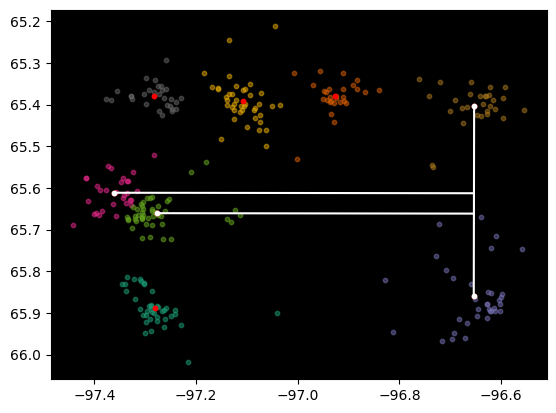

Group 44: Calculated Ratio: 0.8799274968315381


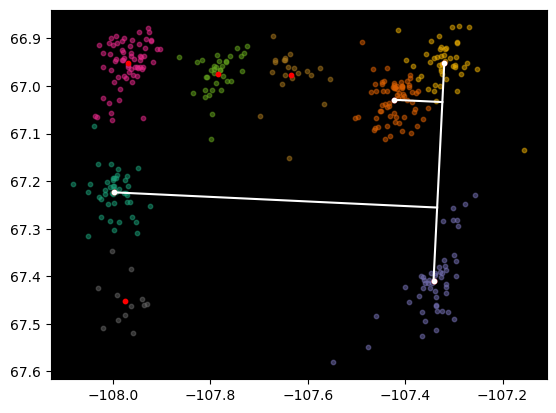

Group 45: Calculated Ratio: 0.14901203690341439


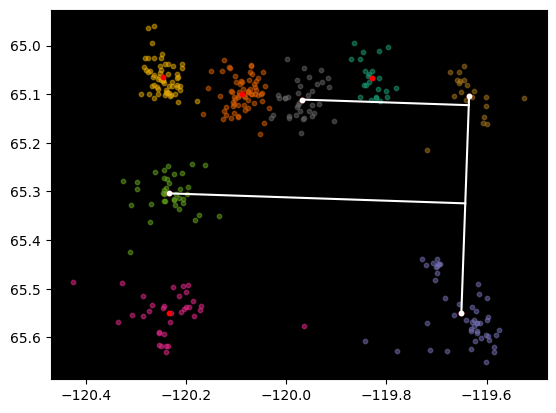

Group 46: Calculated Ratio: 0.5641099969958159


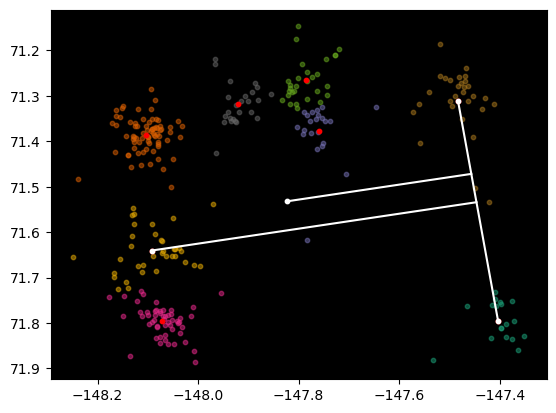

Group 47: Calculated Ratio: 0.5678619079022493


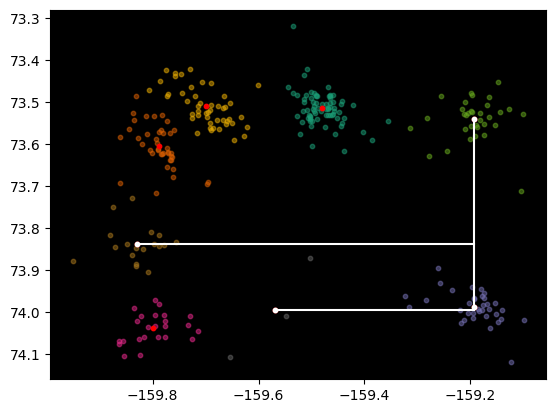

Group 48: Calculated Ratio: 0.5893489218962031


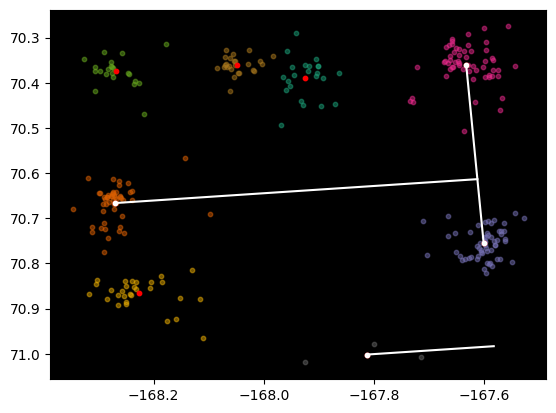

Group 49: Calculated Ratio: 0.3499444667817893


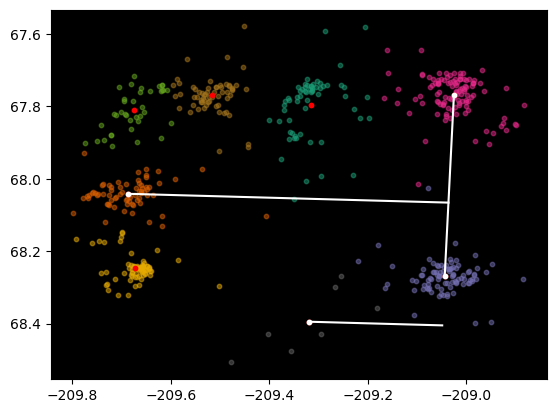

Group 50: Calculated Ratio: 0.41449206498261165


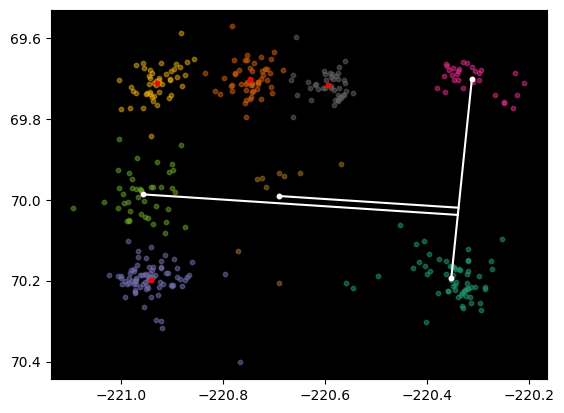

Group 51: Calculated Ratio: 0.5716117216189621


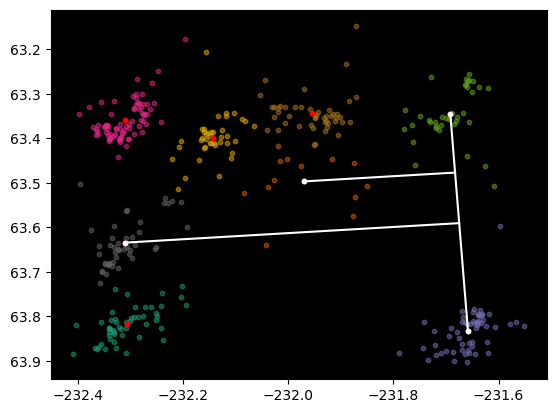

Group 52: Calculated Ratio: 0.45033210569969606


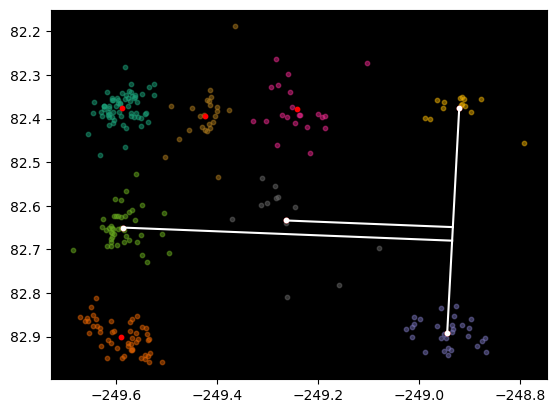

Group 53: Calculated Ratio: 0.505244470387853


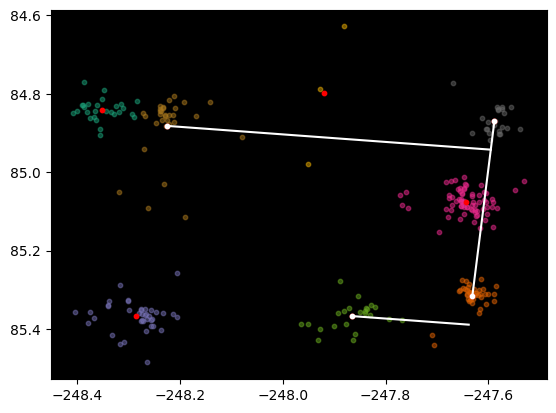

Group 54: Calculated Ratio: 0.36103718938201806


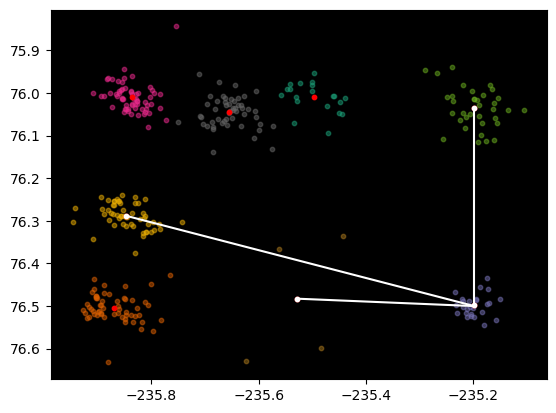

Group 55: Calculated Ratio: 0.5091619827972783


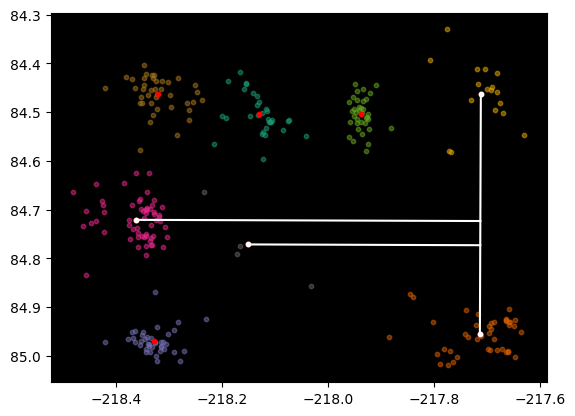

Group 56: Calculated Ratio: 0.6752562189397415


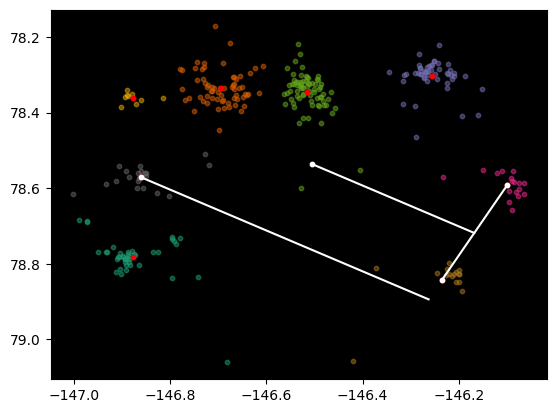

Group 57: Calculated Ratio: 0.5661842739520417


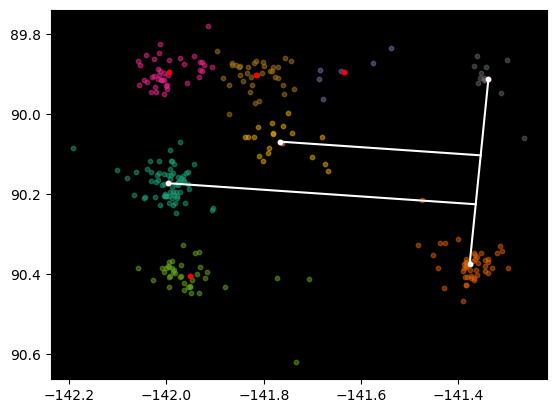

Group 58: Calculated Ratio: 0.6521107587509628


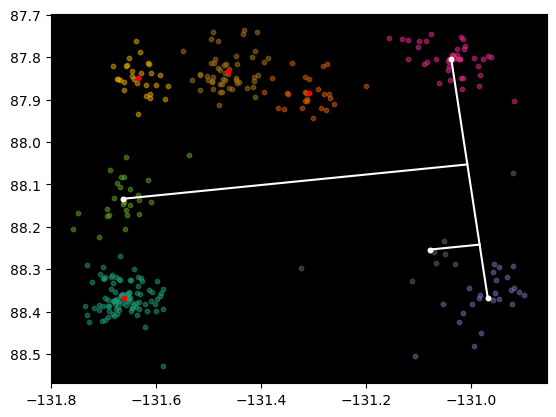

Group 59: Calculated Ratio: 0.14425425824143845


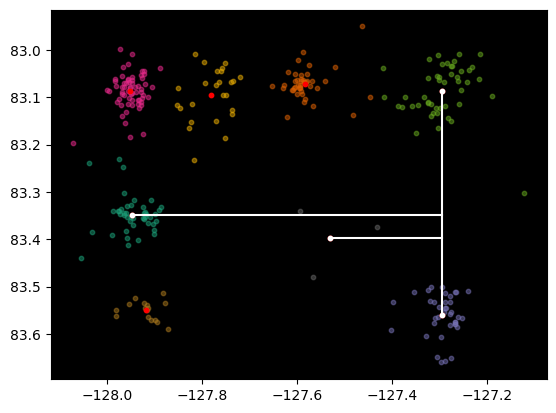

Group 60: Calculated Ratio: 0.36182553926842453


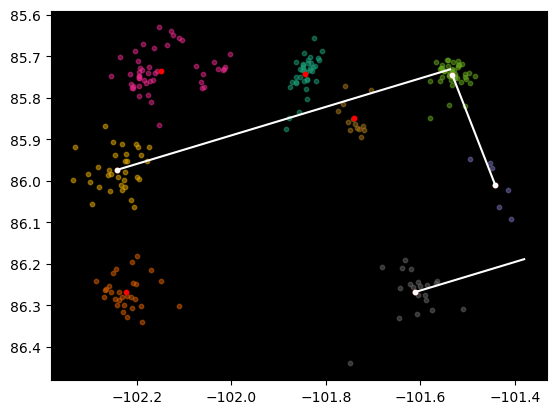

Group 61: Calculated Ratio: 0.32930886911004664


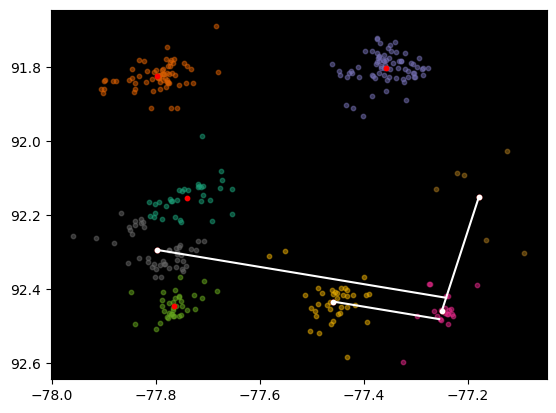

Group 62: Calculated Ratio: 0.3675351745715708


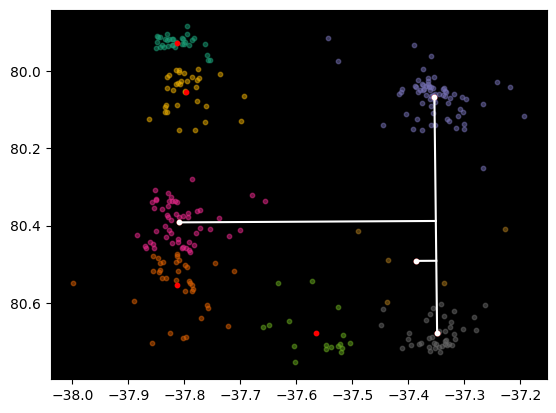

Group 63: Calculated Ratio: 0.0786490969674933


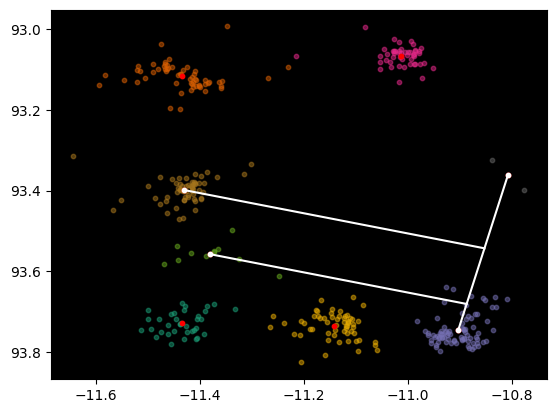

Group 64: Calculated Ratio: 0.8519419873524079


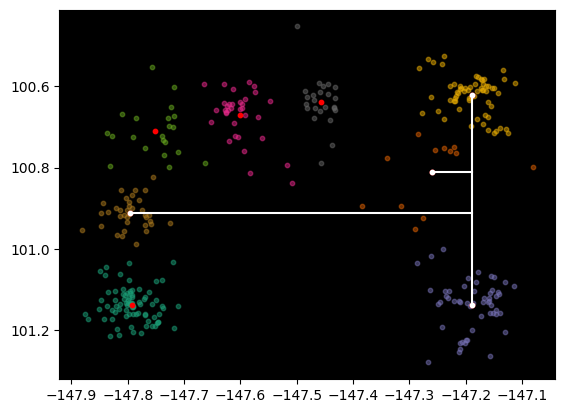

Group 65: Calculated Ratio: 0.1169888309002434


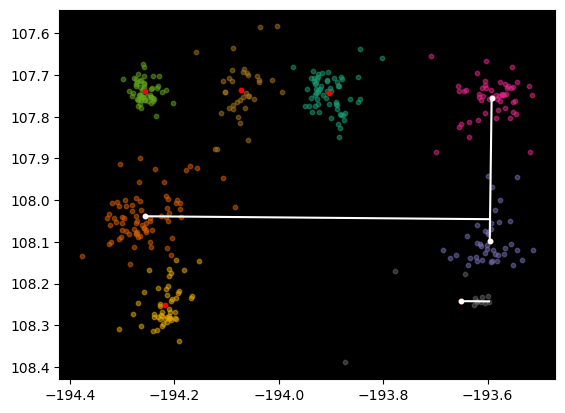

Group 66: Calculated Ratio: 0.0808390917865022


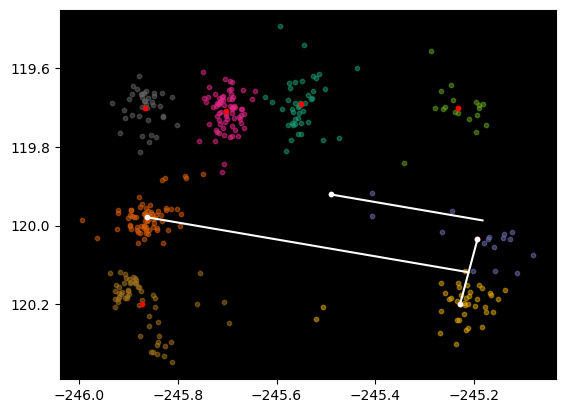

Group 67: Calculated Ratio: 0.47314796550224103


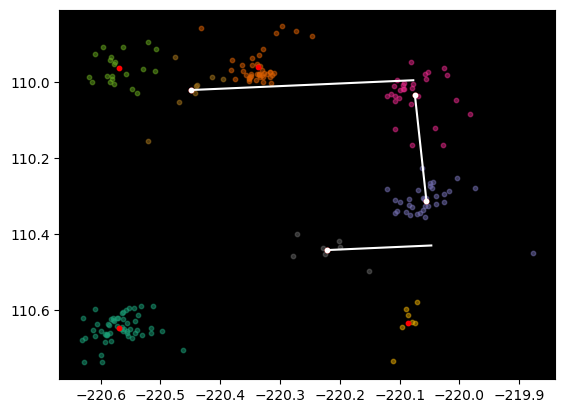

Group 68: Calculated Ratio: 0.4697357783822348


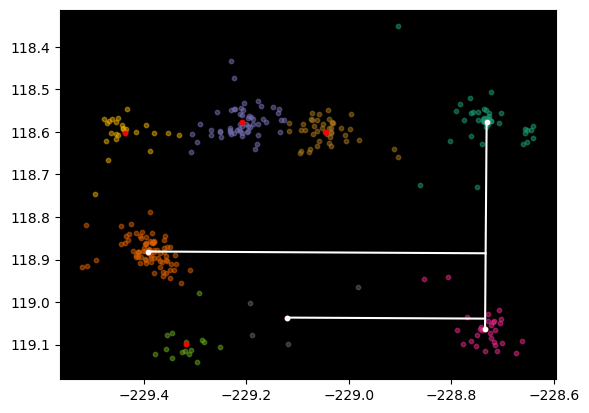

Group 69: Calculated Ratio: 0.5876062070281336


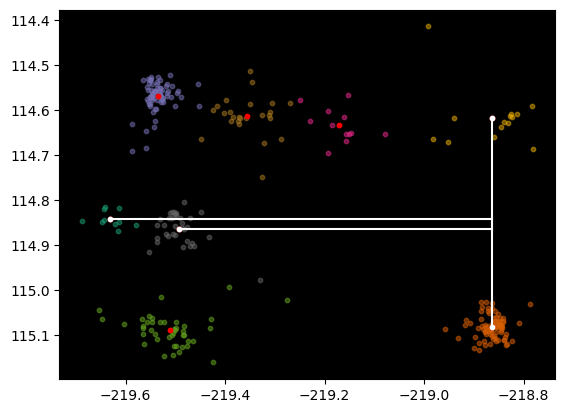

Group 70: Calculated Ratio: 0.819649038103848


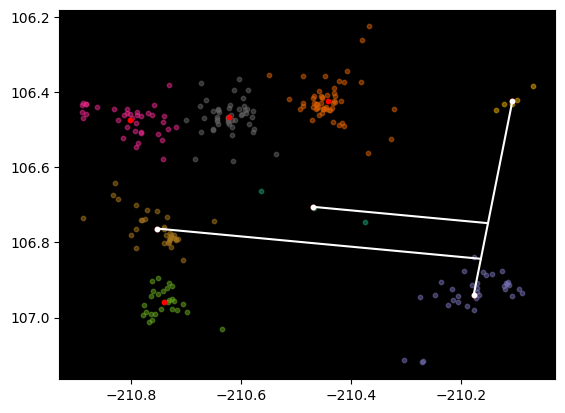

Group 71: Calculated Ratio: 0.5388096263061637


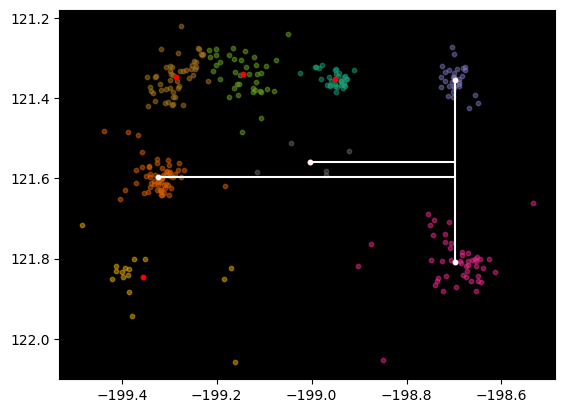

Group 72: Calculated Ratio: 0.49061458125823665


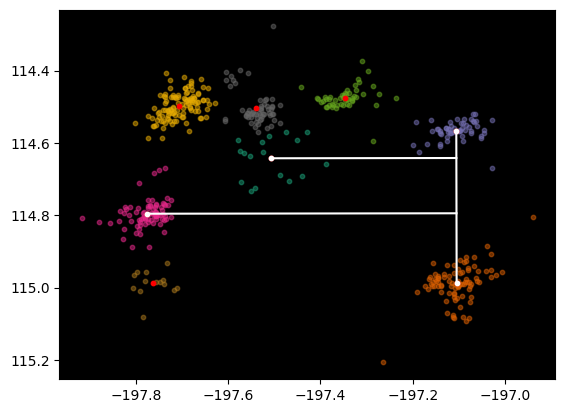

Group 73: Calculated Ratio: 0.6000330969285635


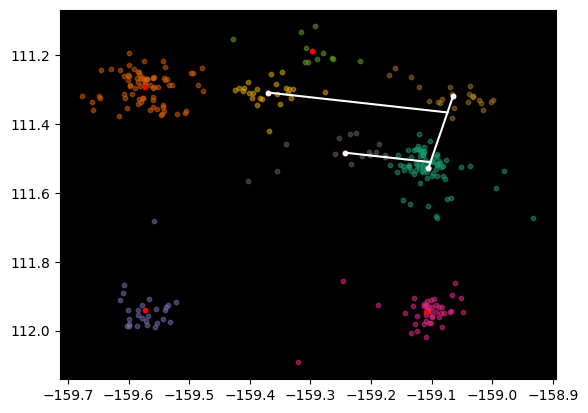

Group 74: Calculated Ratio: 0.4777133586342116


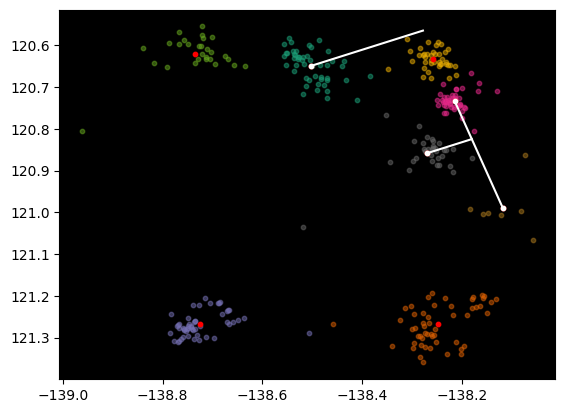

Group 75: Calculated Ratio: 0.40272229987294494


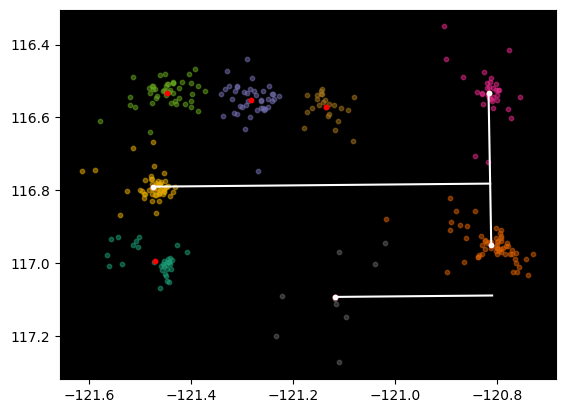

Group 76: Calculated Ratio: 0.4667612977932898


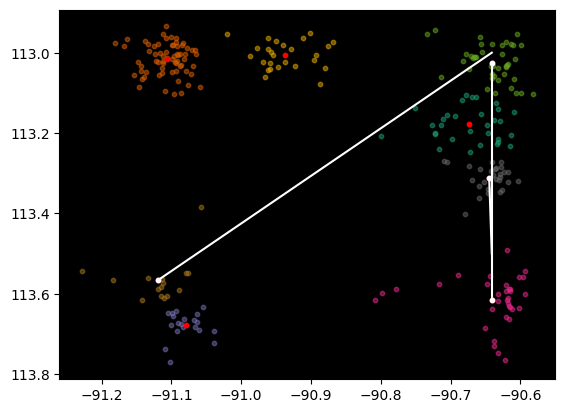

Group 77: Calculated Ratio: 0.007794107760929544


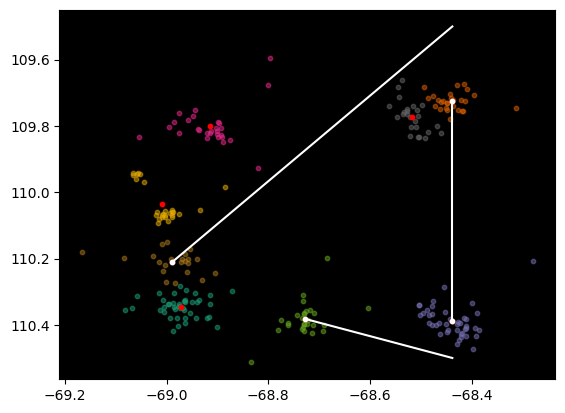

Group 78: Calculated Ratio: 0.5270150295518167


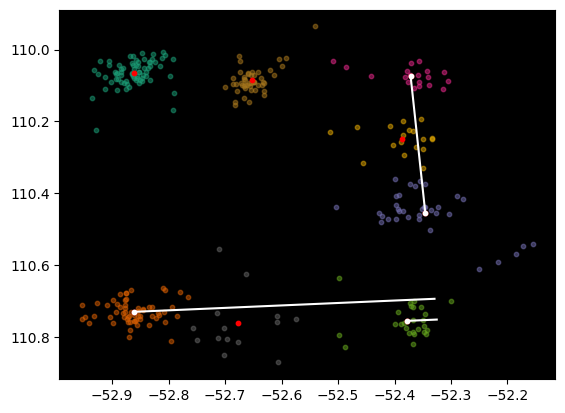

Group 79: Calculated Ratio: 0.0993040541161064


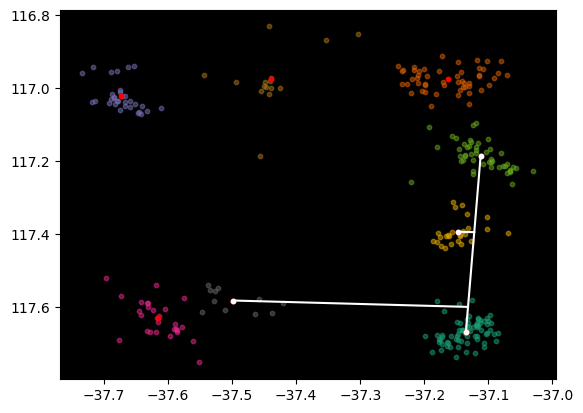

Group 80: Calculated Ratio: 0.06965295326339546


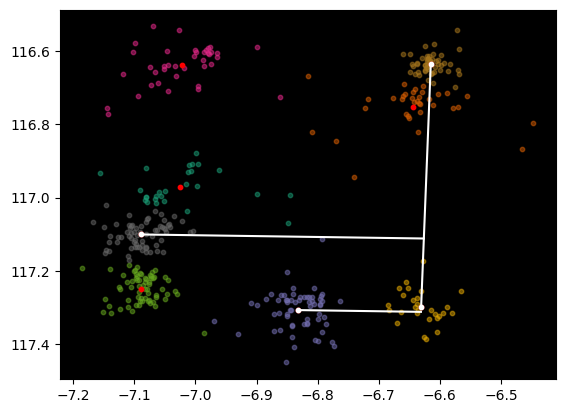

Group 81: Calculated Ratio: 0.43482423649345286


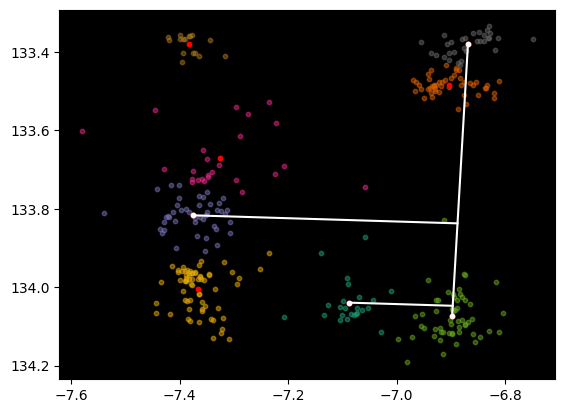

Group 82: Calculated Ratio: 0.39066317161700015


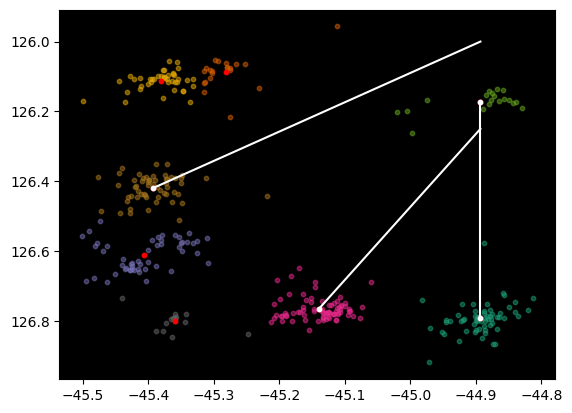

Group 83: Calculated Ratio: 0.4933896305489802


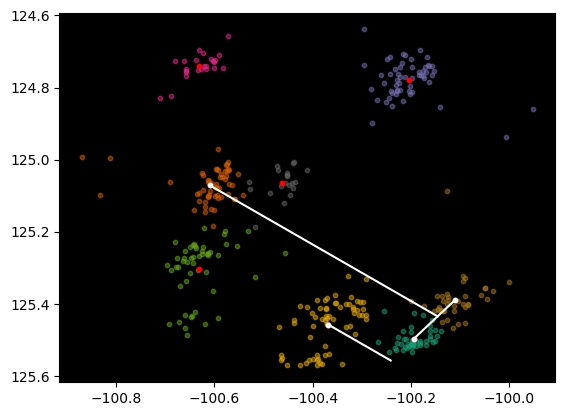

Group 84: Calculated Ratio: 0.27346771743682785


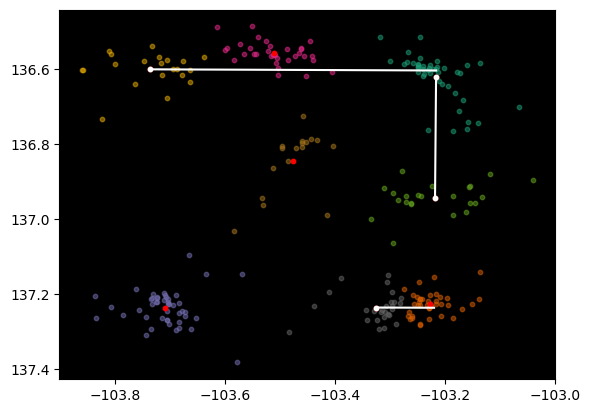

Group 85: Calculated Ratio: 0.20333535198763217


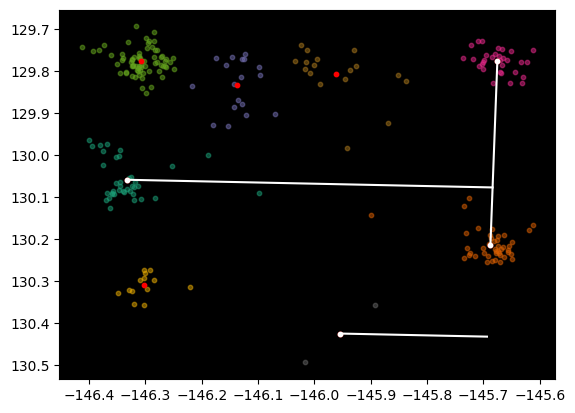

Group 86: Calculated Ratio: 0.40160544461487285


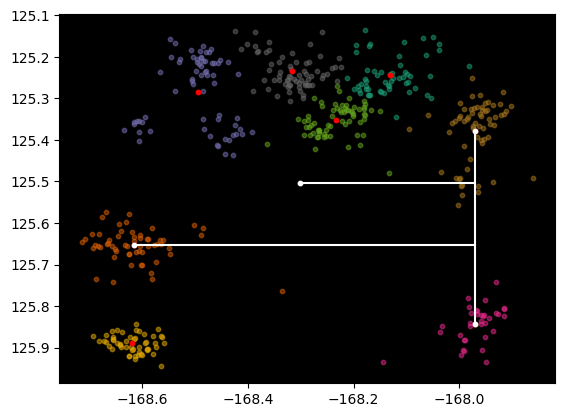

Group 87: Calculated Ratio: 0.5152335597520771


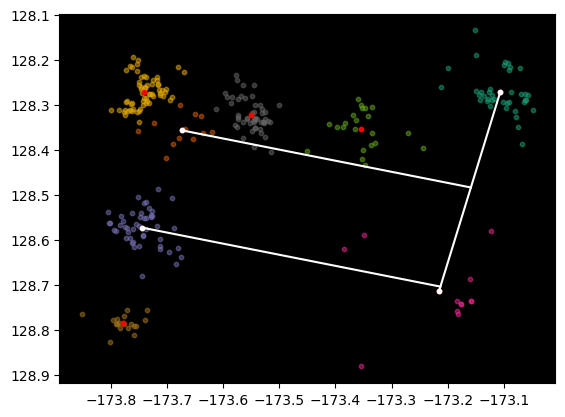

Group 88: Calculated Ratio: 0.9690149457091484


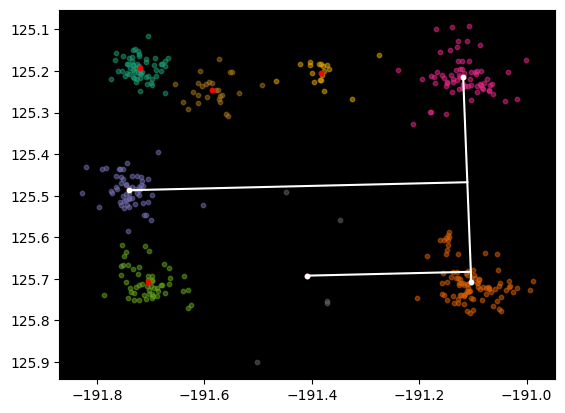

Group 89: Calculated Ratio: 0.48375687246757804


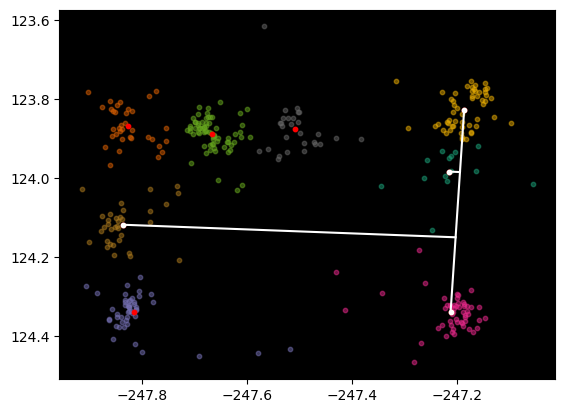

Group 90: Calculated Ratio: 0.032643071294227693


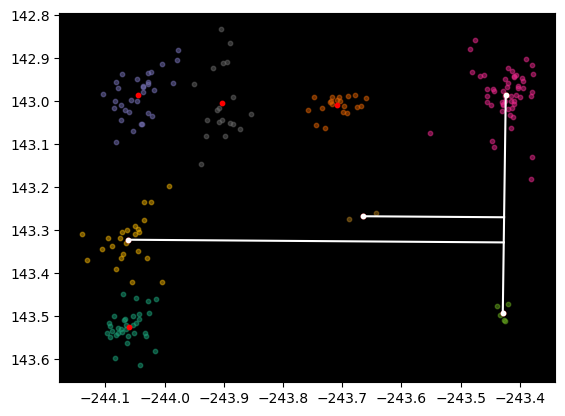

Group 91: Calculated Ratio: 0.37631640433580543


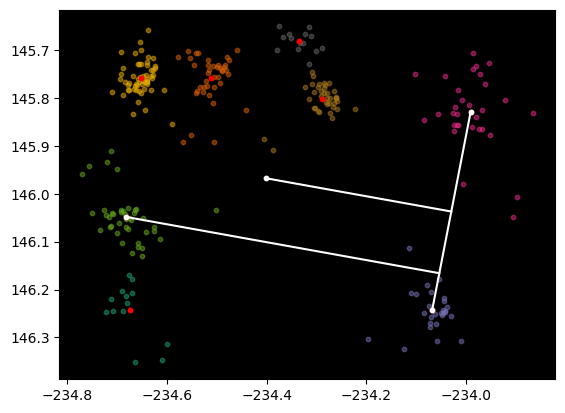

Group 92: Calculated Ratio: 0.5897028853938037


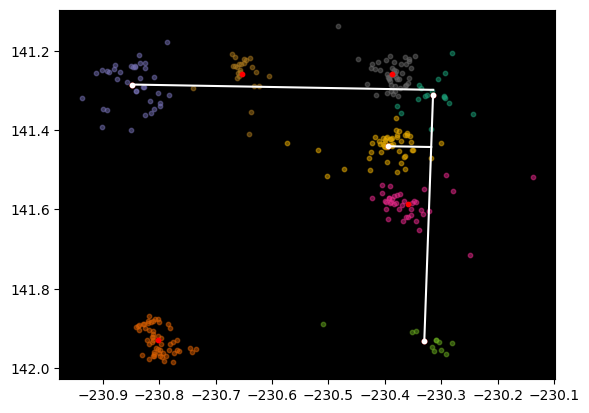

Group 93: Calculated Ratio: 0.1437505600099927


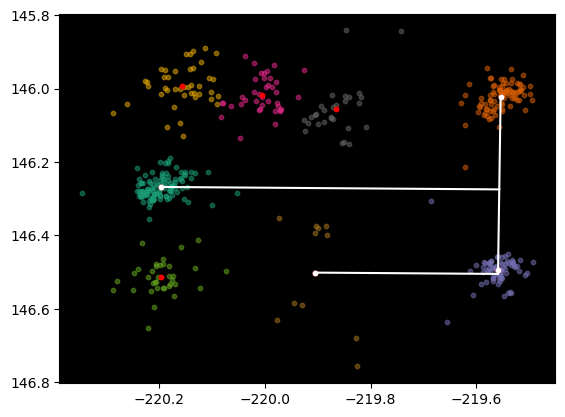

Group 94: Calculated Ratio: 0.540979328555153


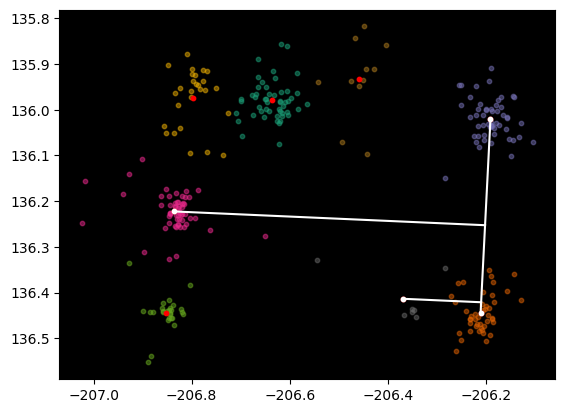

Group 95: Calculated Ratio: 0.2514114295164871


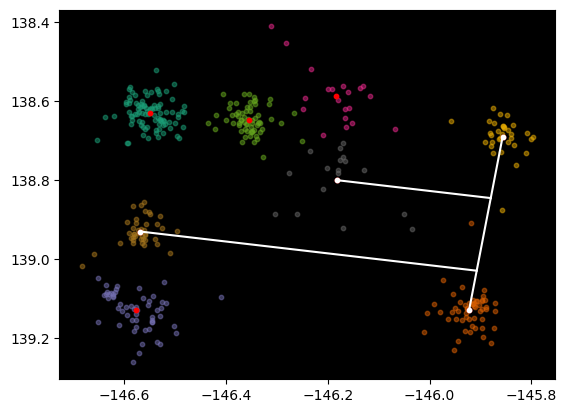

Group 96: Calculated Ratio: 0.4564550275286438


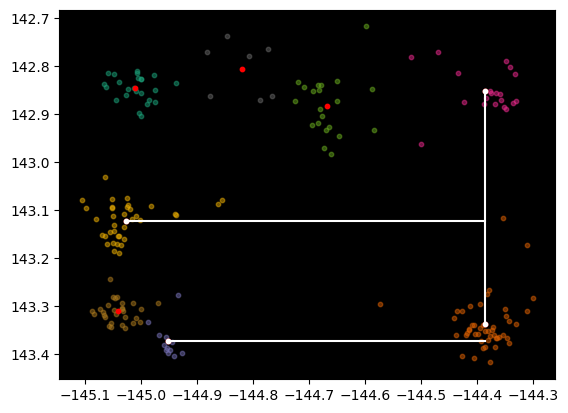

Group 97: Calculated Ratio: 0.8829488319179422


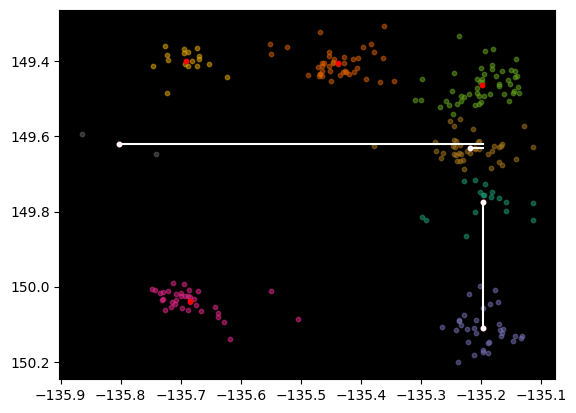

Group 98: Calculated Ratio: 0.03626944396882373


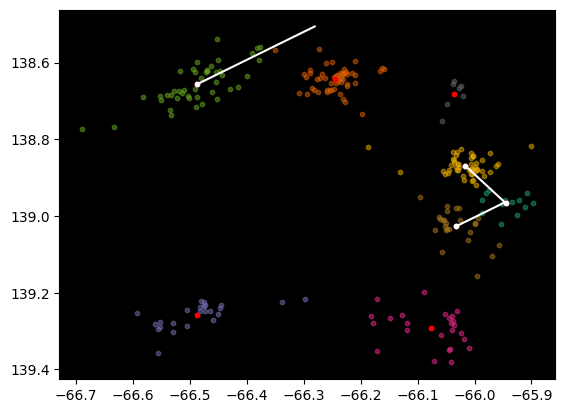

Group 99: Calculated Ratio: 0.4172093607490394


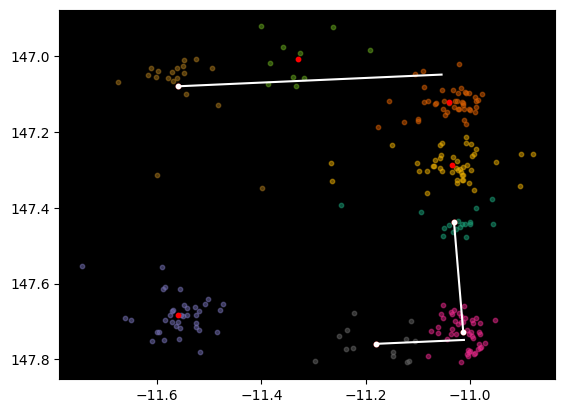

Group 100: Calculated Ratio: 0.3337466387275289


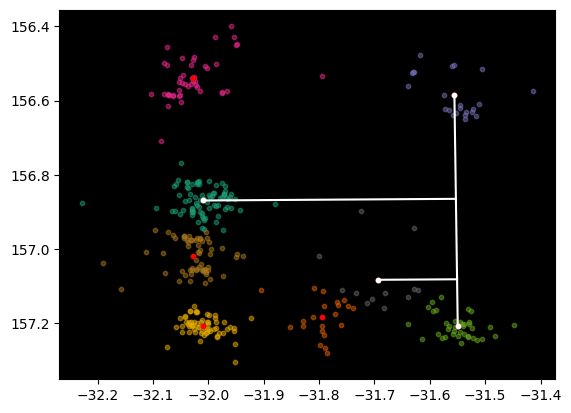

Group 101: Calculated Ratio: 0.3109459338629246


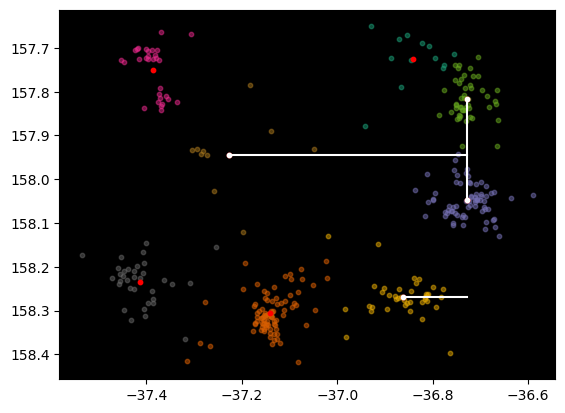

Group 102: Calculated Ratio: 0.27009904407991076


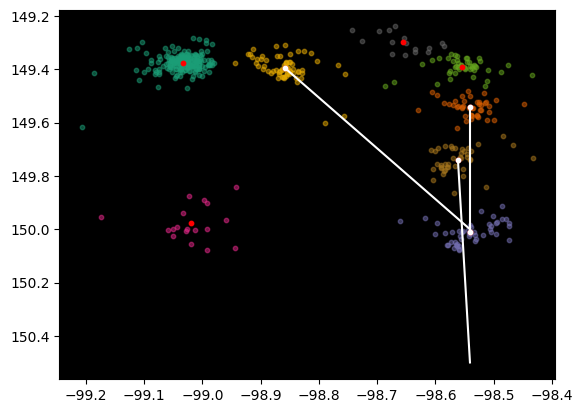

Group 103: Calculated Ratio: 0.06491128060900345


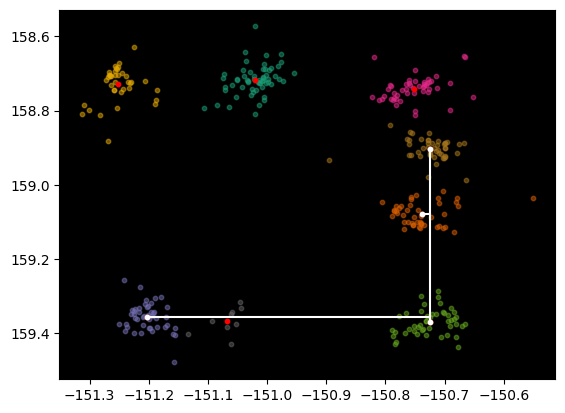

Group 104: Calculated Ratio: 0.030175140593840098


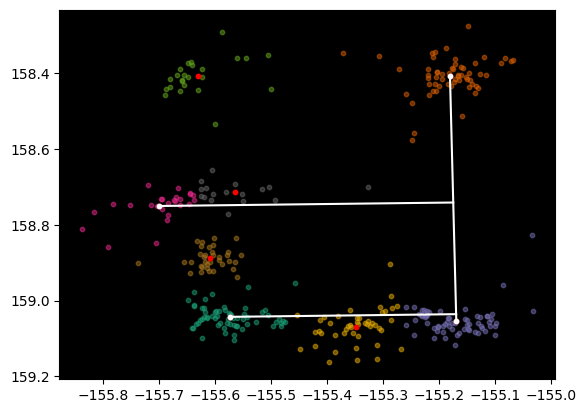

Group 105: Calculated Ratio: 0.7707044921672739


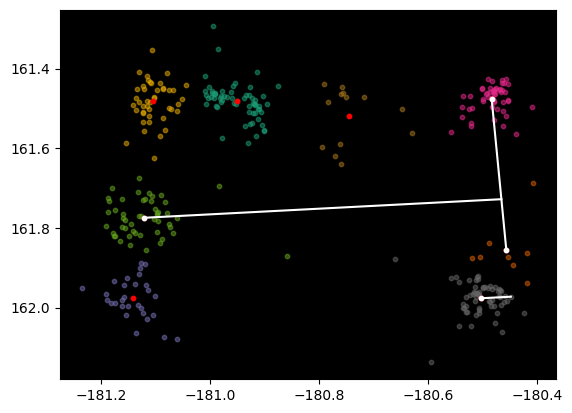

Group 106: Calculated Ratio: 0.08489994213264482


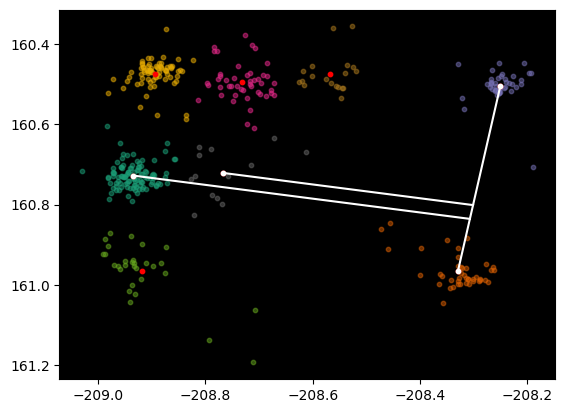

Group 107: Calculated Ratio: 0.7429589359786416


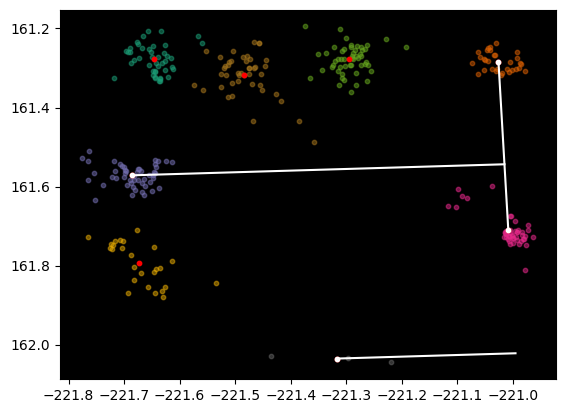

Group 108: Calculated Ratio: 0.48076721490460755


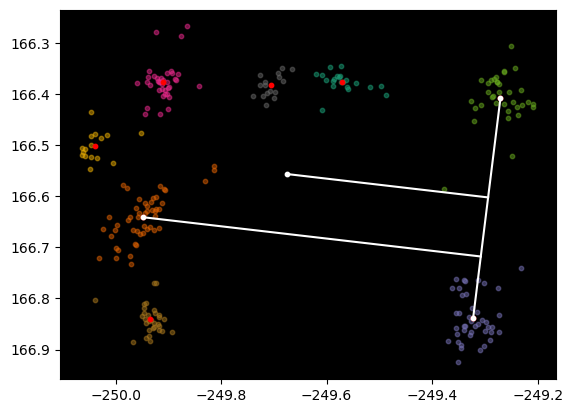

Group 109: Calculated Ratio: 0.5942004701289557


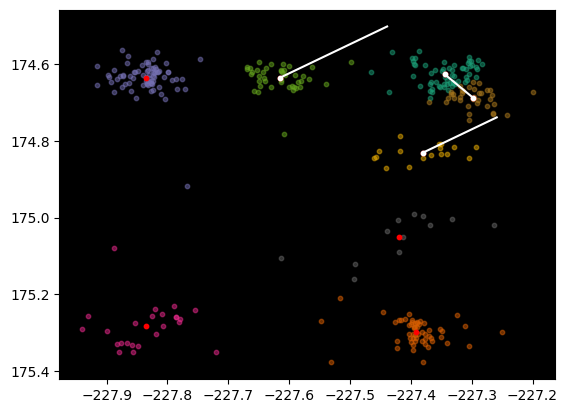

Group 110: Calculated Ratio: 0.6892721114950318


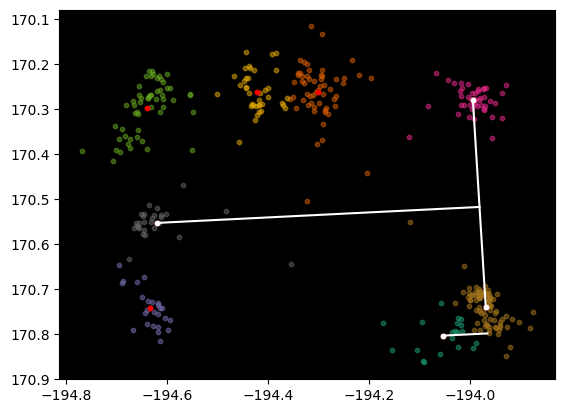

Group 111: Calculated Ratio: 0.13705571091037158


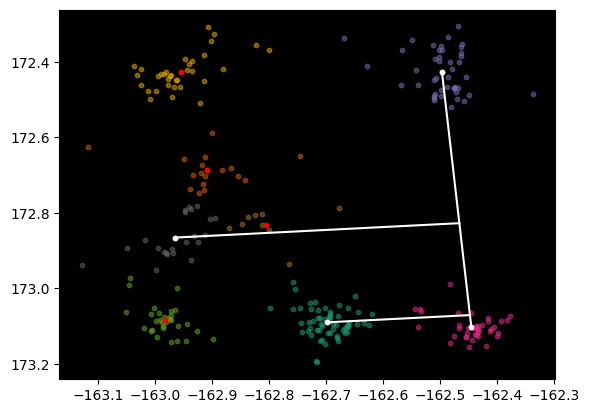

Group 112: Calculated Ratio: 0.5019107136651905


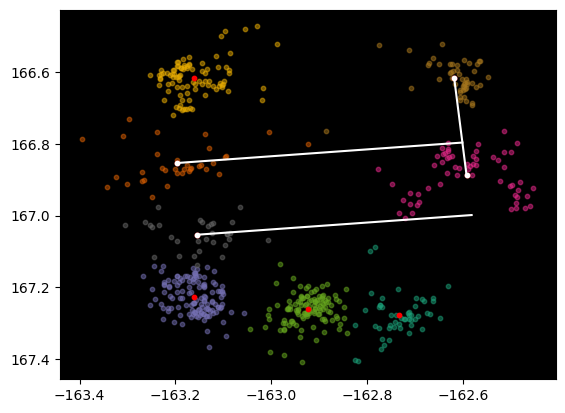

Group 113: Calculated Ratio: 0.9613929042547138


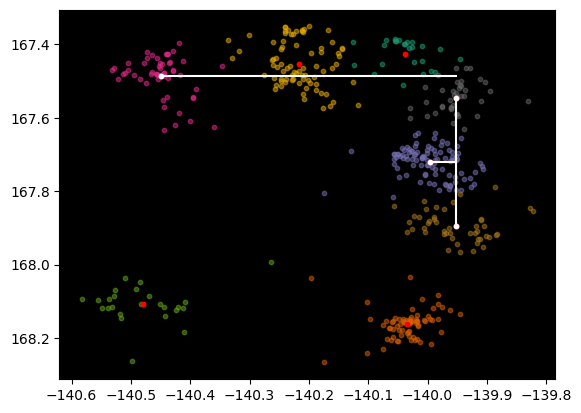

Group 114: Calculated Ratio: 0.08846119081764647


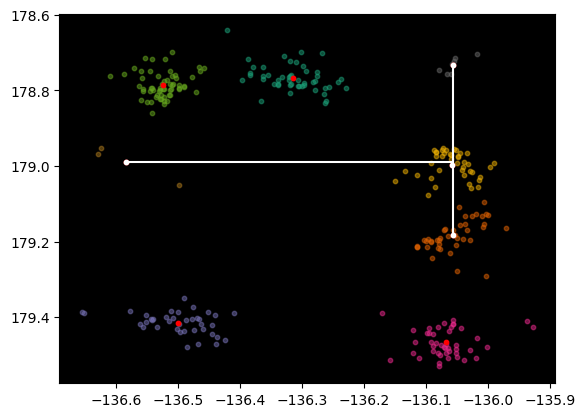

Group 115: Calculated Ratio: 0.004680309856141879


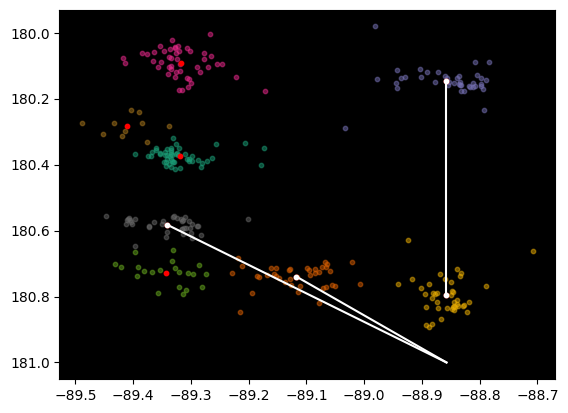

Group 116: Calculated Ratio: 0.5382251667115274


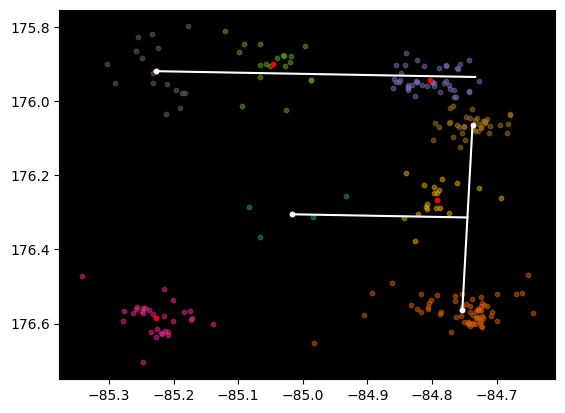

Group 117: Calculated Ratio: 0.549391190485003


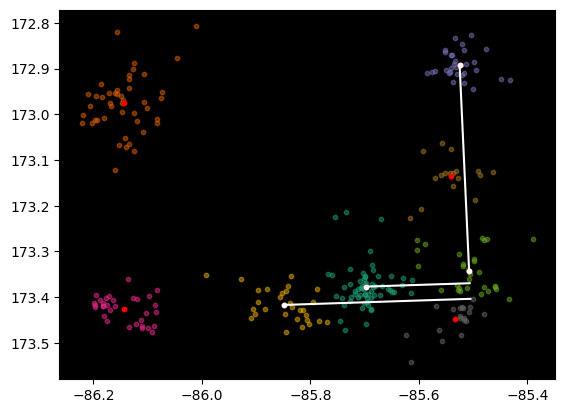

Group 118: Calculated Ratio: 0.5551930118160439


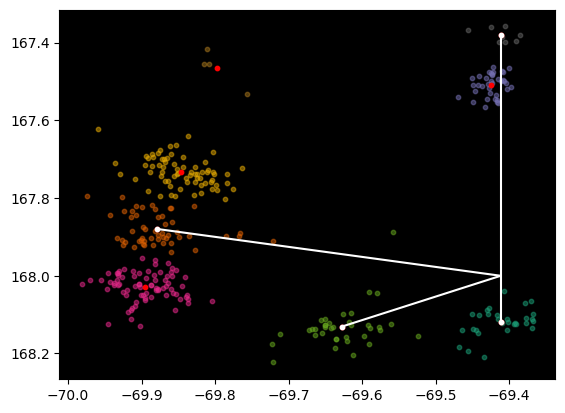

Group 119: Calculated Ratio: 0.46329979517578845


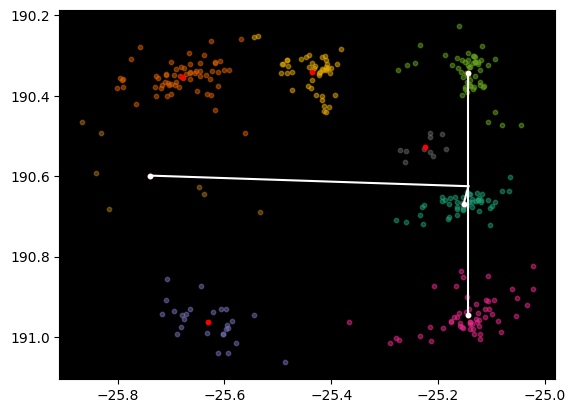

Group 120: Calculated Ratio: 0.014717221232757748


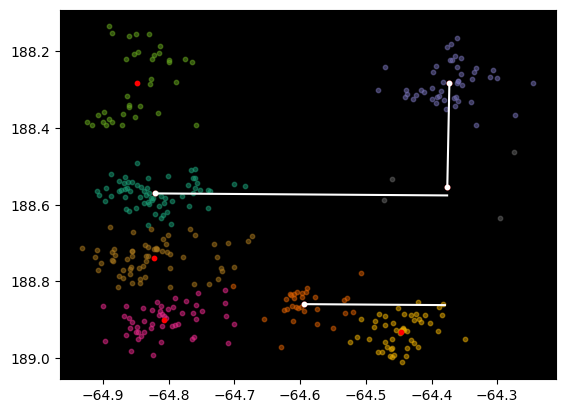

Group 121: Calculated Ratio: 0.4807530308087096


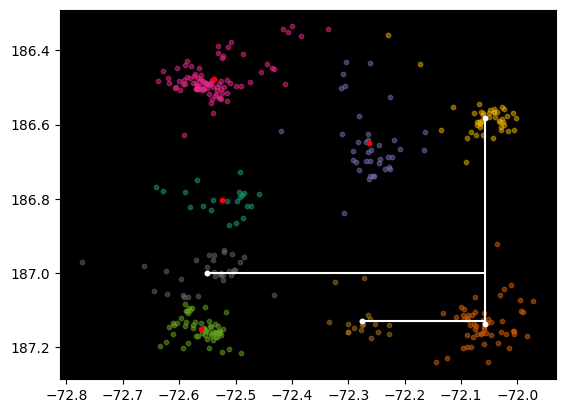

Group 122: Calculated Ratio: 0.4424880358917096


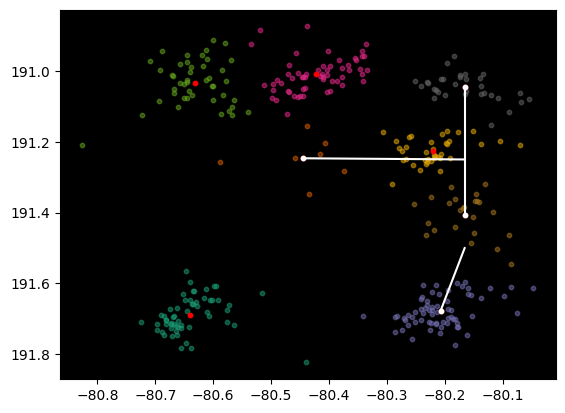

Group 123: Calculated Ratio: 0.14949286421126062


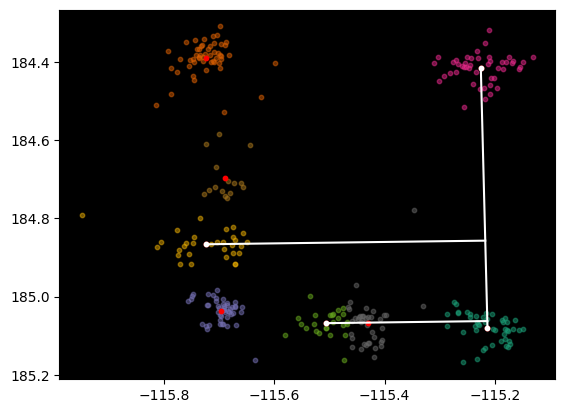

Group 124: Calculated Ratio: 0.576148918213386


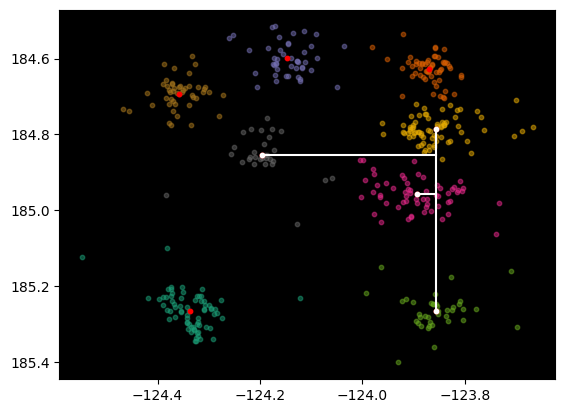

Group 125: Calculated Ratio: 0.108454343154695


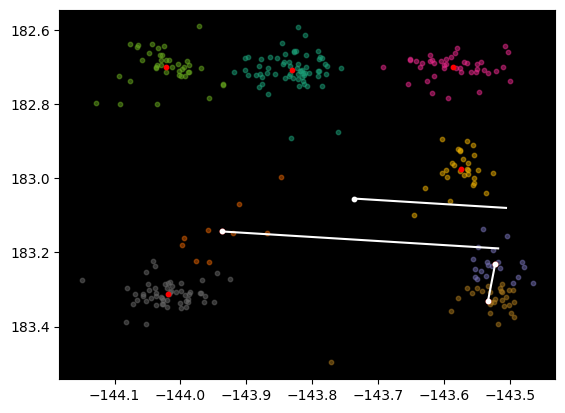

Group 126: Calculated Ratio: 0.5503030347038862


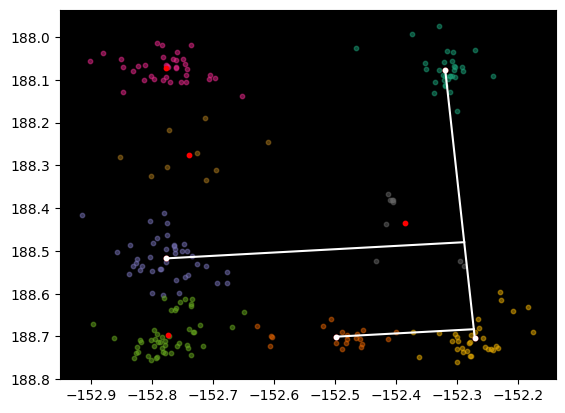

Group 127: Calculated Ratio: 0.4601144389267362


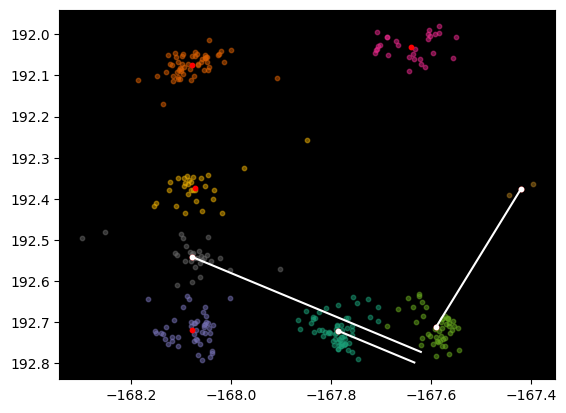

Group 128: Calculated Ratio: 0.33351305621536087


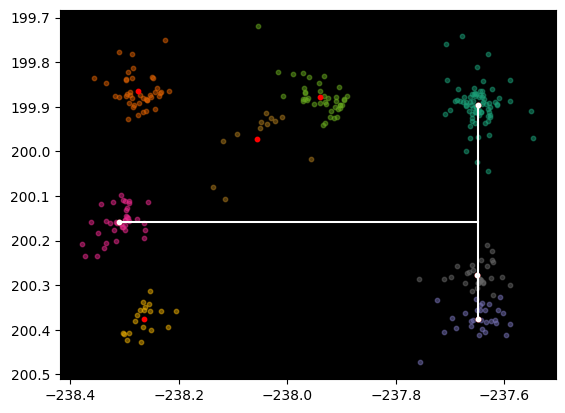

Group 129: Calculated Ratio: 0.003157835591160376


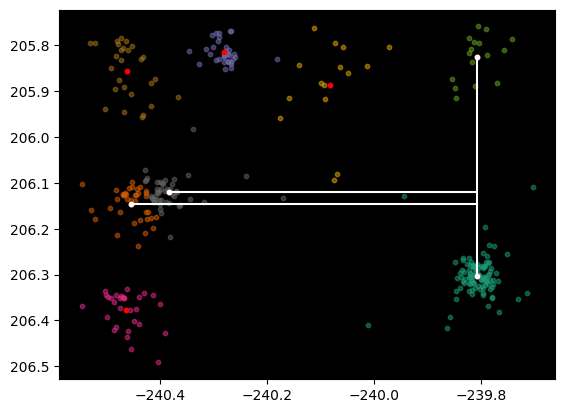

Group 130: Calculated Ratio: 0.8894818181517743


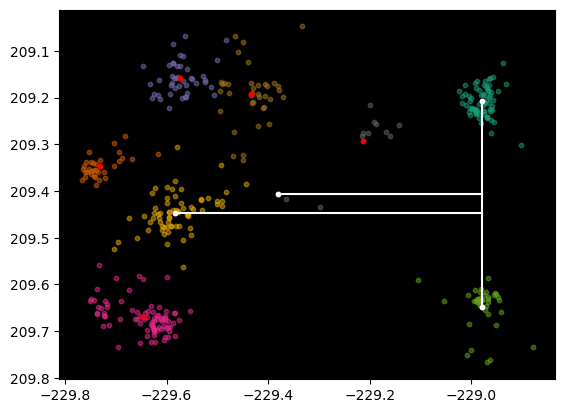

Group 131: Calculated Ratio: 0.6662516174075938


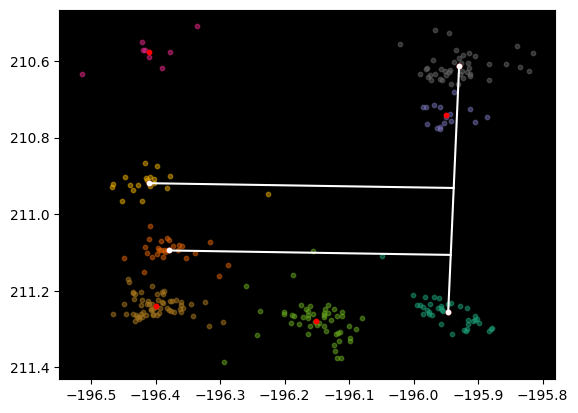

Group 132: Calculated Ratio: 0.9241841672336694


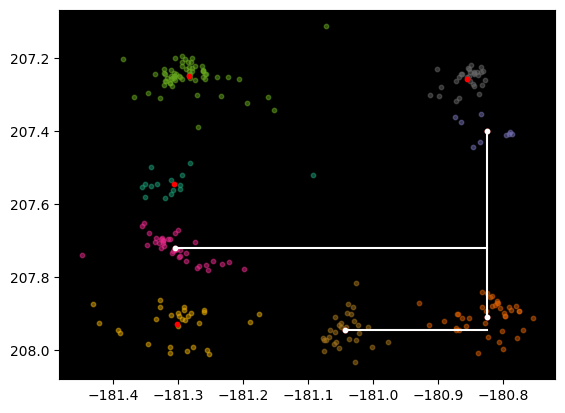

Group 133: Calculated Ratio: 0.45466392125054744


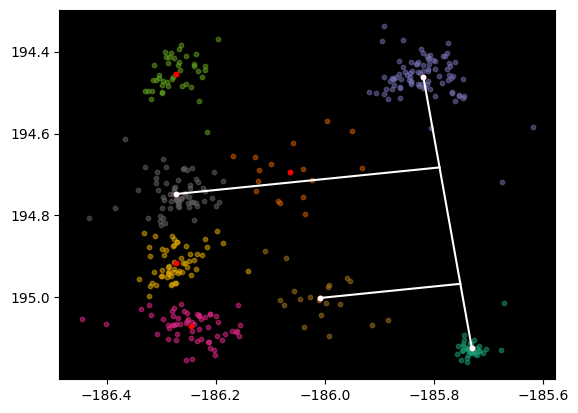

Group 134: Calculated Ratio: 0.5351273127377171


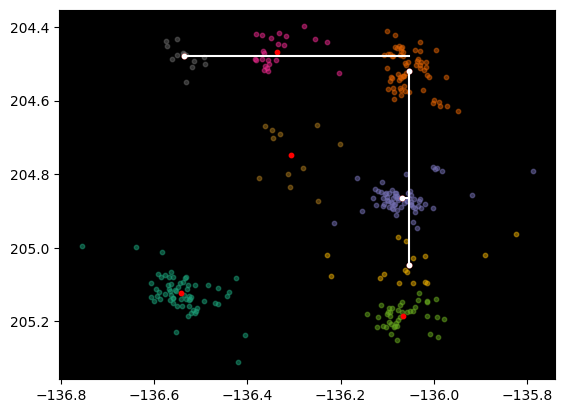

Group 135: Calculated Ratio: 0.028379565864411267


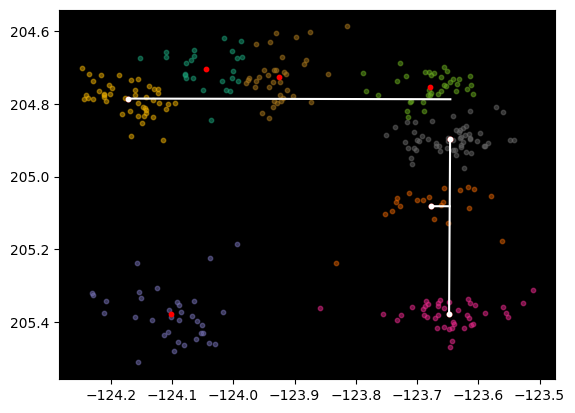

Group 136: Calculated Ratio: 0.05700548935478573


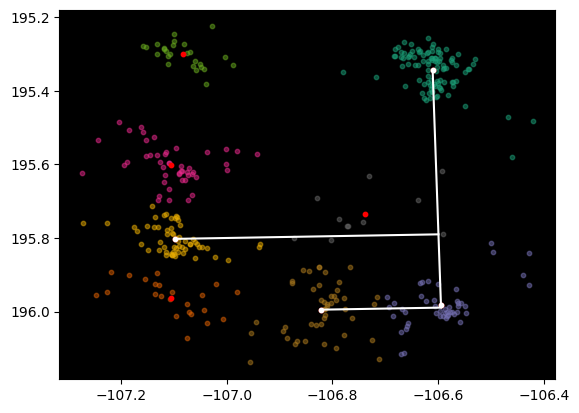

Group 137: Calculated Ratio: 0.4564892758627518


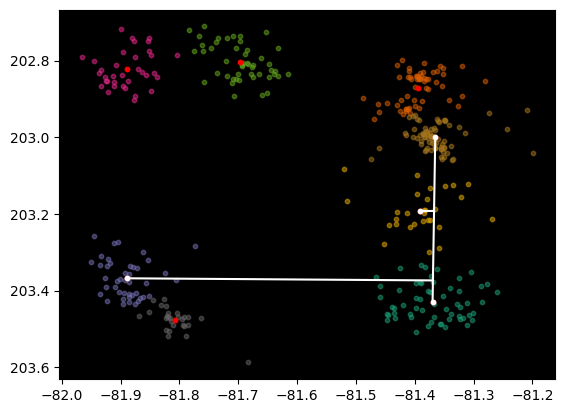

Group 138: Calculated Ratio: 0.04459162080232432


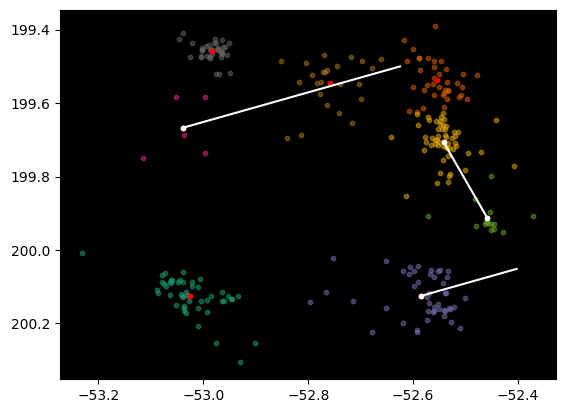

Group 139: Calculated Ratio: 0.43909001393556607


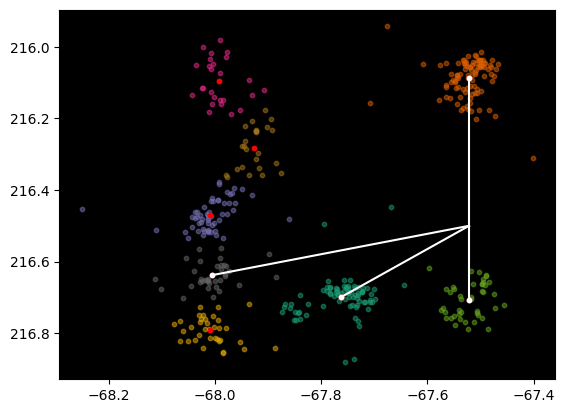

Group 140: Calculated Ratio: 0.49771352103838357


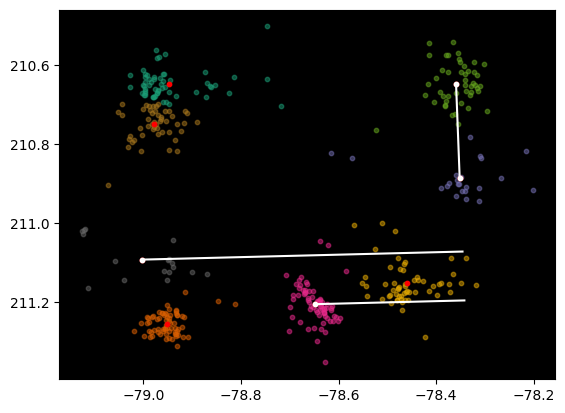

Group 141: Calculated Ratio: 0.4647664522148953


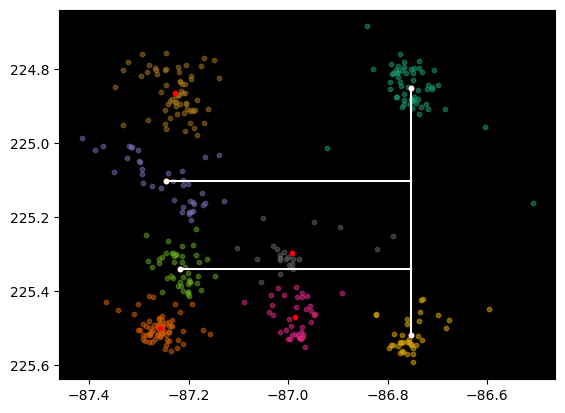

Group 142: Calculated Ratio: 0.9418183909347616


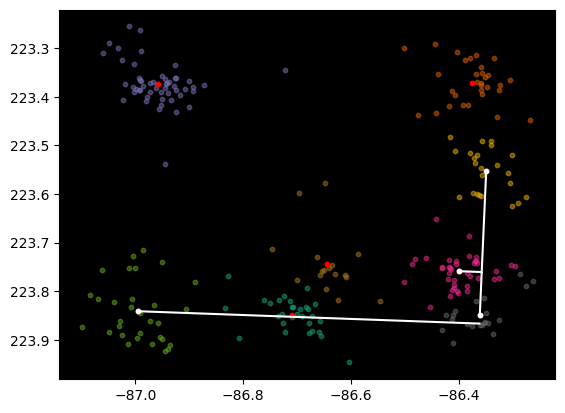

Group 143: Calculated Ratio: 0.06557642194840833


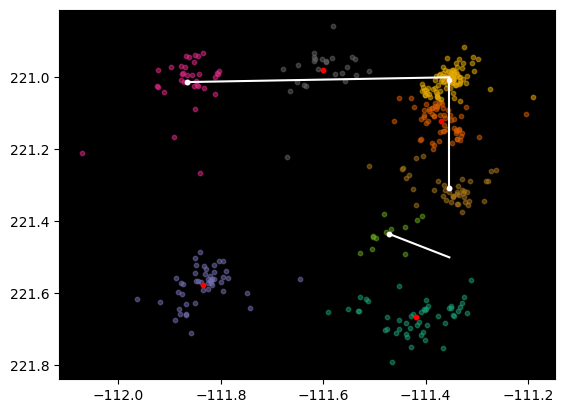

Group 144: Calculated Ratio: 0.23113090512322387


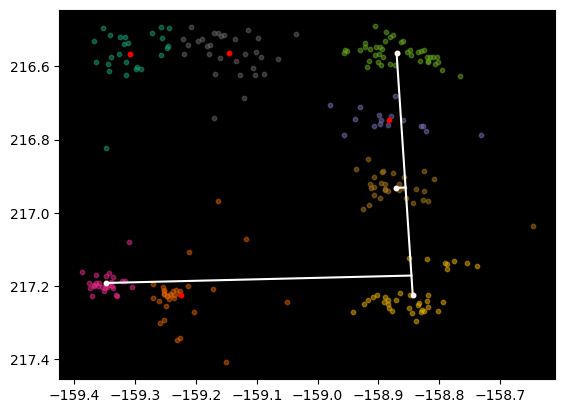

Group 145: Calculated Ratio: 0.03004021319832185


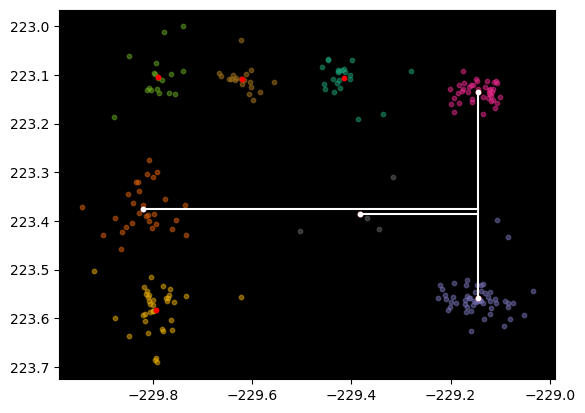

Group 146: Calculated Ratio: 0.352494674947493


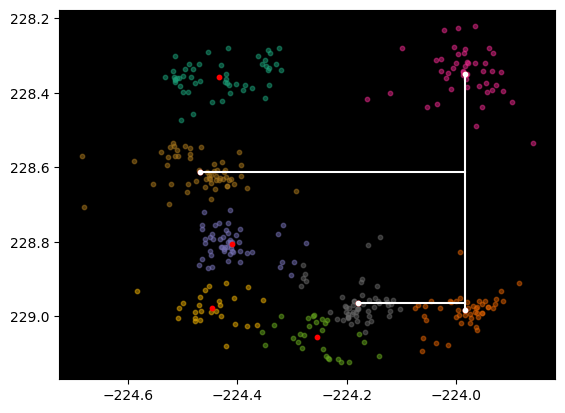

Group 147: Calculated Ratio: 0.4037550417566612


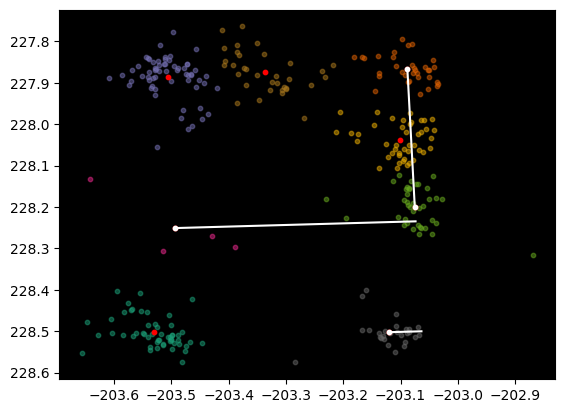

Group 148: Calculated Ratio: 0.1348102701201178


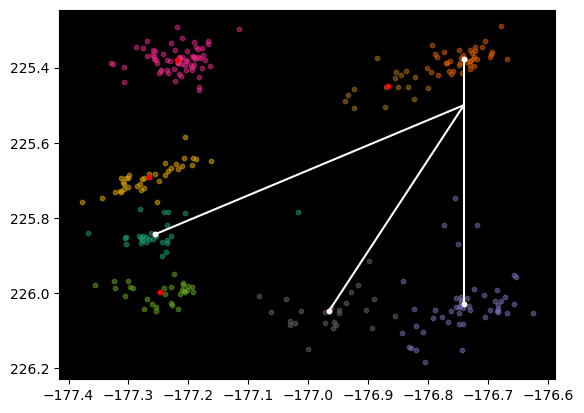

Group 149: Calculated Ratio: 0.4376705253347416


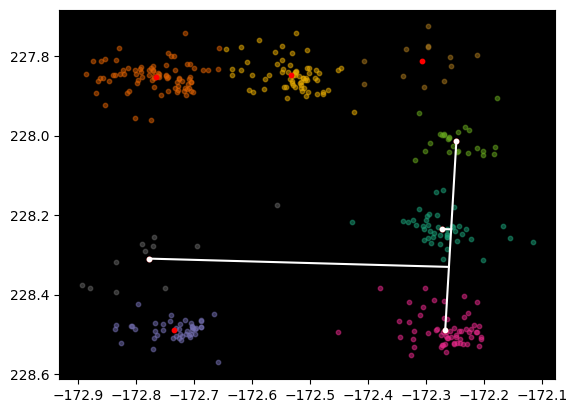

Group 150: Calculated Ratio: 0.029006610162638207


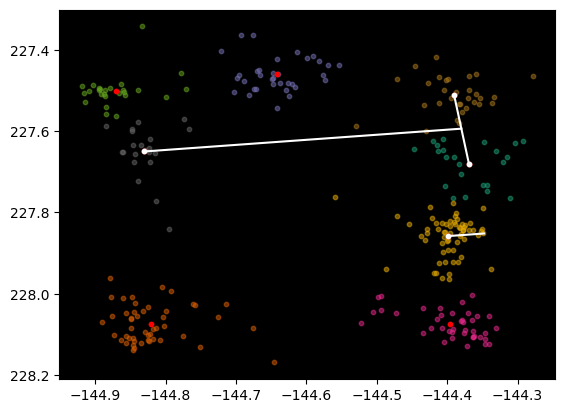

Group 151: Calculated Ratio: 0.11227115308410579


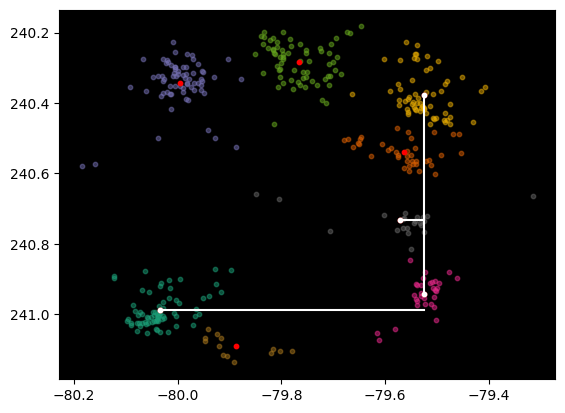

Group 152: Calculated Ratio: 0.08957178689276094


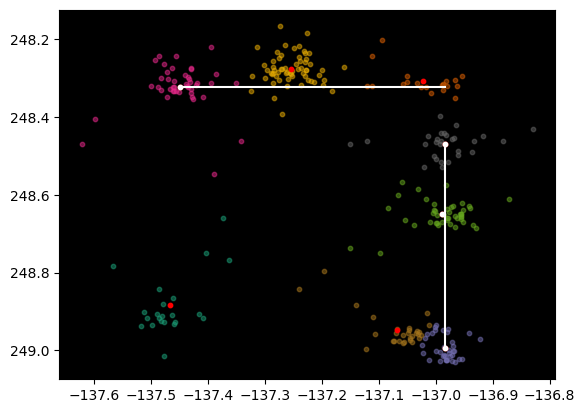

Group 153: Calculated Ratio: 0.011326101280952504


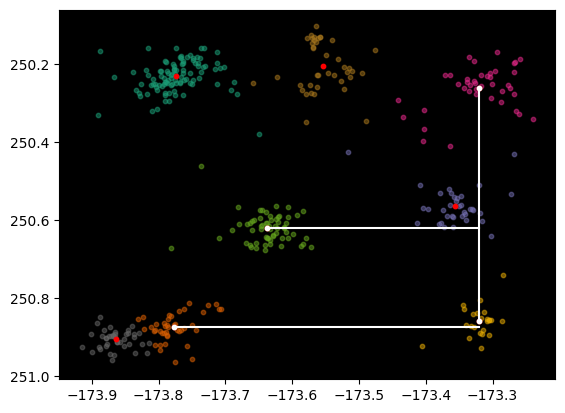

Group 154: Calculated Ratio: 0.6927967240231707


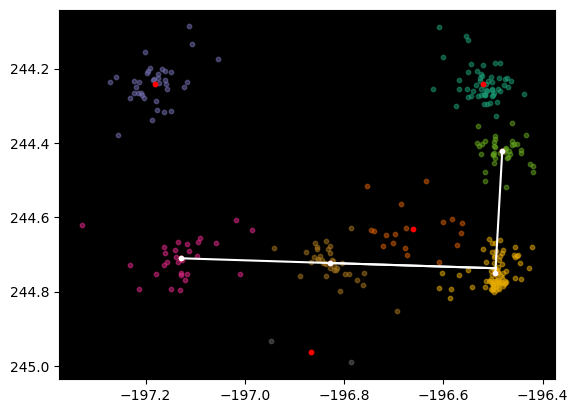

Group 155: Calculated Ratio: 0.5249583956560306


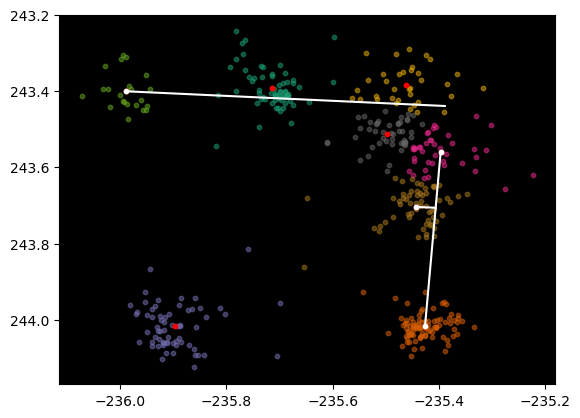

Group 156: Calculated Ratio: 0.062262987617137354


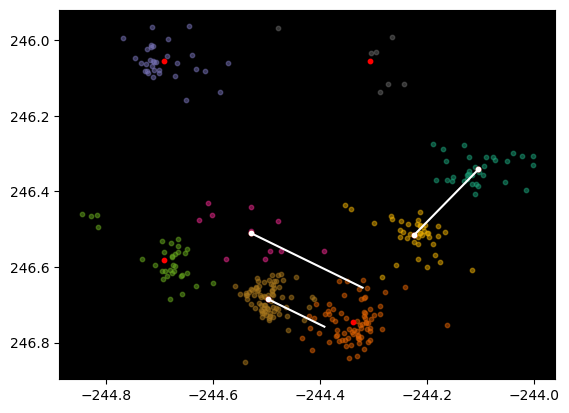

Group 157: Calculated Ratio: 0.5056538386554721


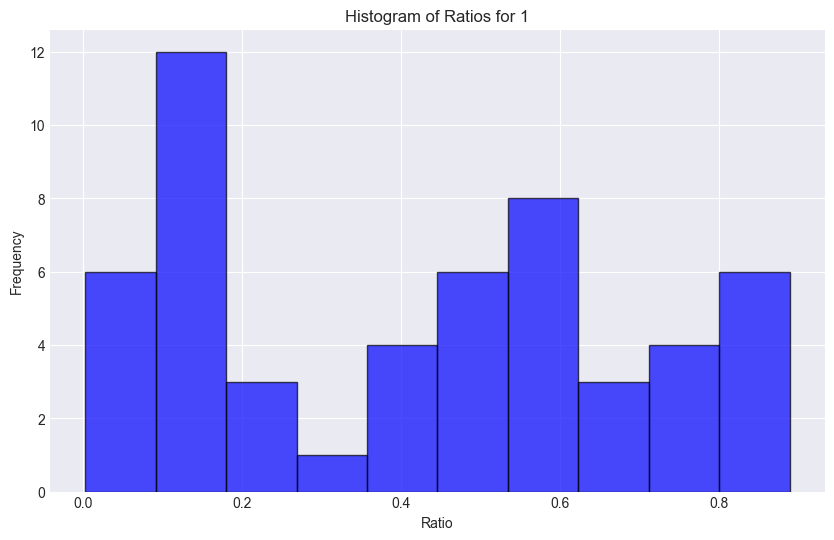

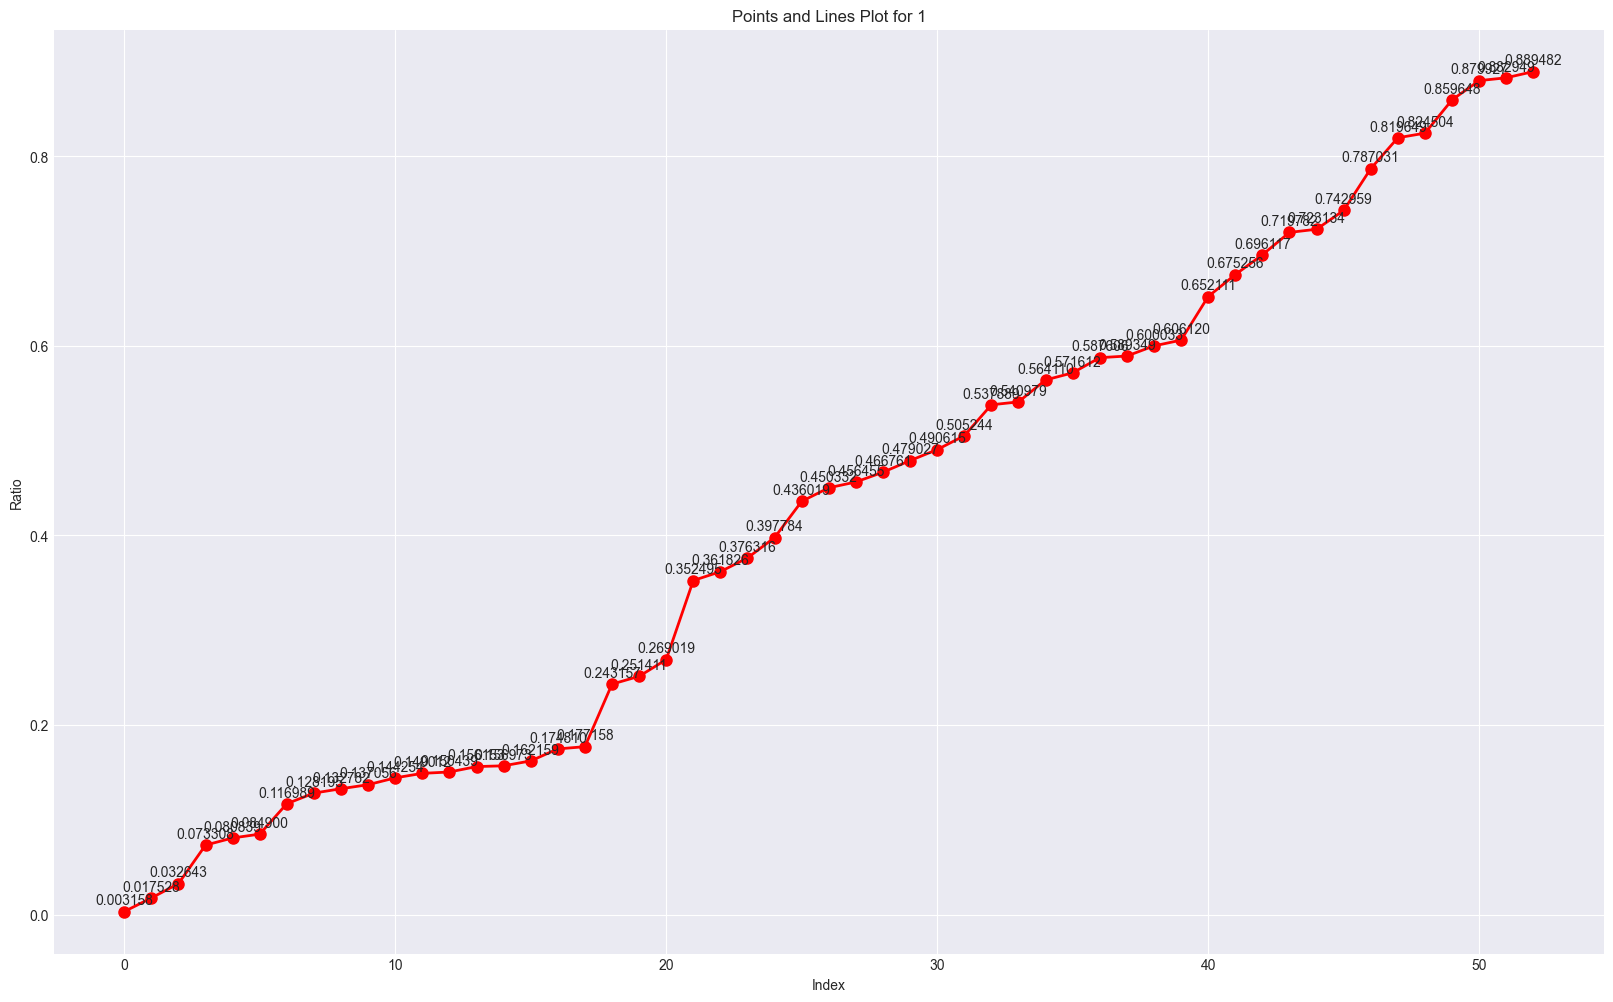

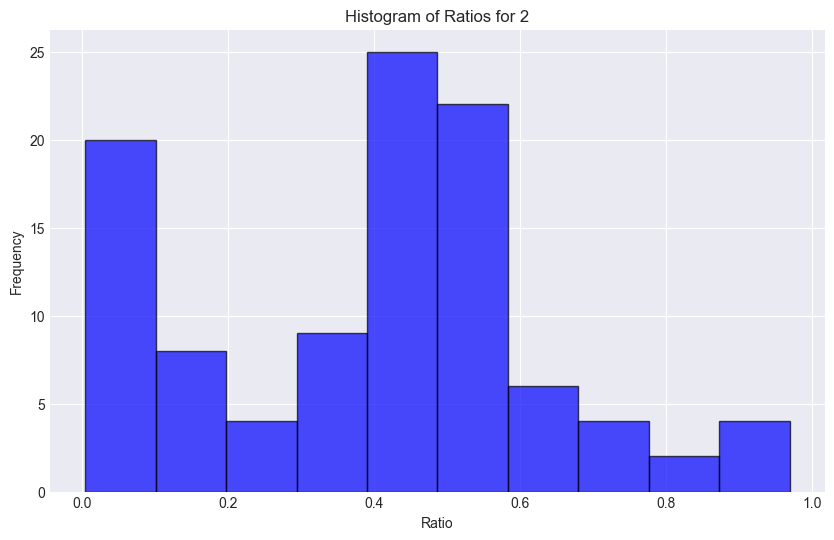

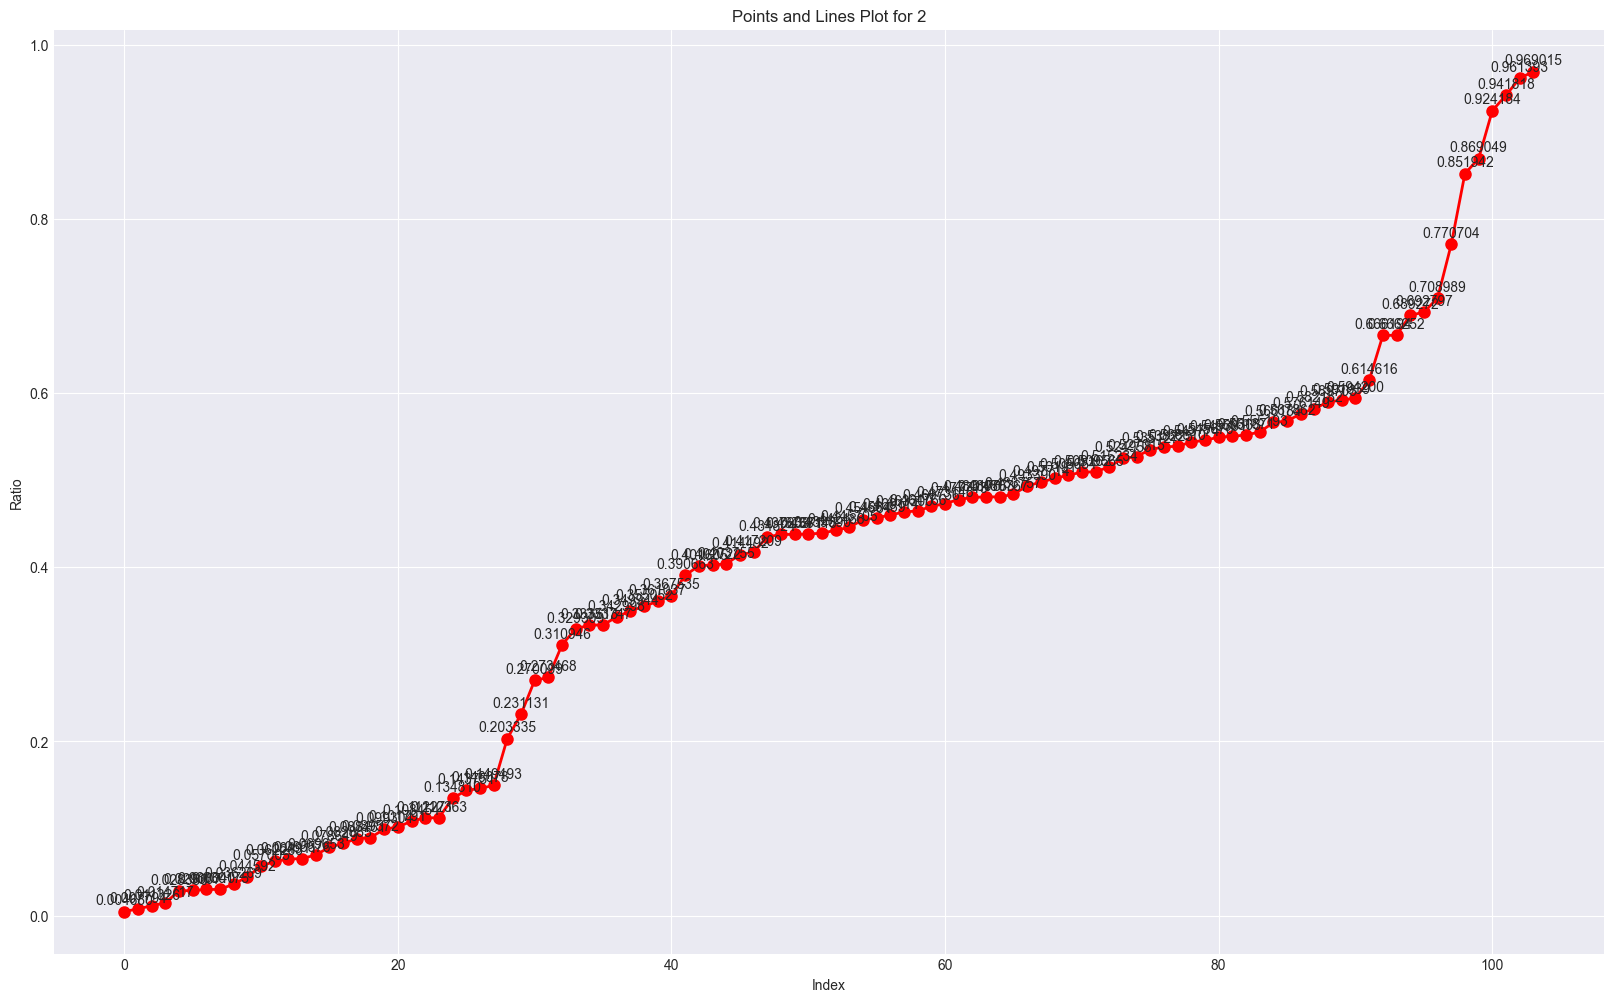

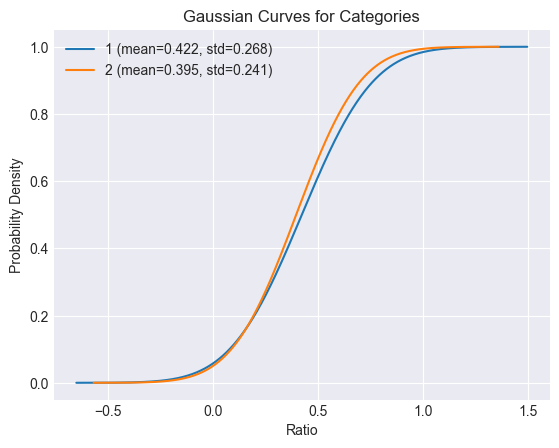

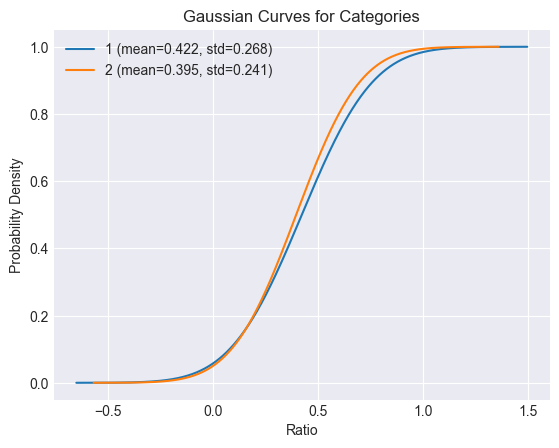

In [12]:
# Example usage
filename = 'data\csdna_v8_0.8nM_20nm_0.5nM_full_experiment02_t=24Hr_9824_T1_cropped_locs_picked_flipped_orientation.hdf5'
k = 8
flipped = True
ratios1, categories1, gaussian_curves1 = process_multiple_origami_ratio_with_categorize_and_gaussian(filename, k, flipped, eps=0.9, min_samples=5)
                                                                                                     


In [15]:
t24_gaussian_curve = gaussian_curves1["1"]

In [ ]:
print(t24_gaussian_curve)

In [13]:
# Generate the Gaussian curve for a specific category, e.g., "Category 1"
generate_individual_gaussian_curve("1", t2_gaussian_curve)

NameError: name 't2_gaussian_curve' is not defined

In [17]:
t2_gaussian_curve = {'mean': 0.4926701506845619, 'std': 0.2178780945034429, 'x_values': [-3.78842227e-01, -3.77097458e-01, -3.75352688e-01, -3.73607919e-01,
       -3.71863149e-01, -3.70118380e-01, -3.68373610e-01, -3.66628841e-01,
       -3.64884071e-01, -3.63139302e-01, -3.61394532e-01, -3.59649763e-01,
       -3.57904993e-01, -3.56160223e-01, -3.54415454e-01, -3.52670684e-01,
       -3.50925915e-01, -3.49181145e-01, -3.47436376e-01, -3.45691606e-01,
       -3.43946837e-01, -3.42202067e-01, -3.40457298e-01, -3.38712528e-01,
       -3.36967759e-01, -3.35222989e-01, -3.33478220e-01, -3.31733450e-01,
       -3.29988681e-01, -3.28243911e-01, -3.26499142e-01, -3.24754372e-01,
       -3.23009603e-01, -3.21264833e-01, -3.19520063e-01, -3.17775294e-01,
       -3.16030524e-01, -3.14285755e-01, -3.12540985e-01, -3.10796216e-01,
       -3.09051446e-01, -3.07306677e-01, -3.05561907e-01, -3.03817138e-01,
       -3.02072368e-01, -3.00327599e-01, -2.98582829e-01, -2.96838060e-01,
       -2.95093290e-01, -2.93348521e-01, -2.91603751e-01, -2.89858982e-01,
       -2.88114212e-01, -2.86369442e-01, -2.84624673e-01, -2.82879903e-01,
       -2.81135134e-01, -2.79390364e-01, -2.77645595e-01, -2.75900825e-01,
       -2.74156056e-01, -2.72411286e-01, -2.70666517e-01, -2.68921747e-01,
       -2.67176978e-01, -2.65432208e-01, -2.63687439e-01, -2.61942669e-01,
       -2.60197900e-01, -2.58453130e-01, -2.56708361e-01, -2.54963591e-01,
       -2.53218821e-01, -2.51474052e-01, -2.49729282e-01, -2.47984513e-01,
       -2.46239743e-01, -2.44494974e-01, -2.42750204e-01, -2.41005435e-01,
       -2.39260665e-01, -2.37515896e-01, -2.35771126e-01, -2.34026357e-01,
       -2.32281587e-01, -2.30536818e-01, -2.28792048e-01, -2.27047279e-01,
       -2.25302509e-01, -2.23557740e-01, -2.21812970e-01, -2.20068201e-01,
       -2.18323431e-01, -2.16578661e-01, -2.14833892e-01, -2.13089122e-01,
       -2.11344353e-01, -2.09599583e-01, -2.07854814e-01, -2.06110044e-01,
       -2.04365275e-01, -2.02620505e-01, -2.00875736e-01, -1.99130966e-01,
       -1.97386197e-01, -1.95641427e-01, -1.93896658e-01, -1.92151888e-01,
       -1.90407119e-01, -1.88662349e-01, -1.86917580e-01, -1.85172810e-01,
       -1.83428040e-01, -1.81683271e-01, -1.79938501e-01, -1.78193732e-01,
       -1.76448962e-01, -1.74704193e-01, -1.72959423e-01, -1.71214654e-01,
       -1.69469884e-01, -1.67725115e-01, -1.65980345e-01, -1.64235576e-01,
       -1.62490806e-01, -1.60746037e-01, -1.59001267e-01, -1.57256498e-01,
       -1.55511728e-01, -1.53766959e-01, -1.52022189e-01, -1.50277419e-01,
       -1.48532650e-01, -1.46787880e-01, -1.45043111e-01, -1.43298341e-01,
       -1.41553572e-01, -1.39808802e-01, -1.38064033e-01, -1.36319263e-01,
       -1.34574494e-01, -1.32829724e-01, -1.31084955e-01, -1.29340185e-01,
       -1.27595416e-01, -1.25850646e-01, -1.24105877e-01, -1.22361107e-01,
       -1.20616338e-01, -1.18871568e-01, -1.17126798e-01, -1.15382029e-01,
       -1.13637259e-01, -1.11892490e-01, -1.10147720e-01, -1.08402951e-01,
       -1.06658181e-01, -1.04913412e-01, -1.03168642e-01, -1.01423873e-01,
       -9.96791032e-02, -9.79343337e-02, -9.61895642e-02, -9.44447947e-02,
       -9.27000251e-02, -9.09552556e-02, -8.92104861e-02, -8.74657166e-02,
       -8.57209470e-02, -8.39761775e-02, -8.22314080e-02, -8.04866385e-02,
       -7.87418689e-02, -7.69970994e-02, -7.52523299e-02, -7.35075604e-02,
       -7.17627908e-02, -7.00180213e-02, -6.82732518e-02, -6.65284823e-02,
       -6.47837127e-02, -6.30389432e-02, -6.12941737e-02, -5.95494042e-02,
       -5.78046346e-02, -5.60598651e-02, -5.43150956e-02, -5.25703261e-02,
       -5.08255565e-02, -4.90807870e-02, -4.73360175e-02, -4.55912479e-02,
       -4.38464784e-02, -4.21017089e-02, -4.03569394e-02, -3.86121698e-02,
       -3.68674003e-02, -3.51226308e-02, -3.33778613e-02, -3.16330917e-02,
       -2.98883222e-02, -2.81435527e-02, -2.63987832e-02, -2.46540136e-02,
       -2.29092441e-02, -2.11644746e-02, -1.94197051e-02, -1.76749355e-02,
       -1.59301660e-02, -1.41853965e-02, -1.24406270e-02, -1.06958574e-02,
       -8.95108791e-03, -7.20631839e-03, -5.46154886e-03, -3.71677934e-03,
       -1.97200981e-03, -2.27240284e-04,  1.51752924e-03,  3.26229877e-03,
        5.00706829e-03,  6.75183782e-03,  8.49660734e-03,  1.02413769e-02,
        1.19861464e-02,  1.37309159e-02,  1.54756854e-02,  1.72204550e-02,
        1.89652245e-02,  2.07099940e-02,  2.24547635e-02,  2.41995331e-02,
        2.59443026e-02,  2.76890721e-02,  2.94338417e-02,  3.11786112e-02,
        3.29233807e-02,  3.46681502e-02,  3.64129198e-02,  3.81576893e-02,
        3.99024588e-02,  4.16472283e-02,  4.33919979e-02,  4.51367674e-02,
        4.68815369e-02,  4.86263064e-02,  5.03710760e-02,  5.21158455e-02,
        5.38606150e-02,  5.56053845e-02,  5.73501541e-02,  5.90949236e-02,
        6.08396931e-02,  6.25844626e-02,  6.43292322e-02,  6.60740017e-02,
        6.78187712e-02,  6.95635407e-02,  7.13083103e-02,  7.30530798e-02,
        7.47978493e-02,  7.65426188e-02,  7.82873884e-02,  8.00321579e-02,
        8.17769274e-02,  8.35216969e-02,  8.52664665e-02,  8.70112360e-02,
        8.87560055e-02,  9.05007750e-02,  9.22455446e-02,  9.39903141e-02,
        9.57350836e-02,  9.74798531e-02,  9.92246227e-02,  1.00969392e-01,
        1.02714162e-01,  1.04458931e-01,  1.06203701e-01,  1.07948470e-01,
        1.09693240e-01,  1.11438009e-01,  1.13182779e-01,  1.14927548e-01,
        1.16672318e-01,  1.18417087e-01,  1.20161857e-01,  1.21906627e-01,
        1.23651396e-01,  1.25396166e-01,  1.27140935e-01,  1.28885705e-01,
        1.30630474e-01,  1.32375244e-01,  1.34120013e-01,  1.35864783e-01,
        1.37609552e-01,  1.39354322e-01,  1.41099091e-01,  1.42843861e-01,
        1.44588630e-01,  1.46333400e-01,  1.48078169e-01,  1.49822939e-01,
        1.51567708e-01,  1.53312478e-01,  1.55057247e-01,  1.56802017e-01,
        1.58546787e-01,  1.60291556e-01,  1.62036326e-01,  1.63781095e-01,
        1.65525865e-01,  1.67270634e-01,  1.69015404e-01,  1.70760173e-01,
        1.72504943e-01,  1.74249712e-01,  1.75994482e-01,  1.77739251e-01,
        1.79484021e-01,  1.81228790e-01,  1.82973560e-01,  1.84718329e-01,
        1.86463099e-01,  1.88207868e-01,  1.89952638e-01,  1.91697408e-01,
        1.93442177e-01,  1.95186947e-01,  1.96931716e-01,  1.98676486e-01,
        2.00421255e-01,  2.02166025e-01,  2.03910794e-01,  2.05655564e-01,
        2.07400333e-01,  2.09145103e-01,  2.10889872e-01,  2.12634642e-01,
        2.14379411e-01,  2.16124181e-01,  2.17868950e-01,  2.19613720e-01,
        2.21358489e-01,  2.23103259e-01,  2.24848029e-01,  2.26592798e-01,
        2.28337568e-01,  2.30082337e-01,  2.31827107e-01,  2.33571876e-01,
        2.35316646e-01,  2.37061415e-01,  2.38806185e-01,  2.40550954e-01,
        2.42295724e-01,  2.44040493e-01,  2.45785263e-01,  2.47530032e-01,
        2.49274802e-01,  2.51019571e-01,  2.52764341e-01,  2.54509110e-01,
        2.56253880e-01,  2.57998649e-01,  2.59743419e-01,  2.61488189e-01,
        2.63232958e-01,  2.64977728e-01,  2.66722497e-01,  2.68467267e-01,
        2.70212036e-01,  2.71956806e-01,  2.73701575e-01,  2.75446345e-01,
        2.77191114e-01,  2.78935884e-01,  2.80680653e-01,  2.82425423e-01,
        2.84170192e-01,  2.85914962e-01,  2.87659731e-01,  2.89404501e-01,
        2.91149270e-01,  2.92894040e-01,  2.94638810e-01,  2.96383579e-01,
        2.98128349e-01,  2.99873118e-01,  3.01617888e-01,  3.03362657e-01,
        3.05107427e-01,  3.06852196e-01,  3.08596966e-01,  3.10341735e-01,
        3.12086505e-01,  3.13831274e-01,  3.15576044e-01,  3.17320813e-01,
        3.19065583e-01,  3.20810352e-01,  3.22555122e-01,  3.24299891e-01,
        3.26044661e-01,  3.27789431e-01,  3.29534200e-01,  3.31278970e-01,
        3.33023739e-01,  3.34768509e-01,  3.36513278e-01,  3.38258048e-01,
        3.40002817e-01,  3.41747587e-01,  3.43492356e-01,  3.45237126e-01,
        3.46981895e-01,  3.48726665e-01,  3.50471434e-01,  3.52216204e-01,
        3.53960973e-01,  3.55705743e-01,  3.57450512e-01,  3.59195282e-01,
        3.60940052e-01,  3.62684821e-01,  3.64429591e-01,  3.66174360e-01,
        3.67919130e-01,  3.69663899e-01,  3.71408669e-01,  3.73153438e-01,
        3.74898208e-01,  3.76642977e-01,  3.78387747e-01,  3.80132516e-01,
        3.81877286e-01,  3.83622055e-01,  3.85366825e-01,  3.87111594e-01,
        3.88856364e-01,  3.90601133e-01,  3.92345903e-01,  3.94090672e-01,
        3.95835442e-01,  3.97580212e-01,  3.99324981e-01,  4.01069751e-01,
        4.02814520e-01,  4.04559290e-01,  4.06304059e-01,  4.08048829e-01,
        4.09793598e-01,  4.11538368e-01,  4.13283137e-01,  4.15027907e-01,
        4.16772676e-01,  4.18517446e-01,  4.20262215e-01,  4.22006985e-01,
        4.23751754e-01,  4.25496524e-01,  4.27241293e-01,  4.28986063e-01,
        4.30730833e-01,  4.32475602e-01,  4.34220372e-01,  4.35965141e-01,
        4.37709911e-01,  4.39454680e-01,  4.41199450e-01,  4.42944219e-01,
        4.44688989e-01,  4.46433758e-01,  4.48178528e-01,  4.49923297e-01,
        4.51668067e-01,  4.53412836e-01,  4.55157606e-01,  4.56902375e-01,
        4.58647145e-01,  4.60391914e-01,  4.62136684e-01,  4.63881454e-01,
        4.65626223e-01,  4.67370993e-01,  4.69115762e-01,  4.70860532e-01,
        4.72605301e-01,  4.74350071e-01,  4.76094840e-01,  4.77839610e-01,
        4.79584379e-01,  4.81329149e-01,  4.83073918e-01,  4.84818688e-01,
        4.86563457e-01,  4.88308227e-01,  4.90052996e-01,  4.91797766e-01,
        4.93542535e-01,  4.95287305e-01,  4.97032074e-01,  4.98776844e-01,
        5.00521614e-01,  5.02266383e-01,  5.04011153e-01,  5.05755922e-01,
        5.07500692e-01,  5.09245461e-01,  5.10990231e-01,  5.12735000e-01,
        5.14479770e-01,  5.16224539e-01,  5.17969309e-01,  5.19714078e-01,
        5.21458848e-01,  5.23203617e-01,  5.24948387e-01,  5.26693156e-01,
        5.28437926e-01,  5.30182695e-01,  5.31927465e-01,  5.33672235e-01,
        5.35417004e-01,  5.37161774e-01,  5.38906543e-01,  5.40651313e-01,
        5.42396082e-01,  5.44140852e-01,  5.45885621e-01,  5.47630391e-01,
        5.49375160e-01,  5.51119930e-01,  5.52864699e-01,  5.54609469e-01,
        5.56354238e-01,  5.58099008e-01,  5.59843777e-01,  5.61588547e-01,
        5.63333316e-01,  5.65078086e-01,  5.66822856e-01,  5.68567625e-01,
        5.70312395e-01,  5.72057164e-01,  5.73801934e-01,  5.75546703e-01,
        5.77291473e-01,  5.79036242e-01,  5.80781012e-01,  5.82525781e-01,
        5.84270551e-01,  5.86015320e-01,  5.87760090e-01,  5.89504859e-01,
        5.91249629e-01,  5.92994398e-01,  5.94739168e-01,  5.96483937e-01,
        5.98228707e-01,  5.99973477e-01,  6.01718246e-01,  6.03463016e-01,
        6.05207785e-01,  6.06952555e-01,  6.08697324e-01,  6.10442094e-01,
        6.12186863e-01,  6.13931633e-01,  6.15676402e-01,  6.17421172e-01,
        6.19165941e-01,  6.20910711e-01,  6.22655480e-01,  6.24400250e-01,
        6.26145019e-01,  6.27889789e-01,  6.29634558e-01,  6.31379328e-01,
        6.33124097e-01,  6.34868867e-01,  6.36613637e-01,  6.38358406e-01,
        6.40103176e-01,  6.41847945e-01,  6.43592715e-01,  6.45337484e-01,
        6.47082254e-01,  6.48827023e-01,  6.50571793e-01,  6.52316562e-01,
        6.54061332e-01,  6.55806101e-01,  6.57550871e-01,  6.59295640e-01,
        6.61040410e-01,  6.62785179e-01,  6.64529949e-01,  6.66274718e-01,
        6.68019488e-01,  6.69764258e-01,  6.71509027e-01,  6.73253797e-01,
        6.74998566e-01,  6.76743336e-01,  6.78488105e-01,  6.80232875e-01,
        6.81977644e-01,  6.83722414e-01,  6.85467183e-01,  6.87211953e-01,
        6.88956722e-01,  6.90701492e-01,  6.92446261e-01,  6.94191031e-01,
        6.95935800e-01,  6.97680570e-01,  6.99425339e-01,  7.01170109e-01,
        7.02914879e-01,  7.04659648e-01,  7.06404418e-01,  7.08149187e-01,
        7.09893957e-01,  7.11638726e-01,  7.13383496e-01,  7.15128265e-01,
        7.16873035e-01,  7.18617804e-01,  7.20362574e-01,  7.22107343e-01,
        7.23852113e-01,  7.25596882e-01,  7.27341652e-01,  7.29086421e-01,
        7.30831191e-01,  7.32575960e-01,  7.34320730e-01,  7.36065499e-01,
        7.37810269e-01,  7.39555039e-01,  7.41299808e-01,  7.43044578e-01,
        7.44789347e-01,  7.46534117e-01,  7.48278886e-01,  7.50023656e-01,
        7.51768425e-01,  7.53513195e-01,  7.55257964e-01,  7.57002734e-01,
        7.58747503e-01,  7.60492273e-01,  7.62237042e-01,  7.63981812e-01,
        7.65726581e-01,  7.67471351e-01,  7.69216120e-01,  7.70960890e-01,
        7.72705660e-01,  7.74450429e-01,  7.76195199e-01,  7.77939968e-01,
        7.79684738e-01,  7.81429507e-01,  7.83174277e-01,  7.84919046e-01,
        7.86663816e-01,  7.88408585e-01,  7.90153355e-01,  7.91898124e-01,
        7.93642894e-01,  7.95387663e-01,  7.97132433e-01,  7.98877202e-01,
        8.00621972e-01,  8.02366741e-01,  8.04111511e-01,  8.05856281e-01,
        8.07601050e-01,  8.09345820e-01,  8.11090589e-01,  8.12835359e-01,
        8.14580128e-01,  8.16324898e-01,  8.18069667e-01,  8.19814437e-01,
        8.21559206e-01,  8.23303976e-01,  8.25048745e-01,  8.26793515e-01,
        8.28538284e-01,  8.30283054e-01,  8.32027823e-01,  8.33772593e-01,
        8.35517362e-01,  8.37262132e-01,  8.39006902e-01,  8.40751671e-01,
        8.42496441e-01,  8.44241210e-01,  8.45985980e-01,  8.47730749e-01,
        8.49475519e-01,  8.51220288e-01,  8.52965058e-01,  8.54709827e-01,
        8.56454597e-01,  8.58199366e-01,  8.59944136e-01,  8.61688905e-01,
        8.63433675e-01,  8.65178444e-01,  8.66923214e-01,  8.68667983e-01,
        8.70412753e-01,  8.72157522e-01,  8.73902292e-01,  8.75647062e-01,
        8.77391831e-01,  8.79136601e-01,  8.80881370e-01,  8.82626140e-01,
        8.84370909e-01,  8.86115679e-01,  8.87860448e-01,  8.89605218e-01,
        8.91349987e-01,  8.93094757e-01,  8.94839526e-01,  8.96584296e-01,
        8.98329065e-01,  9.00073835e-01,  9.01818604e-01,  9.03563374e-01,
        9.05308143e-01,  9.07052913e-01,  9.08797683e-01,  9.10542452e-01,
        9.12287222e-01,  9.14031991e-01,  9.15776761e-01,  9.17521530e-01,
        9.19266300e-01,  9.21011069e-01,  9.22755839e-01,  9.24500608e-01,
        9.26245378e-01,  9.27990147e-01,  9.29734917e-01,  9.31479686e-01,
        9.33224456e-01,  9.34969225e-01,  9.36713995e-01,  9.38458764e-01,
        9.40203534e-01,  9.41948304e-01,  9.43693073e-01,  9.45437843e-01,
        9.47182612e-01,  9.48927382e-01,  9.50672151e-01,  9.52416921e-01,
        9.54161690e-01,  9.55906460e-01,  9.57651229e-01,  9.59395999e-01,
        9.61140768e-01,  9.62885538e-01,  9.64630307e-01,  9.66375077e-01,
        9.68119846e-01,  9.69864616e-01,  9.71609385e-01,  9.73354155e-01,
        9.75098924e-01,  9.76843694e-01,  9.78588464e-01,  9.80333233e-01,
        9.82078003e-01,  9.83822772e-01,  9.85567542e-01,  9.87312311e-01,
        9.89057081e-01,  9.90801850e-01,  9.92546620e-01,  9.94291389e-01,
        9.96036159e-01,  9.97780928e-01,  9.99525698e-01,  1.00127047e+00,
        1.00301524e+00,  1.00476001e+00,  1.00650478e+00,  1.00824955e+00,
        1.00999432e+00,  1.01173908e+00,  1.01348385e+00,  1.01522862e+00,
        1.01697339e+00,  1.01871816e+00,  1.02046293e+00,  1.02220770e+00,
        1.02395247e+00,  1.02569724e+00,  1.02744201e+00,  1.02918678e+00,
        1.03093155e+00,  1.03267632e+00,  1.03442109e+00,  1.03616586e+00,
        1.03791063e+00,  1.03965540e+00,  1.04140017e+00,  1.04314494e+00,
        1.04488971e+00,  1.04663448e+00,  1.04837924e+00,  1.05012401e+00,
        1.05186878e+00,  1.05361355e+00,  1.05535832e+00,  1.05710309e+00,
        1.05884786e+00,  1.06059263e+00,  1.06233740e+00,  1.06408217e+00,
        1.06582694e+00,  1.06757171e+00,  1.06931648e+00,  1.07106125e+00,
        1.07280602e+00,  1.07455079e+00,  1.07629556e+00,  1.07804033e+00,
        1.07978510e+00,  1.08152987e+00,  1.08327464e+00,  1.08501940e+00,
        1.08676417e+00,  1.08850894e+00,  1.09025371e+00,  1.09199848e+00,
        1.09374325e+00,  1.09548802e+00,  1.09723279e+00,  1.09897756e+00,
        1.10072233e+00,  1.10246710e+00,  1.10421187e+00,  1.10595664e+00,
        1.10770141e+00,  1.10944618e+00,  1.11119095e+00,  1.11293572e+00,
        1.11468049e+00,  1.11642526e+00,  1.11817003e+00,  1.11991480e+00,
        1.12165956e+00,  1.12340433e+00,  1.12514910e+00,  1.12689387e+00,
        1.12863864e+00,  1.13038341e+00,  1.13212818e+00,  1.13387295e+00,
        1.13561772e+00,  1.13736249e+00,  1.13910726e+00,  1.14085203e+00,
        1.14259680e+00,  1.14434157e+00,  1.14608634e+00,  1.14783111e+00,
        1.14957588e+00,  1.15132065e+00,  1.15306542e+00,  1.15481019e+00,
        1.15655496e+00,  1.15829972e+00,  1.16004449e+00,  1.16178926e+00,
        1.16353403e+00,  1.16527880e+00,  1.16702357e+00,  1.16876834e+00,
        1.17051311e+00,  1.17225788e+00,  1.17400265e+00,  1.17574742e+00,
        1.17749219e+00,  1.17923696e+00,  1.18098173e+00,  1.18272650e+00,
        1.18447127e+00,  1.18621604e+00,  1.18796081e+00,  1.18970558e+00,
        1.19145035e+00,  1.19319512e+00,  1.19493988e+00,  1.19668465e+00,
        1.19842942e+00,  1.20017419e+00,  1.20191896e+00,  1.20366373e+00,
        1.20540850e+00,  1.20715327e+00,  1.20889804e+00,  1.21064281e+00,
        1.21238758e+00,  1.21413235e+00,  1.21587712e+00,  1.21762189e+00,
        1.21936666e+00,  1.22111143e+00,  1.22285620e+00,  1.22460097e+00,
        1.22634574e+00,  1.22809051e+00,  1.22983528e+00,  1.23158004e+00,
        1.23332481e+00,  1.23506958e+00,  1.23681435e+00,  1.23855912e+00,
        1.24030389e+00,  1.24204866e+00,  1.24379343e+00,  1.24553820e+00,
        1.24728297e+00,  1.24902774e+00,  1.25077251e+00,  1.25251728e+00,
        1.25426205e+00,  1.25600682e+00,  1.25775159e+00,  1.25949636e+00,
        1.26124113e+00,  1.26298590e+00,  1.26473067e+00,  1.26647544e+00,
        1.26822020e+00,  1.26996497e+00,  1.27170974e+00,  1.27345451e+00,
        1.27519928e+00,  1.27694405e+00,  1.27868882e+00,  1.28043359e+00,
        1.28217836e+00,  1.28392313e+00,  1.28566790e+00,  1.28741267e+00,
        1.28915744e+00,  1.29090221e+00,  1.29264698e+00,  1.29439175e+00,
        1.29613652e+00,  1.29788129e+00,  1.29962606e+00,  1.30137083e+00,
        1.30311560e+00,  1.30486036e+00,  1.30660513e+00,  1.30834990e+00,
        1.31009467e+00,  1.31183944e+00,  1.31358421e+00,  1.31532898e+00,
        1.31707375e+00,  1.31881852e+00,  1.32056329e+00,  1.32230806e+00,
        1.32405283e+00,  1.32579760e+00,  1.32754237e+00,  1.32928714e+00,
        1.33103191e+00,  1.33277668e+00,  1.33452145e+00,  1.33626622e+00,
        1.33801099e+00,  1.33975576e+00,  1.34150052e+00,  1.34324529e+00,
        1.34499006e+00,  1.34673483e+00,  1.34847960e+00,  1.35022437e+00,
        1.35196914e+00,  1.35371391e+00,  1.35545868e+00,  1.35720345e+00,
        1.35894822e+00,  1.36069299e+00,  1.36243776e+00,  1.36418253e+00], 'y_values': [3.16712418e-05, 3.27602929e-05, 3.38847210e-05, 3.50456008e-05,
       3.62440370e-05, 3.74811655e-05, 3.87581535e-05, 4.00762007e-05,
       4.14365401e-05, 4.28404387e-05, 4.42891983e-05, 4.57841567e-05,
       4.73266881e-05, 4.89182043e-05, 5.05601555e-05, 5.22540316e-05,
       5.40013623e-05, 5.58037192e-05, 5.76627157e-05, 5.95800090e-05,
       6.15573002e-05, 6.35963362e-05, 6.56989103e-05, 6.78668632e-05,
       7.01020846e-05, 7.24065140e-05, 7.47821418e-05, 7.72310108e-05,
       7.97552172e-05, 8.23569117e-05, 8.50383012e-05, 8.78016497e-05,
       9.06492797e-05, 9.35835735e-05, 9.66069748e-05, 9.97219899e-05,
       1.02931189e-04, 1.06237207e-04, 1.09642748e-04, 1.13150582e-04,
       1.16763550e-04, 1.20484565e-04, 1.24316612e-04, 1.28262750e-04,
       1.32326117e-04, 1.36509926e-04, 1.40817471e-04, 1.45252128e-04,
       1.49817354e-04, 1.54516692e-04, 1.59353773e-04, 1.64332313e-04,
       1.69456123e-04, 1.74729101e-04, 1.80155243e-04, 1.85738641e-04,
       1.91483482e-04, 1.97394056e-04, 2.03474754e-04, 2.09730072e-04,
       2.16164611e-04, 2.22783083e-04, 2.29590308e-04, 2.36591220e-04,
       2.43790869e-04, 2.51194421e-04, 2.58807164e-04, 2.66634505e-04,
       2.74681979e-04, 2.82955245e-04, 2.91460094e-04, 3.00202447e-04,
       3.09188360e-04, 3.18424026e-04, 3.27915779e-04, 3.37670093e-04,
       3.47693590e-04, 3.57993036e-04, 3.68575350e-04, 3.79447604e-04,
       3.90617025e-04, 4.02091000e-04, 4.13877077e-04, 4.25982969e-04,
       4.38416558e-04, 4.51185894e-04, 4.64299202e-04, 4.77764887e-04,
       4.91591528e-04, 5.05787892e-04, 5.20362930e-04, 5.35325784e-04,
       5.50685787e-04, 5.66452470e-04, 5.82635563e-04, 5.99244997e-04,
       6.16290911e-04, 6.33783655e-04, 6.51733790e-04, 6.70152094e-04,
       6.89049566e-04, 7.08437428e-04, 7.28327132e-04, 7.48730357e-04,
       7.69659021e-04, 7.91125277e-04, 8.13141525e-04, 8.35720406e-04,
       8.58874814e-04, 8.82617896e-04, 9.06963059e-04, 9.31923968e-04,
       9.57514555e-04, 9.83749025e-04, 1.01064185e-03, 1.03820779e-03,
       1.06646187e-03, 1.09541943e-03, 1.12509606e-03, 1.15550768e-03,
       1.18667049e-03, 1.21860099e-03, 1.25131601e-03, 1.28483267e-03,
       1.31916841e-03, 1.35434098e-03, 1.39036848e-03, 1.42726933e-03,
       1.46506225e-03, 1.50376635e-03, 1.54340104e-03, 1.58398610e-03,
       1.62554166e-03, 1.66808818e-03, 1.71164651e-03, 1.75623785e-03,
       1.80188378e-03, 1.84860623e-03, 1.89642753e-03, 1.94537039e-03,
       1.99545788e-03, 2.04671351e-03, 2.09916115e-03, 2.15282507e-03,
       2.20772997e-03, 2.26390094e-03, 2.32136348e-03, 2.38014353e-03,
       2.44026744e-03, 2.50176199e-03, 2.56465439e-03, 2.62897229e-03,
       2.69474379e-03, 2.76199742e-03, 2.83076217e-03, 2.90106749e-03,
       2.97294328e-03, 3.04641991e-03, 3.12152822e-03, 3.19829952e-03,
       3.27676560e-03, 3.35695873e-03, 3.43891166e-03, 3.52265765e-03,
       3.60823043e-03, 3.69566425e-03, 3.78499385e-03, 3.87625449e-03,
       3.96948193e-03, 4.06471244e-03, 4.16198284e-03, 4.26133044e-03,
       4.36279310e-03, 4.46640920e-03, 4.57221766e-03, 4.68025793e-03,
       4.79057002e-03, 4.90319448e-03, 5.01817240e-03, 5.13554544e-03,
       5.25535581e-03, 5.37764628e-03, 5.50246017e-03, 5.62984140e-03,
       5.75983443e-03, 5.89248431e-03, 6.02783666e-03, 6.16593768e-03,
       6.30683416e-03, 6.45057346e-03, 6.59720354e-03, 6.74677294e-03,
       6.89933081e-03, 7.05492686e-03, 7.21361144e-03, 7.37543547e-03,
       7.54045048e-03, 7.70870861e-03, 7.88026258e-03, 8.05516574e-03,
       8.23347205e-03, 8.41523605e-03, 8.60051293e-03, 8.78935846e-03,
       8.98182903e-03, 9.17798166e-03, 9.37787396e-03, 9.58156416e-03,
       9.78911113e-03, 1.00005743e-02, 1.02160138e-02, 1.04354903e-02,
       1.06590650e-02, 1.08868000e-02, 1.11187578e-02, 1.13550015e-02,
       1.15955949e-02, 1.18406023e-02, 1.20900887e-02, 1.23441198e-02,
       1.26027617e-02, 1.28660812e-02, 1.31341457e-02, 1.34070233e-02,
       1.36847825e-02, 1.39674925e-02, 1.42552232e-02, 1.45480449e-02,
       1.48460286e-02, 1.51492458e-02, 1.54577687e-02, 1.57716699e-02,
       1.60910228e-02, 1.64159012e-02, 1.67463795e-02, 1.70825327e-02,
       1.74244363e-02, 1.77721664e-02, 1.81257995e-02, 1.84854129e-02,
       1.88510842e-02, 1.92228916e-02, 1.96009138e-02, 1.99852302e-02,
       2.03759203e-02, 2.07730645e-02, 2.11767434e-02, 2.15870384e-02,
       2.20040311e-02, 2.24278036e-02, 2.28584386e-02, 2.32960191e-02,
       2.37406286e-02, 2.41923512e-02, 2.46512711e-02, 2.51174731e-02,
       2.55910424e-02, 2.60720646e-02, 2.65606256e-02, 2.70568118e-02,
       2.75607099e-02, 2.80724069e-02, 2.85919903e-02, 2.91195476e-02,
       2.96551669e-02, 3.01989367e-02, 3.07509454e-02, 3.13112820e-02,
       3.18800357e-02, 3.24572958e-02, 3.30431521e-02, 3.36376944e-02,
       3.42410128e-02, 3.48531975e-02, 3.54743391e-02, 3.61045282e-02,
       3.67438556e-02, 3.73924121e-02, 3.80502889e-02, 3.87175771e-02,
       3.93943678e-02, 4.00807525e-02, 4.07768225e-02, 4.14826691e-02,
       4.21983838e-02, 4.29240580e-02, 4.36597832e-02, 4.44056506e-02,
       4.51617517e-02, 4.59281777e-02, 4.67050197e-02, 4.74923689e-02,
       4.82903161e-02, 4.90989522e-02, 4.99183678e-02, 5.07486534e-02,
       5.15898991e-02, 5.24421951e-02, 5.33056311e-02, 5.41802965e-02,
       5.50662807e-02, 5.59636726e-02, 5.68725607e-02, 5.77930333e-02,
       5.87251783e-02, 5.96690832e-02, 6.06248350e-02, 6.15925203e-02,
       6.25722254e-02, 6.35640359e-02, 6.45680371e-02, 6.55843135e-02,
       6.66129493e-02, 6.76540281e-02, 6.87076327e-02, 6.97738456e-02,
       7.08527484e-02, 7.19444222e-02, 7.30489472e-02, 7.41664031e-02,
       7.52968688e-02, 7.64404224e-02, 7.75971413e-02, 7.87671020e-02,
       7.99503801e-02, 8.11470507e-02, 8.23571875e-02, 8.35808638e-02,
       8.48181515e-02, 8.60691220e-02, 8.73338453e-02, 8.86123908e-02,
       8.99048266e-02, 9.12112197e-02, 9.25316364e-02, 9.38661414e-02,
       9.52147987e-02, 9.65776710e-02, 9.79548197e-02, 9.93463051e-02,
       1.00752186e-01, 1.02172521e-01, 1.03607367e-01, 1.05056778e-01,
       1.06520808e-01, 1.07999510e-01, 1.09492936e-01, 1.11001136e-01,
       1.12524157e-01, 1.14062047e-01, 1.15614851e-01, 1.17182614e-01,
       1.18765378e-01, 1.20363184e-01, 1.21976072e-01, 1.23604079e-01,
       1.25247242e-01, 1.26905597e-01, 1.28579175e-01, 1.30268008e-01,
       1.31972126e-01, 1.33691558e-01, 1.35426329e-01, 1.37176464e-01,
       1.38941986e-01, 1.40722916e-01, 1.42519274e-01, 1.44331076e-01,
       1.46158339e-01, 1.48001076e-01, 1.49859298e-01, 1.51733017e-01,
       1.53622240e-01, 1.55526973e-01, 1.57447220e-01, 1.59382984e-01,
       1.61334264e-01, 1.63301060e-01, 1.65283367e-01, 1.67281180e-01,
       1.69294490e-01, 1.71323289e-01, 1.73367563e-01, 1.75427299e-01,
       1.77502480e-01, 1.79593089e-01, 1.81699105e-01, 1.83820506e-01,
       1.85957267e-01, 1.88109361e-01, 1.90276758e-01, 1.92459429e-01,
       1.94657340e-01, 1.96870455e-01, 1.99098736e-01, 2.01342144e-01,
       2.03600636e-01, 2.05874169e-01, 2.08162694e-01, 2.10466164e-01,
       2.12784528e-01, 2.15117732e-01, 2.17465720e-01, 2.19828435e-01,
       2.22205816e-01, 2.24597802e-01, 2.27004328e-01, 2.29425326e-01,
       2.31860728e-01, 2.34310462e-01, 2.36774455e-01, 2.39252630e-01,
       2.41744909e-01, 2.44251213e-01, 2.46771458e-01, 2.49305559e-01,
       2.51853429e-01, 2.54414979e-01, 2.56990116e-01, 2.59578748e-01,
       2.62180778e-01, 2.64796107e-01, 2.67424634e-01, 2.70066258e-01,
       2.72720873e-01, 2.75388372e-01, 2.78068645e-01, 2.80761582e-01,
       2.83467067e-01, 2.86184987e-01, 2.88915221e-01, 2.91657652e-01,
       2.94412155e-01, 2.97178608e-01, 2.99956883e-01, 3.02746853e-01,
       3.05548387e-01, 3.08361352e-01, 3.11185614e-01, 3.14021037e-01,
       3.16867481e-01, 3.19724807e-01, 3.22592873e-01, 3.25471534e-01,
       3.28360643e-01, 3.31260054e-01, 3.34169615e-01, 3.37089177e-01,
       3.40018583e-01, 3.42957681e-01, 3.45906312e-01, 3.48864318e-01,
       3.51831538e-01, 3.54807810e-01, 3.57792971e-01, 3.60786855e-01,
       3.63789294e-01, 3.66800121e-01, 3.69819164e-01, 3.72846253e-01,
       3.75881214e-01, 3.78923872e-01, 3.81974052e-01, 3.85031576e-01,
       3.88096264e-01, 3.91167938e-01, 3.94246415e-01, 3.97331512e-01,
       4.00423046e-01, 4.03520831e-01, 4.06624681e-01, 4.09734409e-01,
       4.12849825e-01, 4.15970740e-01, 4.19096963e-01, 4.22228303e-01,
       4.25364566e-01, 4.28505559e-01, 4.31651087e-01, 4.34800956e-01,
       4.37954968e-01, 4.41112926e-01, 4.44274633e-01, 4.47439890e-01,
       4.50608499e-01, 4.53780258e-01, 4.56954968e-01, 4.60132428e-01,
       4.63312436e-01, 4.66494789e-01, 4.69679287e-01, 4.72865725e-01,
       4.76053900e-01, 4.79243609e-01, 4.82434648e-01, 4.85626813e-01,
       4.88819898e-01, 4.92013701e-01, 4.95208016e-01, 4.98402638e-01,
       5.01597362e-01, 5.04791984e-01, 5.07986299e-01, 5.11180102e-01,
       5.14373187e-01, 5.17565352e-01, 5.20756391e-01, 5.23946100e-01,
       5.27134275e-01, 5.30320713e-01, 5.33505211e-01, 5.36687564e-01,
       5.39867572e-01, 5.43045032e-01, 5.46219742e-01, 5.49391501e-01,
       5.52560110e-01, 5.55725367e-01, 5.58887074e-01, 5.62045032e-01,
       5.65199044e-01, 5.68348913e-01, 5.71494441e-01, 5.74635434e-01,
       5.77771697e-01, 5.80903037e-01, 5.84029260e-01, 5.87150175e-01,
       5.90265591e-01, 5.93375319e-01, 5.96479169e-01, 5.99576954e-01,
       6.02668488e-01, 6.05753585e-01, 6.08832062e-01, 6.11903736e-01,
       6.14968424e-01, 6.18025948e-01, 6.21076128e-01, 6.24118786e-01,
       6.27153747e-01, 6.30180836e-01, 6.33199879e-01, 6.36210706e-01,
       6.39213145e-01, 6.42207029e-01, 6.45192190e-01, 6.48168462e-01,
       6.51135682e-01, 6.54093688e-01, 6.57042319e-01, 6.59981417e-01,
       6.62910823e-01, 6.65830385e-01, 6.68739946e-01, 6.71639357e-01,
       6.74528466e-01, 6.77407127e-01, 6.80275193e-01, 6.83132519e-01,
       6.85978963e-01, 6.88814386e-01, 6.91638648e-01, 6.94451613e-01,
       6.97253147e-01, 7.00043117e-01, 7.02821392e-01, 7.05587845e-01,
       7.08342348e-01, 7.11084779e-01, 7.13815013e-01, 7.16532933e-01,
       7.19238418e-01, 7.21931355e-01, 7.24611628e-01, 7.27279127e-01,
       7.29933742e-01, 7.32575366e-01, 7.35203893e-01, 7.37819222e-01,
       7.40421252e-01, 7.43009884e-01, 7.45585021e-01, 7.48146571e-01,
       7.50694441e-01, 7.53228542e-01, 7.55748787e-01, 7.58255091e-01,
       7.60747370e-01, 7.63225545e-01, 7.65689538e-01, 7.68139272e-01,
       7.70574674e-01, 7.72995672e-01, 7.75402198e-01, 7.77794184e-01,
       7.80171565e-01, 7.82534280e-01, 7.84882268e-01, 7.87215472e-01,
       7.89533836e-01, 7.91837306e-01, 7.94125831e-01, 7.96399364e-01,
       7.98657856e-01, 8.00901264e-01, 8.03129545e-01, 8.05342660e-01,
       8.07540571e-01, 8.09723242e-01, 8.11890639e-01, 8.14042733e-01,
       8.16179494e-01, 8.18300895e-01, 8.20406911e-01, 8.22497520e-01,
       8.24572701e-01, 8.26632437e-01, 8.28676711e-01, 8.30705510e-01,
       8.32718820e-01, 8.34716633e-01, 8.36698940e-01, 8.38665736e-01,
       8.40617016e-01, 8.42552780e-01, 8.44473027e-01, 8.46377760e-01,
       8.48266983e-01, 8.50140702e-01, 8.51998924e-01, 8.53841661e-01,
       8.55668924e-01, 8.57480726e-01, 8.59277084e-01, 8.61058014e-01,
       8.62823536e-01, 8.64573671e-01, 8.66308442e-01, 8.68027874e-01,
       8.69731992e-01, 8.71420825e-01, 8.73094403e-01, 8.74752758e-01,
       8.76395921e-01, 8.78023928e-01, 8.79636816e-01, 8.81234622e-01,
       8.82817386e-01, 8.84385149e-01, 8.85937953e-01, 8.87475843e-01,
       8.88998864e-01, 8.90507064e-01, 8.92000490e-01, 8.93479192e-01,
       8.94943222e-01, 8.96392633e-01, 8.97827479e-01, 8.99247814e-01,
       9.00653695e-01, 9.02045180e-01, 9.03422329e-01, 9.04785201e-01,
       9.06133859e-01, 9.07468364e-01, 9.08788780e-01, 9.10095173e-01,
       9.11387609e-01, 9.12666155e-01, 9.13930878e-01, 9.15181848e-01,
       9.16419136e-01, 9.17642812e-01, 9.18852949e-01, 9.20049620e-01,
       9.21232898e-01, 9.22402859e-01, 9.23559578e-01, 9.24703131e-01,
       9.25833597e-01, 9.26951053e-01, 9.28055578e-01, 9.29147252e-01,
       9.30226154e-01, 9.31292367e-01, 9.32345972e-01, 9.33387051e-01,
       9.34415687e-01, 9.35431963e-01, 9.36435964e-01, 9.37427775e-01,
       9.38407480e-01, 9.39375165e-01, 9.40330917e-01, 9.41274822e-01,
       9.42206967e-01, 9.43127439e-01, 9.44036327e-01, 9.44933719e-01,
       9.45819703e-01, 9.46694369e-01, 9.47557805e-01, 9.48410101e-01,
       9.49251347e-01, 9.50081632e-01, 9.50901048e-01, 9.51709684e-01,
       9.52507631e-01, 9.53294980e-01, 9.54071822e-01, 9.54838248e-01,
       9.55594349e-01, 9.56340217e-01, 9.57075942e-01, 9.57801616e-01,
       9.58517331e-01, 9.59223178e-01, 9.59919247e-01, 9.60605632e-01,
       9.61282423e-01, 9.61949711e-01, 9.62607588e-01, 9.63256144e-01,
       9.63895472e-01, 9.64525661e-01, 9.65146802e-01, 9.65758987e-01,
       9.66362306e-01, 9.66956848e-01, 9.67542704e-01, 9.68119964e-01,
       9.68688718e-01, 9.69249055e-01, 9.69801063e-01, 9.70344833e-01,
       9.70880452e-01, 9.71408010e-01, 9.71927593e-01, 9.72439290e-01,
       9.72943188e-01, 9.73439374e-01, 9.73927935e-01, 9.74408958e-01,
       9.74882527e-01, 9.75348729e-01, 9.75807649e-01, 9.76259371e-01,
       9.76703981e-01, 9.77141561e-01, 9.77572196e-01, 9.77995969e-01,
       9.78412962e-01, 9.78823257e-01, 9.79226936e-01, 9.79624080e-01,
       9.80014770e-01, 9.80399086e-01, 9.80777108e-01, 9.81148916e-01,
       9.81514587e-01, 9.81874200e-01, 9.82227834e-01, 9.82575564e-01,
       9.82917467e-01, 9.83253620e-01, 9.83584099e-01, 9.83908977e-01,
       9.84228330e-01, 9.84542231e-01, 9.84850754e-01, 9.85153971e-01,
       9.85451955e-01, 9.85744777e-01, 9.86032507e-01, 9.86315218e-01,
       9.86592977e-01, 9.86865854e-01, 9.87133919e-01, 9.87397238e-01,
       9.87655880e-01, 9.87909911e-01, 9.88159398e-01, 9.88404405e-01,
       9.88644998e-01, 9.88881242e-01, 9.89113200e-01, 9.89340935e-01,
       9.89564510e-01, 9.89783986e-01, 9.89999426e-01, 9.90210889e-01,
       9.90418436e-01, 9.90622126e-01, 9.90822018e-01, 9.91018171e-01,
       9.91210642e-01, 9.91399487e-01, 9.91584764e-01, 9.91766528e-01,
       9.91944834e-01, 9.92119737e-01, 9.92291291e-01, 9.92459550e-01,
       9.92624565e-01, 9.92786389e-01, 9.92945073e-01, 9.93100669e-01,
       9.93253227e-01, 9.93402796e-01, 9.93549427e-01, 9.93693166e-01,
       9.93834062e-01, 9.93972163e-01, 9.94107516e-01, 9.94240166e-01,
       9.94370159e-01, 9.94497540e-01, 9.94622354e-01, 9.94744644e-01,
       9.94864455e-01, 9.94981828e-01, 9.95096806e-01, 9.95209430e-01,
       9.95319742e-01, 9.95427782e-01, 9.95533591e-01, 9.95637207e-01,
       9.95738670e-01, 9.95838017e-01, 9.95935288e-01, 9.96030518e-01,
       9.96123746e-01, 9.96215006e-01, 9.96304336e-01, 9.96391770e-01,
       9.96477342e-01, 9.96561088e-01, 9.96643041e-01, 9.96723234e-01,
       9.96801700e-01, 9.96878472e-01, 9.96953580e-01, 9.97027057e-01,
       9.97098933e-01, 9.97169238e-01, 9.97238003e-01, 9.97305256e-01,
       9.97371028e-01, 9.97435346e-01, 9.97498238e-01, 9.97559733e-01,
       9.97619856e-01, 9.97678637e-01, 9.97736099e-01, 9.97792270e-01,
       9.97847175e-01, 9.97900839e-01, 9.97953286e-01, 9.98004542e-01,
       9.98054630e-01, 9.98103572e-01, 9.98151394e-01, 9.98198116e-01,
       9.98243762e-01, 9.98288353e-01, 9.98331912e-01, 9.98374458e-01,
       9.98416014e-01, 9.98456599e-01, 9.98496234e-01, 9.98534938e-01,
       9.98572731e-01, 9.98609632e-01, 9.98645659e-01, 9.98680832e-01,
       9.98715167e-01, 9.98748684e-01, 9.98781399e-01, 9.98813330e-01,
       9.98844492e-01, 9.98874904e-01, 9.98904581e-01, 9.98933538e-01,
       9.98961792e-01, 9.98989358e-01, 9.99016251e-01, 9.99042485e-01,
       9.99068076e-01, 9.99093037e-01, 9.99117382e-01, 9.99141125e-01,
       9.99164280e-01, 9.99186858e-01, 9.99208875e-01, 9.99230341e-01,
       9.99251270e-01, 9.99271673e-01, 9.99291563e-01, 9.99310950e-01,
       9.99329848e-01, 9.99348266e-01, 9.99366216e-01, 9.99383709e-01,
       9.99400755e-01, 9.99417364e-01, 9.99433548e-01, 9.99449314e-01,
       9.99464674e-01, 9.99479637e-01, 9.99494212e-01, 9.99508408e-01,
       9.99522235e-01, 9.99535701e-01, 9.99548814e-01, 9.99561583e-01,
       9.99574017e-01, 9.99586123e-01, 9.99597909e-01, 9.99609383e-01,
       9.99620552e-01, 9.99631425e-01, 9.99642007e-01, 9.99652306e-01,
       9.99662330e-01, 9.99672084e-01, 9.99681576e-01, 9.99690812e-01,
       9.99699798e-01, 9.99708540e-01, 9.99717045e-01, 9.99725318e-01,
       9.99733365e-01, 9.99741193e-01, 9.99748806e-01, 9.99756209e-01,
       9.99763409e-01, 9.99770410e-01, 9.99777217e-01, 9.99783835e-01,
       9.99790270e-01, 9.99796525e-01, 9.99802606e-01, 9.99808517e-01,
       9.99814261e-01, 9.99819845e-01, 9.99825271e-01, 9.99830544e-01,
       9.99835668e-01, 9.99840646e-01, 9.99845483e-01, 9.99850183e-01,
       9.99854748e-01, 9.99859183e-01, 9.99863490e-01, 9.99867674e-01,
       9.99871737e-01, 9.99875683e-01, 9.99879515e-01, 9.99883236e-01,
       9.99886849e-01, 9.99890357e-01, 9.99893763e-01, 9.99897069e-01,
       9.99900278e-01, 9.99903393e-01, 9.99906416e-01, 9.99909351e-01,
       9.99912198e-01, 9.99914962e-01, 9.99917643e-01, 9.99920245e-01,
       9.99922769e-01, 9.99925218e-01, 9.99927593e-01, 9.99929898e-01,
       9.99932133e-01, 9.99934301e-01, 9.99936404e-01, 9.99938443e-01,
       9.99940420e-01, 9.99942337e-01, 9.99944196e-01, 9.99945999e-01,
       9.99947746e-01, 9.99949440e-01, 9.99951082e-01, 9.99952673e-01,
       9.99954216e-01, 9.99955711e-01, 9.99957160e-01, 9.99958563e-01,
       9.99959924e-01, 9.99961242e-01, 9.99962519e-01, 9.99963756e-01,
       9.99964954e-01, 9.99966115e-01, 9.99967240e-01, 9.99968329e-01]}

t4_gaussian_curve = {'mean': 0.43713761310704474, 'std': 0.2364943953736256, 'x_values': [-5.08839968e-01, -5.06946119e-01, -5.05052270e-01, -5.03158421e-01,
       -5.01264572e-01, -4.99370723e-01, -4.97476874e-01, -4.95583025e-01,
       -4.93689176e-01, -4.91795327e-01, -4.89901478e-01, -4.88007629e-01,
       -4.86113780e-01, -4.84219931e-01, -4.82326082e-01, -4.80432233e-01,
       -4.78538384e-01, -4.76644535e-01, -4.74750686e-01, -4.72856837e-01,
       -4.70962988e-01, -4.69069139e-01, -4.67175290e-01, -4.65281441e-01,
       -4.63387592e-01, -4.61493743e-01, -4.59599894e-01, -4.57706045e-01,
       -4.55812196e-01, -4.53918347e-01, -4.52024498e-01, -4.50130649e-01,
       -4.48236800e-01, -4.46342951e-01, -4.44449102e-01, -4.42555253e-01,
       -4.40661404e-01, -4.38767555e-01, -4.36873706e-01, -4.34979857e-01,
       -4.33086008e-01, -4.31192159e-01, -4.29298310e-01, -4.27404461e-01,
       -4.25510612e-01, -4.23616763e-01, -4.21722914e-01, -4.19829065e-01,
       -4.17935216e-01, -4.16041367e-01, -4.14147518e-01, -4.12253669e-01,
       -4.10359820e-01, -4.08465971e-01, -4.06572122e-01, -4.04678273e-01,
       -4.02784424e-01, -4.00890575e-01, -3.98996726e-01, -3.97102877e-01,
       -3.95209028e-01, -3.93315179e-01, -3.91421330e-01, -3.89527481e-01,
       -3.87633632e-01, -3.85739783e-01, -3.83845934e-01, -3.81952085e-01,
       -3.80058236e-01, -3.78164387e-01, -3.76270538e-01, -3.74376689e-01,
       -3.72482840e-01, -3.70588991e-01, -3.68695141e-01, -3.66801292e-01,
       -3.64907443e-01, -3.63013594e-01, -3.61119745e-01, -3.59225896e-01,
       -3.57332047e-01, -3.55438198e-01, -3.53544349e-01, -3.51650500e-01,
       -3.49756651e-01, -3.47862802e-01, -3.45968953e-01, -3.44075104e-01,
       -3.42181255e-01, -3.40287406e-01, -3.38393557e-01, -3.36499708e-01,
       -3.34605859e-01, -3.32712010e-01, -3.30818161e-01, -3.28924312e-01,
       -3.27030463e-01, -3.25136614e-01, -3.23242765e-01, -3.21348916e-01,
       -3.19455067e-01, -3.17561218e-01, -3.15667369e-01, -3.13773520e-01,
       -3.11879671e-01, -3.09985822e-01, -3.08091973e-01, -3.06198124e-01,
       -3.04304275e-01, -3.02410426e-01, -3.00516577e-01, -2.98622728e-01,
       -2.96728879e-01, -2.94835030e-01, -2.92941181e-01, -2.91047332e-01,
       -2.89153483e-01, -2.87259634e-01, -2.85365785e-01, -2.83471936e-01,
       -2.81578087e-01, -2.79684238e-01, -2.77790389e-01, -2.75896540e-01,
       -2.74002691e-01, -2.72108842e-01, -2.70214993e-01, -2.68321144e-01,
       -2.66427295e-01, -2.64533446e-01, -2.62639597e-01, -2.60745748e-01,
       -2.58851899e-01, -2.56958050e-01, -2.55064201e-01, -2.53170352e-01,
       -2.51276503e-01, -2.49382654e-01, -2.47488805e-01, -2.45594956e-01,
       -2.43701107e-01, -2.41807258e-01, -2.39913409e-01, -2.38019560e-01,
       -2.36125711e-01, -2.34231862e-01, -2.32338013e-01, -2.30444164e-01,
       -2.28550315e-01, -2.26656466e-01, -2.24762617e-01, -2.22868768e-01,
       -2.20974919e-01, -2.19081070e-01, -2.17187221e-01, -2.15293372e-01,
       -2.13399523e-01, -2.11505674e-01, -2.09611824e-01, -2.07717975e-01,
       -2.05824126e-01, -2.03930277e-01, -2.02036428e-01, -2.00142579e-01,
       -1.98248730e-01, -1.96354881e-01, -1.94461032e-01, -1.92567183e-01,
       -1.90673334e-01, -1.88779485e-01, -1.86885636e-01, -1.84991787e-01,
       -1.83097938e-01, -1.81204089e-01, -1.79310240e-01, -1.77416391e-01,
       -1.75522542e-01, -1.73628693e-01, -1.71734844e-01, -1.69840995e-01,
       -1.67947146e-01, -1.66053297e-01, -1.64159448e-01, -1.62265599e-01,
       -1.60371750e-01, -1.58477901e-01, -1.56584052e-01, -1.54690203e-01,
       -1.52796354e-01, -1.50902505e-01, -1.49008656e-01, -1.47114807e-01,
       -1.45220958e-01, -1.43327109e-01, -1.41433260e-01, -1.39539411e-01,
       -1.37645562e-01, -1.35751713e-01, -1.33857864e-01, -1.31964015e-01,
       -1.30070166e-01, -1.28176317e-01, -1.26282468e-01, -1.24388619e-01,
       -1.22494770e-01, -1.20600921e-01, -1.18707072e-01, -1.16813223e-01,
       -1.14919374e-01, -1.13025525e-01, -1.11131676e-01, -1.09237827e-01,
       -1.07343978e-01, -1.05450129e-01, -1.03556280e-01, -1.01662431e-01,
       -9.97685818e-02, -9.78747328e-02, -9.59808838e-02, -9.40870348e-02,
       -9.21931857e-02, -9.02993367e-02, -8.84054877e-02, -8.65116387e-02,
       -8.46177897e-02, -8.27239407e-02, -8.08300917e-02, -7.89362427e-02,
       -7.70423937e-02, -7.51485446e-02, -7.32546956e-02, -7.13608466e-02,
       -6.94669976e-02, -6.75731486e-02, -6.56792996e-02, -6.37854506e-02,
       -6.18916016e-02, -5.99977525e-02, -5.81039035e-02, -5.62100545e-02,
       -5.43162055e-02, -5.24223565e-02, -5.05285075e-02, -4.86346585e-02,
       -4.67408095e-02, -4.48469604e-02, -4.29531114e-02, -4.10592624e-02,
       -3.91654134e-02, -3.72715644e-02, -3.53777154e-02, -3.34838664e-02,
       -3.15900174e-02, -2.96961684e-02, -2.78023193e-02, -2.59084703e-02,
       -2.40146213e-02, -2.21207723e-02, -2.02269233e-02, -1.83330743e-02,
       -1.64392253e-02, -1.45453763e-02, -1.26515272e-02, -1.07576782e-02,
       -8.86382922e-03, -6.96998021e-03, -5.07613120e-03, -3.18228218e-03,
       -1.28843317e-03,  6.05415841e-04,  2.49926485e-03,  4.39311386e-03,
        6.28696288e-03,  8.18081189e-03,  1.00746609e-02,  1.19685099e-02,
        1.38623589e-02,  1.57562079e-02,  1.76500569e-02,  1.95439060e-02,
        2.14377550e-02,  2.33316040e-02,  2.52254530e-02,  2.71193020e-02,
        2.90131510e-02,  3.09070000e-02,  3.28008490e-02,  3.46946981e-02,
        3.65885471e-02,  3.84823961e-02,  4.03762451e-02,  4.22700941e-02,
        4.41639431e-02,  4.60577921e-02,  4.79516411e-02,  4.98454902e-02,
        5.17393392e-02,  5.36331882e-02,  5.55270372e-02,  5.74208862e-02,
        5.93147352e-02,  6.12085842e-02,  6.31024332e-02,  6.49962822e-02,
        6.68901313e-02,  6.87839803e-02,  7.06778293e-02,  7.25716783e-02,
        7.44655273e-02,  7.63593763e-02,  7.82532253e-02,  8.01470743e-02,
        8.20409234e-02,  8.39347724e-02,  8.58286214e-02,  8.77224704e-02,
        8.96163194e-02,  9.15101684e-02,  9.34040174e-02,  9.52978664e-02,
        9.71917155e-02,  9.90855645e-02,  1.00979413e-01,  1.02873262e-01,
        1.04767112e-01,  1.06660961e-01,  1.08554810e-01,  1.10448659e-01,
        1.12342508e-01,  1.14236357e-01,  1.16130206e-01,  1.18024055e-01,
        1.19917904e-01,  1.21811753e-01,  1.23705602e-01,  1.25599451e-01,
        1.27493300e-01,  1.29387149e-01,  1.31280998e-01,  1.33174847e-01,
        1.35068696e-01,  1.36962545e-01,  1.38856394e-01,  1.40750243e-01,
        1.42644092e-01,  1.44537941e-01,  1.46431790e-01,  1.48325639e-01,
        1.50219488e-01,  1.52113337e-01,  1.54007186e-01,  1.55901035e-01,
        1.57794884e-01,  1.59688733e-01,  1.61582582e-01,  1.63476431e-01,
        1.65370280e-01,  1.67264129e-01,  1.69157978e-01,  1.71051827e-01,
        1.72945676e-01,  1.74839525e-01,  1.76733374e-01,  1.78627223e-01,
        1.80521072e-01,  1.82414921e-01,  1.84308770e-01,  1.86202619e-01,
        1.88096468e-01,  1.89990317e-01,  1.91884166e-01,  1.93778015e-01,
        1.95671864e-01,  1.97565713e-01,  1.99459562e-01,  2.01353411e-01,
        2.03247260e-01,  2.05141109e-01,  2.07034958e-01,  2.08928807e-01,
        2.10822656e-01,  2.12716505e-01,  2.14610354e-01,  2.16504203e-01,
        2.18398052e-01,  2.20291901e-01,  2.22185750e-01,  2.24079599e-01,
        2.25973448e-01,  2.27867297e-01,  2.29761146e-01,  2.31654995e-01,
        2.33548844e-01,  2.35442693e-01,  2.37336542e-01,  2.39230391e-01,
        2.41124240e-01,  2.43018089e-01,  2.44911938e-01,  2.46805787e-01,
        2.48699636e-01,  2.50593485e-01,  2.52487334e-01,  2.54381183e-01,
        2.56275032e-01,  2.58168881e-01,  2.60062730e-01,  2.61956579e-01,
        2.63850429e-01,  2.65744278e-01,  2.67638127e-01,  2.69531976e-01,
        2.71425825e-01,  2.73319674e-01,  2.75213523e-01,  2.77107372e-01,
        2.79001221e-01,  2.80895070e-01,  2.82788919e-01,  2.84682768e-01,
        2.86576617e-01,  2.88470466e-01,  2.90364315e-01,  2.92258164e-01,
        2.94152013e-01,  2.96045862e-01,  2.97939711e-01,  2.99833560e-01,
        3.01727409e-01,  3.03621258e-01,  3.05515107e-01,  3.07408956e-01,
        3.09302805e-01,  3.11196654e-01,  3.13090503e-01,  3.14984352e-01,
        3.16878201e-01,  3.18772050e-01,  3.20665899e-01,  3.22559748e-01,
        3.24453597e-01,  3.26347446e-01,  3.28241295e-01,  3.30135144e-01,
        3.32028993e-01,  3.33922842e-01,  3.35816691e-01,  3.37710540e-01,
        3.39604389e-01,  3.41498238e-01,  3.43392087e-01,  3.45285936e-01,
        3.47179785e-01,  3.49073634e-01,  3.50967483e-01,  3.52861332e-01,
        3.54755181e-01,  3.56649030e-01,  3.58542879e-01,  3.60436728e-01,
        3.62330577e-01,  3.64224426e-01,  3.66118275e-01,  3.68012124e-01,
        3.69905973e-01,  3.71799822e-01,  3.73693671e-01,  3.75587520e-01,
        3.77481369e-01,  3.79375218e-01,  3.81269067e-01,  3.83162916e-01,
        3.85056765e-01,  3.86950614e-01,  3.88844463e-01,  3.90738312e-01,
        3.92632161e-01,  3.94526010e-01,  3.96419859e-01,  3.98313708e-01,
        4.00207557e-01,  4.02101406e-01,  4.03995255e-01,  4.05889104e-01,
        4.07782953e-01,  4.09676802e-01,  4.11570651e-01,  4.13464500e-01,
        4.15358349e-01,  4.17252198e-01,  4.19146047e-01,  4.21039897e-01,
        4.22933746e-01,  4.24827595e-01,  4.26721444e-01,  4.28615293e-01,
        4.30509142e-01,  4.32402991e-01,  4.34296840e-01,  4.36190689e-01,
        4.38084538e-01,  4.39978387e-01,  4.41872236e-01,  4.43766085e-01,
        4.45659934e-01,  4.47553783e-01,  4.49447632e-01,  4.51341481e-01,
        4.53235330e-01,  4.55129179e-01,  4.57023028e-01,  4.58916877e-01,
        4.60810726e-01,  4.62704575e-01,  4.64598424e-01,  4.66492273e-01,
        4.68386122e-01,  4.70279971e-01,  4.72173820e-01,  4.74067669e-01,
        4.75961518e-01,  4.77855367e-01,  4.79749216e-01,  4.81643065e-01,
        4.83536914e-01,  4.85430763e-01,  4.87324612e-01,  4.89218461e-01,
        4.91112310e-01,  4.93006159e-01,  4.94900008e-01,  4.96793857e-01,
        4.98687706e-01,  5.00581555e-01,  5.02475404e-01,  5.04369253e-01,
        5.06263102e-01,  5.08156951e-01,  5.10050800e-01,  5.11944649e-01,
        5.13838498e-01,  5.15732347e-01,  5.17626196e-01,  5.19520045e-01,
        5.21413894e-01,  5.23307743e-01,  5.25201592e-01,  5.27095441e-01,
        5.28989290e-01,  5.30883139e-01,  5.32776988e-01,  5.34670837e-01,
        5.36564686e-01,  5.38458535e-01,  5.40352384e-01,  5.42246233e-01,
        5.44140082e-01,  5.46033931e-01,  5.47927780e-01,  5.49821629e-01,
        5.51715478e-01,  5.53609327e-01,  5.55503176e-01,  5.57397025e-01,
        5.59290874e-01,  5.61184723e-01,  5.63078572e-01,  5.64972421e-01,
        5.66866270e-01,  5.68760119e-01,  5.70653968e-01,  5.72547817e-01,
        5.74441666e-01,  5.76335515e-01,  5.78229365e-01,  5.80123214e-01,
        5.82017063e-01,  5.83910912e-01,  5.85804761e-01,  5.87698610e-01,
        5.89592459e-01,  5.91486308e-01,  5.93380157e-01,  5.95274006e-01,
        5.97167855e-01,  5.99061704e-01,  6.00955553e-01,  6.02849402e-01,
        6.04743251e-01,  6.06637100e-01,  6.08530949e-01,  6.10424798e-01,
        6.12318647e-01,  6.14212496e-01,  6.16106345e-01,  6.18000194e-01,
        6.19894043e-01,  6.21787892e-01,  6.23681741e-01,  6.25575590e-01,
        6.27469439e-01,  6.29363288e-01,  6.31257137e-01,  6.33150986e-01,
        6.35044835e-01,  6.36938684e-01,  6.38832533e-01,  6.40726382e-01,
        6.42620231e-01,  6.44514080e-01,  6.46407929e-01,  6.48301778e-01,
        6.50195627e-01,  6.52089476e-01,  6.53983325e-01,  6.55877174e-01,
        6.57771023e-01,  6.59664872e-01,  6.61558721e-01,  6.63452570e-01,
        6.65346419e-01,  6.67240268e-01,  6.69134117e-01,  6.71027966e-01,
        6.72921815e-01,  6.74815664e-01,  6.76709513e-01,  6.78603362e-01,
        6.80497211e-01,  6.82391060e-01,  6.84284909e-01,  6.86178758e-01,
        6.88072607e-01,  6.89966456e-01,  6.91860305e-01,  6.93754154e-01,
        6.95648003e-01,  6.97541852e-01,  6.99435701e-01,  7.01329550e-01,
        7.03223399e-01,  7.05117248e-01,  7.07011097e-01,  7.08904946e-01,
        7.10798795e-01,  7.12692644e-01,  7.14586493e-01,  7.16480342e-01,
        7.18374191e-01,  7.20268040e-01,  7.22161889e-01,  7.24055738e-01,
        7.25949587e-01,  7.27843436e-01,  7.29737285e-01,  7.31631134e-01,
        7.33524983e-01,  7.35418832e-01,  7.37312682e-01,  7.39206531e-01,
        7.41100380e-01,  7.42994229e-01,  7.44888078e-01,  7.46781927e-01,
        7.48675776e-01,  7.50569625e-01,  7.52463474e-01,  7.54357323e-01,
        7.56251172e-01,  7.58145021e-01,  7.60038870e-01,  7.61932719e-01,
        7.63826568e-01,  7.65720417e-01,  7.67614266e-01,  7.69508115e-01,
        7.71401964e-01,  7.73295813e-01,  7.75189662e-01,  7.77083511e-01,
        7.78977360e-01,  7.80871209e-01,  7.82765058e-01,  7.84658907e-01,
        7.86552756e-01,  7.88446605e-01,  7.90340454e-01,  7.92234303e-01,
        7.94128152e-01,  7.96022001e-01,  7.97915850e-01,  7.99809699e-01,
        8.01703548e-01,  8.03597397e-01,  8.05491246e-01,  8.07385095e-01,
        8.09278944e-01,  8.11172793e-01,  8.13066642e-01,  8.14960491e-01,
        8.16854340e-01,  8.18748189e-01,  8.20642038e-01,  8.22535887e-01,
        8.24429736e-01,  8.26323585e-01,  8.28217434e-01,  8.30111283e-01,
        8.32005132e-01,  8.33898981e-01,  8.35792830e-01,  8.37686679e-01,
        8.39580528e-01,  8.41474377e-01,  8.43368226e-01,  8.45262075e-01,
        8.47155924e-01,  8.49049773e-01,  8.50943622e-01,  8.52837471e-01,
        8.54731320e-01,  8.56625169e-01,  8.58519018e-01,  8.60412867e-01,
        8.62306716e-01,  8.64200565e-01,  8.66094414e-01,  8.67988263e-01,
        8.69882112e-01,  8.71775961e-01,  8.73669810e-01,  8.75563659e-01,
        8.77457508e-01,  8.79351357e-01,  8.81245206e-01,  8.83139055e-01,
        8.85032904e-01,  8.86926753e-01,  8.88820602e-01,  8.90714451e-01,
        8.92608300e-01,  8.94502150e-01,  8.96395999e-01,  8.98289848e-01,
        9.00183697e-01,  9.02077546e-01,  9.03971395e-01,  9.05865244e-01,
        9.07759093e-01,  9.09652942e-01,  9.11546791e-01,  9.13440640e-01,
        9.15334489e-01,  9.17228338e-01,  9.19122187e-01,  9.21016036e-01,
        9.22909885e-01,  9.24803734e-01,  9.26697583e-01,  9.28591432e-01,
        9.30485281e-01,  9.32379130e-01,  9.34272979e-01,  9.36166828e-01,
        9.38060677e-01,  9.39954526e-01,  9.41848375e-01,  9.43742224e-01,
        9.45636073e-01,  9.47529922e-01,  9.49423771e-01,  9.51317620e-01,
        9.53211469e-01,  9.55105318e-01,  9.56999167e-01,  9.58893016e-01,
        9.60786865e-01,  9.62680714e-01,  9.64574563e-01,  9.66468412e-01,
        9.68362261e-01,  9.70256110e-01,  9.72149959e-01,  9.74043808e-01,
        9.75937657e-01,  9.77831506e-01,  9.79725355e-01,  9.81619204e-01,
        9.83513053e-01,  9.85406902e-01,  9.87300751e-01,  9.89194600e-01,
        9.91088449e-01,  9.92982298e-01,  9.94876147e-01,  9.96769996e-01,
        9.98663845e-01,  1.00055769e+00,  1.00245154e+00,  1.00434539e+00,
        1.00623924e+00,  1.00813309e+00,  1.01002694e+00,  1.01192079e+00,
        1.01381464e+00,  1.01570849e+00,  1.01760234e+00,  1.01949618e+00,
        1.02139003e+00,  1.02328388e+00,  1.02517773e+00,  1.02707158e+00,
        1.02896543e+00,  1.03085928e+00,  1.03275313e+00,  1.03464698e+00,
        1.03654083e+00,  1.03843467e+00,  1.04032852e+00,  1.04222237e+00,
        1.04411622e+00,  1.04601007e+00,  1.04790392e+00,  1.04979777e+00,
        1.05169162e+00,  1.05358547e+00,  1.05547932e+00,  1.05737316e+00,
        1.05926701e+00,  1.06116086e+00,  1.06305471e+00,  1.06494856e+00,
        1.06684241e+00,  1.06873626e+00,  1.07063011e+00,  1.07252396e+00,
        1.07441781e+00,  1.07631165e+00,  1.07820550e+00,  1.08009935e+00,
        1.08199320e+00,  1.08388705e+00,  1.08578090e+00,  1.08767475e+00,
        1.08956860e+00,  1.09146245e+00,  1.09335630e+00,  1.09525014e+00,
        1.09714399e+00,  1.09903784e+00,  1.10093169e+00,  1.10282554e+00,
        1.10471939e+00,  1.10661324e+00,  1.10850709e+00,  1.11040094e+00,
        1.11229479e+00,  1.11418863e+00,  1.11608248e+00,  1.11797633e+00,
        1.11987018e+00,  1.12176403e+00,  1.12365788e+00,  1.12555173e+00,
        1.12744558e+00,  1.12933943e+00,  1.13123328e+00,  1.13312713e+00,
        1.13502097e+00,  1.13691482e+00,  1.13880867e+00,  1.14070252e+00,
        1.14259637e+00,  1.14449022e+00,  1.14638407e+00,  1.14827792e+00,
        1.15017177e+00,  1.15206562e+00,  1.15395946e+00,  1.15585331e+00,
        1.15774716e+00,  1.15964101e+00,  1.16153486e+00,  1.16342871e+00,
        1.16532256e+00,  1.16721641e+00,  1.16911026e+00,  1.17100411e+00,
        1.17289795e+00,  1.17479180e+00,  1.17668565e+00,  1.17857950e+00,
        1.18047335e+00,  1.18236720e+00,  1.18426105e+00,  1.18615490e+00,
        1.18804875e+00,  1.18994260e+00,  1.19183644e+00,  1.19373029e+00,
        1.19562414e+00,  1.19751799e+00,  1.19941184e+00,  1.20130569e+00,
        1.20319954e+00,  1.20509339e+00,  1.20698724e+00,  1.20888109e+00,
        1.21077493e+00,  1.21266878e+00,  1.21456263e+00,  1.21645648e+00,
        1.21835033e+00,  1.22024418e+00,  1.22213803e+00,  1.22403188e+00,
        1.22592573e+00,  1.22781958e+00,  1.22971342e+00,  1.23160727e+00,
        1.23350112e+00,  1.23539497e+00,  1.23728882e+00,  1.23918267e+00,
        1.24107652e+00,  1.24297037e+00,  1.24486422e+00,  1.24675807e+00,
        1.24865191e+00,  1.25054576e+00,  1.25243961e+00,  1.25433346e+00,
        1.25622731e+00,  1.25812116e+00,  1.26001501e+00,  1.26190886e+00,
        1.26380271e+00,  1.26569656e+00,  1.26759040e+00,  1.26948425e+00,
        1.27137810e+00,  1.27327195e+00,  1.27516580e+00,  1.27705965e+00,
        1.27895350e+00,  1.28084735e+00,  1.28274120e+00,  1.28463505e+00,
        1.28652889e+00,  1.28842274e+00,  1.29031659e+00,  1.29221044e+00,
        1.29410429e+00,  1.29599814e+00,  1.29789199e+00,  1.29978584e+00,
        1.30167969e+00,  1.30357354e+00,  1.30546739e+00,  1.30736123e+00,
        1.30925508e+00,  1.31114893e+00,  1.31304278e+00,  1.31493663e+00,
        1.31683048e+00,  1.31872433e+00,  1.32061818e+00,  1.32251203e+00,
        1.32440588e+00,  1.32629972e+00,  1.32819357e+00,  1.33008742e+00,
        1.33198127e+00,  1.33387512e+00,  1.33576897e+00,  1.33766282e+00,
        1.33955667e+00,  1.34145052e+00,  1.34334437e+00,  1.34523821e+00,
        1.34713206e+00,  1.34902591e+00,  1.35091976e+00,  1.35281361e+00,
        1.35470746e+00,  1.35660131e+00,  1.35849516e+00,  1.36038901e+00,
        1.36228286e+00,  1.36417670e+00,  1.36607055e+00,  1.36796440e+00,
        1.36985825e+00,  1.37175210e+00,  1.37364595e+00,  1.37553980e+00,
        1.37743365e+00,  1.37932750e+00,  1.38122135e+00,  1.38311519e+00], 'y_values': [3.16712418e-05, 3.27602929e-05, 3.38847210e-05, 3.50456008e-05,
       3.62440370e-05, 3.74811655e-05, 3.87581535e-05, 4.00762007e-05,
       4.14365401e-05, 4.28404387e-05, 4.42891983e-05, 4.57841567e-05,
       4.73266881e-05, 4.89182043e-05, 5.05601555e-05, 5.22540316e-05,
       5.40013623e-05, 5.58037192e-05, 5.76627157e-05, 5.95800090e-05,
       6.15573002e-05, 6.35963362e-05, 6.56989103e-05, 6.78668632e-05,
       7.01020846e-05, 7.24065140e-05, 7.47821418e-05, 7.72310108e-05,
       7.97552172e-05, 8.23569117e-05, 8.50383012e-05, 8.78016497e-05,
       9.06492797e-05, 9.35835735e-05, 9.66069748e-05, 9.97219899e-05,
       1.02931189e-04, 1.06237207e-04, 1.09642748e-04, 1.13150582e-04,
       1.16763550e-04, 1.20484565e-04, 1.24316612e-04, 1.28262750e-04,
       1.32326117e-04, 1.36509926e-04, 1.40817471e-04, 1.45252128e-04,
       1.49817354e-04, 1.54516692e-04, 1.59353773e-04, 1.64332313e-04,
       1.69456123e-04, 1.74729101e-04, 1.80155243e-04, 1.85738641e-04,
       1.91483482e-04, 1.97394056e-04, 2.03474754e-04, 2.09730072e-04,
       2.16164611e-04, 2.22783083e-04, 2.29590308e-04, 2.36591220e-04,
       2.43790869e-04, 2.51194421e-04, 2.58807164e-04, 2.66634505e-04,
       2.74681979e-04, 2.82955245e-04, 2.91460094e-04, 3.00202447e-04,
       3.09188360e-04, 3.18424026e-04, 3.27915779e-04, 3.37670093e-04,
       3.47693590e-04, 3.57993036e-04, 3.68575350e-04, 3.79447604e-04,
       3.90617025e-04, 4.02091000e-04, 4.13877077e-04, 4.25982969e-04,
       4.38416558e-04, 4.51185894e-04, 4.64299202e-04, 4.77764887e-04,
       4.91591528e-04, 5.05787892e-04, 5.20362930e-04, 5.35325784e-04,
       5.50685787e-04, 5.66452470e-04, 5.82635563e-04, 5.99244997e-04,
       6.16290911e-04, 6.33783655e-04, 6.51733790e-04, 6.70152094e-04,
       6.89049566e-04, 7.08437428e-04, 7.28327132e-04, 7.48730357e-04,
       7.69659021e-04, 7.91125277e-04, 8.13141525e-04, 8.35720406e-04,
       8.58874814e-04, 8.82617896e-04, 9.06963059e-04, 9.31923968e-04,
       9.57514555e-04, 9.83749025e-04, 1.01064185e-03, 1.03820779e-03,
       1.06646187e-03, 1.09541943e-03, 1.12509606e-03, 1.15550768e-03,
       1.18667049e-03, 1.21860099e-03, 1.25131601e-03, 1.28483267e-03,
       1.31916841e-03, 1.35434098e-03, 1.39036848e-03, 1.42726933e-03,
       1.46506225e-03, 1.50376635e-03, 1.54340104e-03, 1.58398610e-03,
       1.62554166e-03, 1.66808818e-03, 1.71164651e-03, 1.75623785e-03,
       1.80188378e-03, 1.84860623e-03, 1.89642753e-03, 1.94537039e-03,
       1.99545788e-03, 2.04671351e-03, 2.09916115e-03, 2.15282507e-03,
       2.20772997e-03, 2.26390094e-03, 2.32136348e-03, 2.38014353e-03,
       2.44026744e-03, 2.50176199e-03, 2.56465439e-03, 2.62897229e-03,
       2.69474379e-03, 2.76199742e-03, 2.83076217e-03, 2.90106749e-03,
       2.97294328e-03, 3.04641991e-03, 3.12152822e-03, 3.19829952e-03,
       3.27676560e-03, 3.35695873e-03, 3.43891166e-03, 3.52265765e-03,
       3.60823043e-03, 3.69566425e-03, 3.78499385e-03, 3.87625449e-03,
       3.96948193e-03, 4.06471244e-03, 4.16198284e-03, 4.26133044e-03,
       4.36279310e-03, 4.46640920e-03, 4.57221766e-03, 4.68025793e-03,
       4.79057002e-03, 4.90319448e-03, 5.01817240e-03, 5.13554544e-03,
       5.25535581e-03, 5.37764628e-03, 5.50246017e-03, 5.62984140e-03,
       5.75983443e-03, 5.89248431e-03, 6.02783666e-03, 6.16593768e-03,
       6.30683416e-03, 6.45057346e-03, 6.59720354e-03, 6.74677294e-03,
       6.89933081e-03, 7.05492686e-03, 7.21361144e-03, 7.37543547e-03,
       7.54045048e-03, 7.70870861e-03, 7.88026258e-03, 8.05516574e-03,
       8.23347205e-03, 8.41523605e-03, 8.60051293e-03, 8.78935846e-03,
       8.98182903e-03, 9.17798166e-03, 9.37787396e-03, 9.58156416e-03,
       9.78911113e-03, 1.00005743e-02, 1.02160138e-02, 1.04354903e-02,
       1.06590650e-02, 1.08868000e-02, 1.11187578e-02, 1.13550015e-02,
       1.15955949e-02, 1.18406023e-02, 1.20900887e-02, 1.23441198e-02,
       1.26027617e-02, 1.28660812e-02, 1.31341457e-02, 1.34070233e-02,
       1.36847825e-02, 1.39674925e-02, 1.42552232e-02, 1.45480449e-02,
       1.48460286e-02, 1.51492458e-02, 1.54577687e-02, 1.57716699e-02,
       1.60910228e-02, 1.64159012e-02, 1.67463795e-02, 1.70825327e-02,
       1.74244363e-02, 1.77721664e-02, 1.81257995e-02, 1.84854129e-02,
       1.88510842e-02, 1.92228916e-02, 1.96009138e-02, 1.99852302e-02,
       2.03759203e-02, 2.07730645e-02, 2.11767434e-02, 2.15870384e-02,
       2.20040311e-02, 2.24278036e-02, 2.28584386e-02, 2.32960191e-02,
       2.37406286e-02, 2.41923512e-02, 2.46512711e-02, 2.51174731e-02,
       2.55910424e-02, 2.60720646e-02, 2.65606256e-02, 2.70568118e-02,
       2.75607099e-02, 2.80724069e-02, 2.85919903e-02, 2.91195476e-02,
       2.96551669e-02, 3.01989367e-02, 3.07509454e-02, 3.13112820e-02,
       3.18800357e-02, 3.24572958e-02, 3.30431521e-02, 3.36376944e-02,
       3.42410128e-02, 3.48531975e-02, 3.54743391e-02, 3.61045282e-02,
       3.67438556e-02, 3.73924121e-02, 3.80502889e-02, 3.87175771e-02,
       3.93943678e-02, 4.00807525e-02, 4.07768225e-02, 4.14826691e-02,
       4.21983838e-02, 4.29240580e-02, 4.36597832e-02, 4.44056506e-02,
       4.51617517e-02, 4.59281777e-02, 4.67050197e-02, 4.74923689e-02,
       4.82903161e-02, 4.90989522e-02, 4.99183678e-02, 5.07486534e-02,
       5.15898991e-02, 5.24421951e-02, 5.33056311e-02, 5.41802965e-02,
       5.50662807e-02, 5.59636726e-02, 5.68725607e-02, 5.77930333e-02,
       5.87251783e-02, 5.96690832e-02, 6.06248350e-02, 6.15925203e-02,
       6.25722254e-02, 6.35640359e-02, 6.45680371e-02, 6.55843135e-02,
       6.66129493e-02, 6.76540281e-02, 6.87076327e-02, 6.97738456e-02,
       7.08527484e-02, 7.19444222e-02, 7.30489472e-02, 7.41664031e-02,
       7.52968688e-02, 7.64404224e-02, 7.75971413e-02, 7.87671020e-02,
       7.99503801e-02, 8.11470507e-02, 8.23571875e-02, 8.35808638e-02,
       8.48181515e-02, 8.60691220e-02, 8.73338453e-02, 8.86123908e-02,
       8.99048266e-02, 9.12112197e-02, 9.25316364e-02, 9.38661414e-02,
       9.52147987e-02, 9.65776710e-02, 9.79548197e-02, 9.93463051e-02,
       1.00752186e-01, 1.02172521e-01, 1.03607367e-01, 1.05056778e-01,
       1.06520808e-01, 1.07999510e-01, 1.09492936e-01, 1.11001136e-01,
       1.12524157e-01, 1.14062047e-01, 1.15614851e-01, 1.17182614e-01,
       1.18765378e-01, 1.20363184e-01, 1.21976072e-01, 1.23604079e-01,
       1.25247242e-01, 1.26905597e-01, 1.28579175e-01, 1.30268008e-01,
       1.31972126e-01, 1.33691558e-01, 1.35426329e-01, 1.37176464e-01,
       1.38941986e-01, 1.40722916e-01, 1.42519274e-01, 1.44331076e-01,
       1.46158339e-01, 1.48001076e-01, 1.49859298e-01, 1.51733017e-01,
       1.53622240e-01, 1.55526973e-01, 1.57447220e-01, 1.59382984e-01,
       1.61334264e-01, 1.63301060e-01, 1.65283367e-01, 1.67281180e-01,
       1.69294490e-01, 1.71323289e-01, 1.73367563e-01, 1.75427299e-01,
       1.77502480e-01, 1.79593089e-01, 1.81699105e-01, 1.83820506e-01,
       1.85957267e-01, 1.88109361e-01, 1.90276758e-01, 1.92459429e-01,
       1.94657340e-01, 1.96870455e-01, 1.99098736e-01, 2.01342144e-01,
       2.03600636e-01, 2.05874169e-01, 2.08162694e-01, 2.10466164e-01,
       2.12784528e-01, 2.15117732e-01, 2.17465720e-01, 2.19828435e-01,
       2.22205816e-01, 2.24597802e-01, 2.27004328e-01, 2.29425326e-01,
       2.31860728e-01, 2.34310462e-01, 2.36774455e-01, 2.39252630e-01,
       2.41744909e-01, 2.44251213e-01, 2.46771458e-01, 2.49305559e-01,
       2.51853429e-01, 2.54414979e-01, 2.56990116e-01, 2.59578748e-01,
       2.62180778e-01, 2.64796107e-01, 2.67424634e-01, 2.70066258e-01,
       2.72720873e-01, 2.75388372e-01, 2.78068645e-01, 2.80761582e-01,
       2.83467067e-01, 2.86184987e-01, 2.88915221e-01, 2.91657652e-01,
       2.94412155e-01, 2.97178608e-01, 2.99956883e-01, 3.02746853e-01,
       3.05548387e-01, 3.08361352e-01, 3.11185614e-01, 3.14021037e-01,
       3.16867481e-01, 3.19724807e-01, 3.22592873e-01, 3.25471534e-01,
       3.28360643e-01, 3.31260054e-01, 3.34169615e-01, 3.37089177e-01,
       3.40018583e-01, 3.42957681e-01, 3.45906312e-01, 3.48864318e-01,
       3.51831538e-01, 3.54807810e-01, 3.57792971e-01, 3.60786855e-01,
       3.63789294e-01, 3.66800121e-01, 3.69819164e-01, 3.72846253e-01,
       3.75881214e-01, 3.78923872e-01, 3.81974052e-01, 3.85031576e-01,
       3.88096264e-01, 3.91167938e-01, 3.94246415e-01, 3.97331512e-01,
       4.00423046e-01, 4.03520831e-01, 4.06624681e-01, 4.09734409e-01,
       4.12849825e-01, 4.15970740e-01, 4.19096963e-01, 4.22228303e-01,
       4.25364566e-01, 4.28505559e-01, 4.31651087e-01, 4.34800956e-01,
       4.37954968e-01, 4.41112926e-01, 4.44274633e-01, 4.47439890e-01,
       4.50608499e-01, 4.53780258e-01, 4.56954968e-01, 4.60132428e-01,
       4.63312436e-01, 4.66494789e-01, 4.69679287e-01, 4.72865725e-01,
       4.76053900e-01, 4.79243609e-01, 4.82434648e-01, 4.85626813e-01,
       4.88819898e-01, 4.92013701e-01, 4.95208016e-01, 4.98402638e-01,
       5.01597362e-01, 5.04791984e-01, 5.07986299e-01, 5.11180102e-01,
       5.14373187e-01, 5.17565352e-01, 5.20756391e-01, 5.23946100e-01,
       5.27134275e-01, 5.30320713e-01, 5.33505211e-01, 5.36687564e-01,
       5.39867572e-01, 5.43045032e-01, 5.46219742e-01, 5.49391501e-01,
       5.52560110e-01, 5.55725367e-01, 5.58887074e-01, 5.62045032e-01,
       5.65199044e-01, 5.68348913e-01, 5.71494441e-01, 5.74635434e-01,
       5.77771697e-01, 5.80903037e-01, 5.84029260e-01, 5.87150175e-01,
       5.90265591e-01, 5.93375319e-01, 5.96479169e-01, 5.99576954e-01,
       6.02668488e-01, 6.05753585e-01, 6.08832062e-01, 6.11903736e-01,
       6.14968424e-01, 6.18025948e-01, 6.21076128e-01, 6.24118786e-01,
       6.27153747e-01, 6.30180836e-01, 6.33199879e-01, 6.36210706e-01,
       6.39213145e-01, 6.42207029e-01, 6.45192190e-01, 6.48168462e-01,
       6.51135682e-01, 6.54093688e-01, 6.57042319e-01, 6.59981417e-01,
       6.62910823e-01, 6.65830385e-01, 6.68739946e-01, 6.71639357e-01,
       6.74528466e-01, 6.77407127e-01, 6.80275193e-01, 6.83132519e-01,
       6.85978963e-01, 6.88814386e-01, 6.91638648e-01, 6.94451613e-01,
       6.97253147e-01, 7.00043117e-01, 7.02821392e-01, 7.05587845e-01,
       7.08342348e-01, 7.11084779e-01, 7.13815013e-01, 7.16532933e-01,
       7.19238418e-01, 7.21931355e-01, 7.24611628e-01, 7.27279127e-01,
       7.29933742e-01, 7.32575366e-01, 7.35203893e-01, 7.37819222e-01,
       7.40421252e-01, 7.43009884e-01, 7.45585021e-01, 7.48146571e-01,
       7.50694441e-01, 7.53228542e-01, 7.55748787e-01, 7.58255091e-01,
       7.60747370e-01, 7.63225545e-01, 7.65689538e-01, 7.68139272e-01,
       7.70574674e-01, 7.72995672e-01, 7.75402198e-01, 7.77794184e-01,
       7.80171565e-01, 7.82534280e-01, 7.84882268e-01, 7.87215472e-01,
       7.89533836e-01, 7.91837306e-01, 7.94125831e-01, 7.96399364e-01,
       7.98657856e-01, 8.00901264e-01, 8.03129545e-01, 8.05342660e-01,
       8.07540571e-01, 8.09723242e-01, 8.11890639e-01, 8.14042733e-01,
       8.16179494e-01, 8.18300895e-01, 8.20406911e-01, 8.22497520e-01,
       8.24572701e-01, 8.26632437e-01, 8.28676711e-01, 8.30705510e-01,
       8.32718820e-01, 8.34716633e-01, 8.36698940e-01, 8.38665736e-01,
       8.40617016e-01, 8.42552780e-01, 8.44473027e-01, 8.46377760e-01,
       8.48266983e-01, 8.50140702e-01, 8.51998924e-01, 8.53841661e-01,
       8.55668924e-01, 8.57480726e-01, 8.59277084e-01, 8.61058014e-01,
       8.62823536e-01, 8.64573671e-01, 8.66308442e-01, 8.68027874e-01,
       8.69731992e-01, 8.71420825e-01, 8.73094403e-01, 8.74752758e-01,
       8.76395921e-01, 8.78023928e-01, 8.79636816e-01, 8.81234622e-01,
       8.82817386e-01, 8.84385149e-01, 8.85937953e-01, 8.87475843e-01,
       8.88998864e-01, 8.90507064e-01, 8.92000490e-01, 8.93479192e-01,
       8.94943222e-01, 8.96392633e-01, 8.97827479e-01, 8.99247814e-01,
       9.00653695e-01, 9.02045180e-01, 9.03422329e-01, 9.04785201e-01,
       9.06133859e-01, 9.07468364e-01, 9.08788780e-01, 9.10095173e-01,
       9.11387609e-01, 9.12666155e-01, 9.13930878e-01, 9.15181848e-01,
       9.16419136e-01, 9.17642812e-01, 9.18852949e-01, 9.20049620e-01,
       9.21232898e-01, 9.22402859e-01, 9.23559578e-01, 9.24703131e-01,
       9.25833597e-01, 9.26951053e-01, 9.28055578e-01, 9.29147252e-01,
       9.30226154e-01, 9.31292367e-01, 9.32345972e-01, 9.33387051e-01,
       9.34415687e-01, 9.35431963e-01, 9.36435964e-01, 9.37427775e-01,
       9.38407480e-01, 9.39375165e-01, 9.40330917e-01, 9.41274822e-01,
       9.42206967e-01, 9.43127439e-01, 9.44036327e-01, 9.44933719e-01,
       9.45819703e-01, 9.46694369e-01, 9.47557805e-01, 9.48410101e-01,
       9.49251347e-01, 9.50081632e-01, 9.50901048e-01, 9.51709684e-01,
       9.52507631e-01, 9.53294980e-01, 9.54071822e-01, 9.54838248e-01,
       9.55594349e-01, 9.56340217e-01, 9.57075942e-01, 9.57801616e-01,
       9.58517331e-01, 9.59223178e-01, 9.59919247e-01, 9.60605632e-01,
       9.61282423e-01, 9.61949711e-01, 9.62607588e-01, 9.63256144e-01,
       9.63895472e-01, 9.64525661e-01, 9.65146802e-01, 9.65758987e-01,
       9.66362306e-01, 9.66956848e-01, 9.67542704e-01, 9.68119964e-01,
       9.68688718e-01, 9.69249055e-01, 9.69801063e-01, 9.70344833e-01,
       9.70880452e-01, 9.71408010e-01, 9.71927593e-01, 9.72439290e-01,
       9.72943188e-01, 9.73439374e-01, 9.73927935e-01, 9.74408958e-01,
       9.74882527e-01, 9.75348729e-01, 9.75807649e-01, 9.76259371e-01,
       9.76703981e-01, 9.77141561e-01, 9.77572196e-01, 9.77995969e-01,
       9.78412962e-01, 9.78823257e-01, 9.79226936e-01, 9.79624080e-01,
       9.80014770e-01, 9.80399086e-01, 9.80777108e-01, 9.81148916e-01,
       9.81514587e-01, 9.81874200e-01, 9.82227834e-01, 9.82575564e-01,
       9.82917467e-01, 9.83253620e-01, 9.83584099e-01, 9.83908977e-01,
       9.84228330e-01, 9.84542231e-01, 9.84850754e-01, 9.85153971e-01,
       9.85451955e-01, 9.85744777e-01, 9.86032507e-01, 9.86315218e-01,
       9.86592977e-01, 9.86865854e-01, 9.87133919e-01, 9.87397238e-01,
       9.87655880e-01, 9.87909911e-01, 9.88159398e-01, 9.88404405e-01,
       9.88644998e-01, 9.88881242e-01, 9.89113200e-01, 9.89340935e-01,
       9.89564510e-01, 9.89783986e-01, 9.89999426e-01, 9.90210889e-01,
       9.90418436e-01, 9.90622126e-01, 9.90822018e-01, 9.91018171e-01,
       9.91210642e-01, 9.91399487e-01, 9.91584764e-01, 9.91766528e-01,
       9.91944834e-01, 9.92119737e-01, 9.92291291e-01, 9.92459550e-01,
       9.92624565e-01, 9.92786389e-01, 9.92945073e-01, 9.93100669e-01,
       9.93253227e-01, 9.93402796e-01, 9.93549427e-01, 9.93693166e-01,
       9.93834062e-01, 9.93972163e-01, 9.94107516e-01, 9.94240166e-01,
       9.94370159e-01, 9.94497540e-01, 9.94622354e-01, 9.94744644e-01,
       9.94864455e-01, 9.94981828e-01, 9.95096806e-01, 9.95209430e-01,
       9.95319742e-01, 9.95427782e-01, 9.95533591e-01, 9.95637207e-01,
       9.95738670e-01, 9.95838017e-01, 9.95935288e-01, 9.96030518e-01,
       9.96123746e-01, 9.96215006e-01, 9.96304336e-01, 9.96391770e-01,
       9.96477342e-01, 9.96561088e-01, 9.96643041e-01, 9.96723234e-01,
       9.96801700e-01, 9.96878472e-01, 9.96953580e-01, 9.97027057e-01,
       9.97098933e-01, 9.97169238e-01, 9.97238003e-01, 9.97305256e-01,
       9.97371028e-01, 9.97435346e-01, 9.97498238e-01, 9.97559733e-01,
       9.97619856e-01, 9.97678637e-01, 9.97736099e-01, 9.97792270e-01,
       9.97847175e-01, 9.97900839e-01, 9.97953286e-01, 9.98004542e-01,
       9.98054630e-01, 9.98103572e-01, 9.98151394e-01, 9.98198116e-01,
       9.98243762e-01, 9.98288353e-01, 9.98331912e-01, 9.98374458e-01,
       9.98416014e-01, 9.98456599e-01, 9.98496234e-01, 9.98534938e-01,
       9.98572731e-01, 9.98609632e-01, 9.98645659e-01, 9.98680832e-01,
       9.98715167e-01, 9.98748684e-01, 9.98781399e-01, 9.98813330e-01,
       9.98844492e-01, 9.98874904e-01, 9.98904581e-01, 9.98933538e-01,
       9.98961792e-01, 9.98989358e-01, 9.99016251e-01, 9.99042485e-01,
       9.99068076e-01, 9.99093037e-01, 9.99117382e-01, 9.99141125e-01,
       9.99164280e-01, 9.99186858e-01, 9.99208875e-01, 9.99230341e-01,
       9.99251270e-01, 9.99271673e-01, 9.99291563e-01, 9.99310950e-01,
       9.99329848e-01, 9.99348266e-01, 9.99366216e-01, 9.99383709e-01,
       9.99400755e-01, 9.99417364e-01, 9.99433548e-01, 9.99449314e-01,
       9.99464674e-01, 9.99479637e-01, 9.99494212e-01, 9.99508408e-01,
       9.99522235e-01, 9.99535701e-01, 9.99548814e-01, 9.99561583e-01,
       9.99574017e-01, 9.99586123e-01, 9.99597909e-01, 9.99609383e-01,
       9.99620552e-01, 9.99631425e-01, 9.99642007e-01, 9.99652306e-01,
       9.99662330e-01, 9.99672084e-01, 9.99681576e-01, 9.99690812e-01,
       9.99699798e-01, 9.99708540e-01, 9.99717045e-01, 9.99725318e-01,
       9.99733365e-01, 9.99741193e-01, 9.99748806e-01, 9.99756209e-01,
       9.99763409e-01, 9.99770410e-01, 9.99777217e-01, 9.99783835e-01,
       9.99790270e-01, 9.99796525e-01, 9.99802606e-01, 9.99808517e-01,
       9.99814261e-01, 9.99819845e-01, 9.99825271e-01, 9.99830544e-01,
       9.99835668e-01, 9.99840646e-01, 9.99845483e-01, 9.99850183e-01,
       9.99854748e-01, 9.99859183e-01, 9.99863490e-01, 9.99867674e-01,
       9.99871737e-01, 9.99875683e-01, 9.99879515e-01, 9.99883236e-01,
       9.99886849e-01, 9.99890357e-01, 9.99893763e-01, 9.99897069e-01,
       9.99900278e-01, 9.99903393e-01, 9.99906416e-01, 9.99909351e-01,
       9.99912198e-01, 9.99914962e-01, 9.99917643e-01, 9.99920245e-01,
       9.99922769e-01, 9.99925218e-01, 9.99927593e-01, 9.99929898e-01,
       9.99932133e-01, 9.99934301e-01, 9.99936404e-01, 9.99938443e-01,
       9.99940420e-01, 9.99942337e-01, 9.99944196e-01, 9.99945999e-01,
       9.99947746e-01, 9.99949440e-01, 9.99951082e-01, 9.99952673e-01,
       9.99954216e-01, 9.99955711e-01, 9.99957160e-01, 9.99958563e-01,
       9.99959924e-01, 9.99961242e-01, 9.99962519e-01, 9.99963756e-01,
       9.99964954e-01, 9.99966115e-01, 9.99967240e-01, 9.99968329e-01]}

t6_gaussian_curve = {'mean': np.float64(0.46592373185571756), 'std': np.float64(0.2602770521839014), 'x_values': [-5.75184477e-01, -5.73100176e-01, -5.71015875e-01, -5.68931575e-01,
       -5.66847274e-01, -5.64762973e-01, -5.62678673e-01, -5.60594372e-01,
       -5.58510071e-01, -5.56425770e-01, -5.54341470e-01, -5.52257169e-01,
       -5.50172868e-01, -5.48088568e-01, -5.46004267e-01, -5.43919966e-01,
       -5.41835665e-01, -5.39751365e-01, -5.37667064e-01, -5.35582763e-01,
       -5.33498463e-01, -5.31414162e-01, -5.29329861e-01, -5.27245560e-01,
       -5.25161260e-01, -5.23076959e-01, -5.20992658e-01, -5.18908357e-01,
       -5.16824057e-01, -5.14739756e-01, -5.12655455e-01, -5.10571155e-01,
       -5.08486854e-01, -5.06402553e-01, -5.04318252e-01, -5.02233952e-01,
       -5.00149651e-01, -4.98065350e-01, -4.95981050e-01, -4.93896749e-01,
       -4.91812448e-01, -4.89728147e-01, -4.87643847e-01, -4.85559546e-01,
       -4.83475245e-01, -4.81390945e-01, -4.79306644e-01, -4.77222343e-01,
       -4.75138042e-01, -4.73053742e-01, -4.70969441e-01, -4.68885140e-01,
       -4.66800840e-01, -4.64716539e-01, -4.62632238e-01, -4.60547937e-01,
       -4.58463637e-01, -4.56379336e-01, -4.54295035e-01, -4.52210735e-01,
       -4.50126434e-01, -4.48042133e-01, -4.45957832e-01, -4.43873532e-01,
       -4.41789231e-01, -4.39704930e-01, -4.37620629e-01, -4.35536329e-01,
       -4.33452028e-01, -4.31367727e-01, -4.29283427e-01, -4.27199126e-01,
       -4.25114825e-01, -4.23030524e-01, -4.20946224e-01, -4.18861923e-01,
       -4.16777622e-01, -4.14693322e-01, -4.12609021e-01, -4.10524720e-01,
       -4.08440419e-01, -4.06356119e-01, -4.04271818e-01, -4.02187517e-01,
       -4.00103217e-01, -3.98018916e-01, -3.95934615e-01, -3.93850314e-01,
       -3.91766014e-01, -3.89681713e-01, -3.87597412e-01, -3.85513112e-01,
       -3.83428811e-01, -3.81344510e-01, -3.79260209e-01, -3.77175909e-01,
       -3.75091608e-01, -3.73007307e-01, -3.70923006e-01, -3.68838706e-01,
       -3.66754405e-01, -3.64670104e-01, -3.62585804e-01, -3.60501503e-01,
       -3.58417202e-01, -3.56332901e-01, -3.54248601e-01, -3.52164300e-01,
       -3.50079999e-01, -3.47995699e-01, -3.45911398e-01, -3.43827097e-01,
       -3.41742796e-01, -3.39658496e-01, -3.37574195e-01, -3.35489894e-01,
       -3.33405594e-01, -3.31321293e-01, -3.29236992e-01, -3.27152691e-01,
       -3.25068391e-01, -3.22984090e-01, -3.20899789e-01, -3.18815489e-01,
       -3.16731188e-01, -3.14646887e-01, -3.12562586e-01, -3.10478286e-01,
       -3.08393985e-01, -3.06309684e-01, -3.04225384e-01, -3.02141083e-01,
       -3.00056782e-01, -2.97972481e-01, -2.95888181e-01, -2.93803880e-01,
       -2.91719579e-01, -2.89635278e-01, -2.87550978e-01, -2.85466677e-01,
       -2.83382376e-01, -2.81298076e-01, -2.79213775e-01, -2.77129474e-01,
       -2.75045173e-01, -2.72960873e-01, -2.70876572e-01, -2.68792271e-01,
       -2.66707971e-01, -2.64623670e-01, -2.62539369e-01, -2.60455068e-01,
       -2.58370768e-01, -2.56286467e-01, -2.54202166e-01, -2.52117866e-01,
       -2.50033565e-01, -2.47949264e-01, -2.45864963e-01, -2.43780663e-01,
       -2.41696362e-01, -2.39612061e-01, -2.37527761e-01, -2.35443460e-01,
       -2.33359159e-01, -2.31274858e-01, -2.29190558e-01, -2.27106257e-01,
       -2.25021956e-01, -2.22937656e-01, -2.20853355e-01, -2.18769054e-01,
       -2.16684753e-01, -2.14600453e-01, -2.12516152e-01, -2.10431851e-01,
       -2.08347550e-01, -2.06263250e-01, -2.04178949e-01, -2.02094648e-01,
       -2.00010348e-01, -1.97926047e-01, -1.95841746e-01, -1.93757445e-01,
       -1.91673145e-01, -1.89588844e-01, -1.87504543e-01, -1.85420243e-01,
       -1.83335942e-01, -1.81251641e-01, -1.79167340e-01, -1.77083040e-01,
       -1.74998739e-01, -1.72914438e-01, -1.70830138e-01, -1.68745837e-01,
       -1.66661536e-01, -1.64577235e-01, -1.62492935e-01, -1.60408634e-01,
       -1.58324333e-01, -1.56240033e-01, -1.54155732e-01, -1.52071431e-01,
       -1.49987130e-01, -1.47902830e-01, -1.45818529e-01, -1.43734228e-01,
       -1.41649927e-01, -1.39565627e-01, -1.37481326e-01, -1.35397025e-01,
       -1.33312725e-01, -1.31228424e-01, -1.29144123e-01, -1.27059822e-01,
       -1.24975522e-01, -1.22891221e-01, -1.20806920e-01, -1.18722620e-01,
       -1.16638319e-01, -1.14554018e-01, -1.12469717e-01, -1.10385417e-01,
       -1.08301116e-01, -1.06216815e-01, -1.04132515e-01, -1.02048214e-01,
       -9.99639131e-02, -9.78796124e-02, -9.57953117e-02, -9.37110110e-02,
       -9.16267103e-02, -8.95424095e-02, -8.74581088e-02, -8.53738081e-02,
       -8.32895074e-02, -8.12052067e-02, -7.91209060e-02, -7.70366052e-02,
       -7.49523045e-02, -7.28680038e-02, -7.07837031e-02, -6.86994024e-02,
       -6.66151016e-02, -6.45308009e-02, -6.24465002e-02, -6.03621995e-02,
       -5.82778988e-02, -5.61935981e-02, -5.41092973e-02, -5.20249966e-02,
       -4.99406959e-02, -4.78563952e-02, -4.57720945e-02, -4.36877937e-02,
       -4.16034930e-02, -3.95191923e-02, -3.74348916e-02, -3.53505909e-02,
       -3.32662902e-02, -3.11819894e-02, -2.90976887e-02, -2.70133880e-02,
       -2.49290873e-02, -2.28447866e-02, -2.07604858e-02, -1.86761851e-02,
       -1.65918844e-02, -1.45075837e-02, -1.24232830e-02, -1.03389823e-02,
       -8.25468153e-03, -6.17038081e-03, -4.08608010e-03, -2.00177938e-03,
        8.25213404e-05,  2.16682206e-03,  4.25112278e-03,  6.33542349e-03,
        8.41972421e-03,  1.05040249e-02,  1.25883256e-02,  1.46726264e-02,
        1.67569271e-02,  1.88412278e-02,  2.09255285e-02,  2.30098292e-02,
        2.50941300e-02,  2.71784307e-02,  2.92627314e-02,  3.13470321e-02,
        3.34313328e-02,  3.55156335e-02,  3.75999343e-02,  3.96842350e-02,
        4.17685357e-02,  4.38528364e-02,  4.59371371e-02,  4.80214379e-02,
        5.01057386e-02,  5.21900393e-02,  5.42743400e-02,  5.63586407e-02,
        5.84429414e-02,  6.05272422e-02,  6.26115429e-02,  6.46958436e-02,
        6.67801443e-02,  6.88644450e-02,  7.09487458e-02,  7.30330465e-02,
        7.51173472e-02,  7.72016479e-02,  7.92859486e-02,  8.13702493e-02,
        8.34545501e-02,  8.55388508e-02,  8.76231515e-02,  8.97074522e-02,
        9.17917529e-02,  9.38760537e-02,  9.59603544e-02,  9.80446551e-02,
        1.00128956e-01,  1.02213257e-01,  1.04297557e-01,  1.06381858e-01,
        1.08466159e-01,  1.10550459e-01,  1.12634760e-01,  1.14719061e-01,
        1.16803362e-01,  1.18887662e-01,  1.20971963e-01,  1.23056264e-01,
        1.25140564e-01,  1.27224865e-01,  1.29309166e-01,  1.31393467e-01,
        1.33477767e-01,  1.35562068e-01,  1.37646369e-01,  1.39730669e-01,
        1.41814970e-01,  1.43899271e-01,  1.45983572e-01,  1.48067872e-01,
        1.50152173e-01,  1.52236474e-01,  1.54320774e-01,  1.56405075e-01,
        1.58489376e-01,  1.60573677e-01,  1.62657977e-01,  1.64742278e-01,
        1.66826579e-01,  1.68910880e-01,  1.70995180e-01,  1.73079481e-01,
        1.75163782e-01,  1.77248082e-01,  1.79332383e-01,  1.81416684e-01,
        1.83500985e-01,  1.85585285e-01,  1.87669586e-01,  1.89753887e-01,
        1.91838187e-01,  1.93922488e-01,  1.96006789e-01,  1.98091090e-01,
        2.00175390e-01,  2.02259691e-01,  2.04343992e-01,  2.06428292e-01,
        2.08512593e-01,  2.10596894e-01,  2.12681195e-01,  2.14765495e-01,
        2.16849796e-01,  2.18934097e-01,  2.21018397e-01,  2.23102698e-01,
        2.25186999e-01,  2.27271300e-01,  2.29355600e-01,  2.31439901e-01,
        2.33524202e-01,  2.35608502e-01,  2.37692803e-01,  2.39777104e-01,
        2.41861405e-01,  2.43945705e-01,  2.46030006e-01,  2.48114307e-01,
        2.50198608e-01,  2.52282908e-01,  2.54367209e-01,  2.56451510e-01,
        2.58535810e-01,  2.60620111e-01,  2.62704412e-01,  2.64788713e-01,
        2.66873013e-01,  2.68957314e-01,  2.71041615e-01,  2.73125915e-01,
        2.75210216e-01,  2.77294517e-01,  2.79378818e-01,  2.81463118e-01,
        2.83547419e-01,  2.85631720e-01,  2.87716020e-01,  2.89800321e-01,
        2.91884622e-01,  2.93968923e-01,  2.96053223e-01,  2.98137524e-01,
        3.00221825e-01,  3.02306125e-01,  3.04390426e-01,  3.06474727e-01,
        3.08559028e-01,  3.10643328e-01,  3.12727629e-01,  3.14811930e-01,
        3.16896231e-01,  3.18980531e-01,  3.21064832e-01,  3.23149133e-01,
        3.25233433e-01,  3.27317734e-01,  3.29402035e-01,  3.31486336e-01,
        3.33570636e-01,  3.35654937e-01,  3.37739238e-01,  3.39823538e-01,
        3.41907839e-01,  3.43992140e-01,  3.46076441e-01,  3.48160741e-01,
        3.50245042e-01,  3.52329343e-01,  3.54413643e-01,  3.56497944e-01,
        3.58582245e-01,  3.60666546e-01,  3.62750846e-01,  3.64835147e-01,
        3.66919448e-01,  3.69003748e-01,  3.71088049e-01,  3.73172350e-01,
        3.75256651e-01,  3.77340951e-01,  3.79425252e-01,  3.81509553e-01,
        3.83593853e-01,  3.85678154e-01,  3.87762455e-01,  3.89846756e-01,
        3.91931056e-01,  3.94015357e-01,  3.96099658e-01,  3.98183959e-01,
        4.00268259e-01,  4.02352560e-01,  4.04436861e-01,  4.06521161e-01,
        4.08605462e-01,  4.10689763e-01,  4.12774064e-01,  4.14858364e-01,
        4.16942665e-01,  4.19026966e-01,  4.21111266e-01,  4.23195567e-01,
        4.25279868e-01,  4.27364169e-01,  4.29448469e-01,  4.31532770e-01,
        4.33617071e-01,  4.35701371e-01,  4.37785672e-01,  4.39869973e-01,
        4.41954274e-01,  4.44038574e-01,  4.46122875e-01,  4.48207176e-01,
        4.50291476e-01,  4.52375777e-01,  4.54460078e-01,  4.56544379e-01,
        4.58628679e-01,  4.60712980e-01,  4.62797281e-01,  4.64881581e-01,
        4.66965882e-01,  4.69050183e-01,  4.71134484e-01,  4.73218784e-01,
        4.75303085e-01,  4.77387386e-01,  4.79471687e-01,  4.81555987e-01,
        4.83640288e-01,  4.85724589e-01,  4.87808889e-01,  4.89893190e-01,
        4.91977491e-01,  4.94061792e-01,  4.96146092e-01,  4.98230393e-01,
        5.00314694e-01,  5.02398994e-01,  5.04483295e-01,  5.06567596e-01,
        5.08651897e-01,  5.10736197e-01,  5.12820498e-01,  5.14904799e-01,
        5.16989099e-01,  5.19073400e-01,  5.21157701e-01,  5.23242002e-01,
        5.25326302e-01,  5.27410603e-01,  5.29494904e-01,  5.31579204e-01,
        5.33663505e-01,  5.35747806e-01,  5.37832107e-01,  5.39916407e-01,
        5.42000708e-01,  5.44085009e-01,  5.46169310e-01,  5.48253610e-01,
        5.50337911e-01,  5.52422212e-01,  5.54506512e-01,  5.56590813e-01,
        5.58675114e-01,  5.60759415e-01,  5.62843715e-01,  5.64928016e-01,
        5.67012317e-01,  5.69096617e-01,  5.71180918e-01,  5.73265219e-01,
        5.75349520e-01,  5.77433820e-01,  5.79518121e-01,  5.81602422e-01,
        5.83686722e-01,  5.85771023e-01,  5.87855324e-01,  5.89939625e-01,
        5.92023925e-01,  5.94108226e-01,  5.96192527e-01,  5.98276827e-01,
        6.00361128e-01,  6.02445429e-01,  6.04529730e-01,  6.06614030e-01,
        6.08698331e-01,  6.10782632e-01,  6.12866932e-01,  6.14951233e-01,
        6.17035534e-01,  6.19119835e-01,  6.21204135e-01,  6.23288436e-01,
        6.25372737e-01,  6.27457038e-01,  6.29541338e-01,  6.31625639e-01,
        6.33709940e-01,  6.35794240e-01,  6.37878541e-01,  6.39962842e-01,
        6.42047143e-01,  6.44131443e-01,  6.46215744e-01,  6.48300045e-01,
        6.50384345e-01,  6.52468646e-01,  6.54552947e-01,  6.56637248e-01,
        6.58721548e-01,  6.60805849e-01,  6.62890150e-01,  6.64974450e-01,
        6.67058751e-01,  6.69143052e-01,  6.71227353e-01,  6.73311653e-01,
        6.75395954e-01,  6.77480255e-01,  6.79564555e-01,  6.81648856e-01,
        6.83733157e-01,  6.85817458e-01,  6.87901758e-01,  6.89986059e-01,
        6.92070360e-01,  6.94154660e-01,  6.96238961e-01,  6.98323262e-01,
        7.00407563e-01,  7.02491863e-01,  7.04576164e-01,  7.06660465e-01,
        7.08744766e-01,  7.10829066e-01,  7.12913367e-01,  7.14997668e-01,
        7.17081968e-01,  7.19166269e-01,  7.21250570e-01,  7.23334871e-01,
        7.25419171e-01,  7.27503472e-01,  7.29587773e-01,  7.31672073e-01,
        7.33756374e-01,  7.35840675e-01,  7.37924976e-01,  7.40009276e-01,
        7.42093577e-01,  7.44177878e-01,  7.46262178e-01,  7.48346479e-01,
        7.50430780e-01,  7.52515081e-01,  7.54599381e-01,  7.56683682e-01,
        7.58767983e-01,  7.60852283e-01,  7.62936584e-01,  7.65020885e-01,
        7.67105186e-01,  7.69189486e-01,  7.71273787e-01,  7.73358088e-01,
        7.75442389e-01,  7.77526689e-01,  7.79610990e-01,  7.81695291e-01,
        7.83779591e-01,  7.85863892e-01,  7.87948193e-01,  7.90032494e-01,
        7.92116794e-01,  7.94201095e-01,  7.96285396e-01,  7.98369696e-01,
        8.00453997e-01,  8.02538298e-01,  8.04622599e-01,  8.06706899e-01,
        8.08791200e-01,  8.10875501e-01,  8.12959801e-01,  8.15044102e-01,
        8.17128403e-01,  8.19212704e-01,  8.21297004e-01,  8.23381305e-01,
        8.25465606e-01,  8.27549906e-01,  8.29634207e-01,  8.31718508e-01,
        8.33802809e-01,  8.35887109e-01,  8.37971410e-01,  8.40055711e-01,
        8.42140011e-01,  8.44224312e-01,  8.46308613e-01,  8.48392914e-01,
        8.50477214e-01,  8.52561515e-01,  8.54645816e-01,  8.56730117e-01,
        8.58814417e-01,  8.60898718e-01,  8.62983019e-01,  8.65067319e-01,
        8.67151620e-01,  8.69235921e-01,  8.71320222e-01,  8.73404522e-01,
        8.75488823e-01,  8.77573124e-01,  8.79657424e-01,  8.81741725e-01,
        8.83826026e-01,  8.85910327e-01,  8.87994627e-01,  8.90078928e-01,
        8.92163229e-01,  8.94247529e-01,  8.96331830e-01,  8.98416131e-01,
        9.00500432e-01,  9.02584732e-01,  9.04669033e-01,  9.06753334e-01,
        9.08837634e-01,  9.10921935e-01,  9.13006236e-01,  9.15090537e-01,
        9.17174837e-01,  9.19259138e-01,  9.21343439e-01,  9.23427739e-01,
        9.25512040e-01,  9.27596341e-01,  9.29680642e-01,  9.31764942e-01,
        9.33849243e-01,  9.35933544e-01,  9.38017845e-01,  9.40102145e-01,
        9.42186446e-01,  9.44270747e-01,  9.46355047e-01,  9.48439348e-01,
        9.50523649e-01,  9.52607950e-01,  9.54692250e-01,  9.56776551e-01,
        9.58860852e-01,  9.60945152e-01,  9.63029453e-01,  9.65113754e-01,
        9.67198055e-01,  9.69282355e-01,  9.71366656e-01,  9.73450957e-01,
        9.75535257e-01,  9.77619558e-01,  9.79703859e-01,  9.81788160e-01,
        9.83872460e-01,  9.85956761e-01,  9.88041062e-01,  9.90125362e-01,
        9.92209663e-01,  9.94293964e-01,  9.96378265e-01,  9.98462565e-01,
        1.00054687e+00,  1.00263117e+00,  1.00471547e+00,  1.00679977e+00,
        1.00888407e+00,  1.01096837e+00,  1.01305267e+00,  1.01513697e+00,
        1.01722127e+00,  1.01930557e+00,  1.02138987e+00,  1.02347417e+00,
        1.02555847e+00,  1.02764278e+00,  1.02972708e+00,  1.03181138e+00,
        1.03389568e+00,  1.03597998e+00,  1.03806428e+00,  1.04014858e+00,
        1.04223288e+00,  1.04431718e+00,  1.04640148e+00,  1.04848578e+00,
        1.05057008e+00,  1.05265438e+00,  1.05473868e+00,  1.05682299e+00,
        1.05890729e+00,  1.06099159e+00,  1.06307589e+00,  1.06516019e+00,
        1.06724449e+00,  1.06932879e+00,  1.07141309e+00,  1.07349739e+00,
        1.07558169e+00,  1.07766599e+00,  1.07975029e+00,  1.08183459e+00,
        1.08391889e+00,  1.08600320e+00,  1.08808750e+00,  1.09017180e+00,
        1.09225610e+00,  1.09434040e+00,  1.09642470e+00,  1.09850900e+00,
        1.10059330e+00,  1.10267760e+00,  1.10476190e+00,  1.10684620e+00,
        1.10893050e+00,  1.11101480e+00,  1.11309910e+00,  1.11518341e+00,
        1.11726771e+00,  1.11935201e+00,  1.12143631e+00,  1.12352061e+00,
        1.12560491e+00,  1.12768921e+00,  1.12977351e+00,  1.13185781e+00,
        1.13394211e+00,  1.13602641e+00,  1.13811071e+00,  1.14019501e+00,
        1.14227931e+00,  1.14436362e+00,  1.14644792e+00,  1.14853222e+00,
        1.15061652e+00,  1.15270082e+00,  1.15478512e+00,  1.15686942e+00,
        1.15895372e+00,  1.16103802e+00,  1.16312232e+00,  1.16520662e+00,
        1.16729092e+00,  1.16937522e+00,  1.17145952e+00,  1.17354383e+00,
        1.17562813e+00,  1.17771243e+00,  1.17979673e+00,  1.18188103e+00,
        1.18396533e+00,  1.18604963e+00,  1.18813393e+00,  1.19021823e+00,
        1.19230253e+00,  1.19438683e+00,  1.19647113e+00,  1.19855543e+00,
        1.20063974e+00,  1.20272404e+00,  1.20480834e+00,  1.20689264e+00,
        1.20897694e+00,  1.21106124e+00,  1.21314554e+00,  1.21522984e+00,
        1.21731414e+00,  1.21939844e+00,  1.22148274e+00,  1.22356704e+00,
        1.22565134e+00,  1.22773564e+00,  1.22981995e+00,  1.23190425e+00,
        1.23398855e+00,  1.23607285e+00,  1.23815715e+00,  1.24024145e+00,
        1.24232575e+00,  1.24441005e+00,  1.24649435e+00,  1.24857865e+00,
        1.25066295e+00,  1.25274725e+00,  1.25483155e+00,  1.25691585e+00,
        1.25900016e+00,  1.26108446e+00,  1.26316876e+00,  1.26525306e+00,
        1.26733736e+00,  1.26942166e+00,  1.27150596e+00,  1.27359026e+00,
        1.27567456e+00,  1.27775886e+00,  1.27984316e+00,  1.28192746e+00,
        1.28401176e+00,  1.28609606e+00,  1.28818037e+00,  1.29026467e+00,
        1.29234897e+00,  1.29443327e+00,  1.29651757e+00,  1.29860187e+00,
        1.30068617e+00,  1.30277047e+00,  1.30485477e+00,  1.30693907e+00,
        1.30902337e+00,  1.31110767e+00,  1.31319197e+00,  1.31527627e+00,
        1.31736058e+00,  1.31944488e+00,  1.32152918e+00,  1.32361348e+00,
        1.32569778e+00,  1.32778208e+00,  1.32986638e+00,  1.33195068e+00,
        1.33403498e+00,  1.33611928e+00,  1.33820358e+00,  1.34028788e+00,
        1.34237218e+00,  1.34445648e+00,  1.34654079e+00,  1.34862509e+00,
        1.35070939e+00,  1.35279369e+00,  1.35487799e+00,  1.35696229e+00,
        1.35904659e+00,  1.36113089e+00,  1.36321519e+00,  1.36529949e+00,
        1.36738379e+00,  1.36946809e+00,  1.37155239e+00,  1.37363669e+00,
        1.37572100e+00,  1.37780530e+00,  1.37988960e+00,  1.38197390e+00,
        1.38405820e+00,  1.38614250e+00,  1.38822680e+00,  1.39031110e+00,
        1.39239540e+00,  1.39447970e+00,  1.39656400e+00,  1.39864830e+00,
        1.40073260e+00,  1.40281690e+00,  1.40490121e+00,  1.40698551e+00,
        1.40906981e+00,  1.41115411e+00,  1.41323841e+00,  1.41532271e+00,
        1.41740701e+00,  1.41949131e+00,  1.42157561e+00,  1.42365991e+00,
        1.42574421e+00,  1.42782851e+00,  1.42991281e+00,  1.43199711e+00,
        1.43408142e+00,  1.43616572e+00,  1.43825002e+00,  1.44033432e+00,
        1.44241862e+00,  1.44450292e+00,  1.44658722e+00,  1.44867152e+00,
        1.45075582e+00,  1.45284012e+00,  1.45492442e+00,  1.45700872e+00,
        1.45909302e+00,  1.46117732e+00,  1.46326163e+00,  1.46534593e+00,
        1.46743023e+00,  1.46951453e+00,  1.47159883e+00,  1.47368313e+00,
        1.47576743e+00,  1.47785173e+00,  1.47993603e+00,  1.48202033e+00,
        1.48410463e+00,  1.48618893e+00,  1.48827323e+00,  1.49035753e+00,
        1.49244184e+00,  1.49452614e+00,  1.49661044e+00,  1.49869474e+00,
        1.50077904e+00,  1.50286334e+00,  1.50494764e+00,  1.50703194e+00], 'y_values': [3.16712418e-05, 3.27602929e-05, 3.38847210e-05, 3.50456008e-05,
       3.62440370e-05, 3.74811655e-05, 3.87581535e-05, 4.00762007e-05,
       4.14365401e-05, 4.28404387e-05, 4.42891983e-05, 4.57841567e-05,
       4.73266881e-05, 4.89182043e-05, 5.05601555e-05, 5.22540316e-05,
       5.40013623e-05, 5.58037192e-05, 5.76627157e-05, 5.95800090e-05,
       6.15573002e-05, 6.35963362e-05, 6.56989103e-05, 6.78668632e-05,
       7.01020846e-05, 7.24065140e-05, 7.47821418e-05, 7.72310108e-05,
       7.97552172e-05, 8.23569117e-05, 8.50383012e-05, 8.78016497e-05,
       9.06492797e-05, 9.35835735e-05, 9.66069748e-05, 9.97219899e-05,
       1.02931189e-04, 1.06237207e-04, 1.09642748e-04, 1.13150582e-04,
       1.16763550e-04, 1.20484565e-04, 1.24316612e-04, 1.28262750e-04,
       1.32326117e-04, 1.36509926e-04, 1.40817471e-04, 1.45252128e-04,
       1.49817354e-04, 1.54516692e-04, 1.59353773e-04, 1.64332313e-04,
       1.69456123e-04, 1.74729101e-04, 1.80155243e-04, 1.85738641e-04,
       1.91483482e-04, 1.97394056e-04, 2.03474754e-04, 2.09730072e-04,
       2.16164611e-04, 2.22783083e-04, 2.29590308e-04, 2.36591220e-04,
       2.43790869e-04, 2.51194421e-04, 2.58807164e-04, 2.66634505e-04,
       2.74681979e-04, 2.82955245e-04, 2.91460094e-04, 3.00202447e-04,
       3.09188360e-04, 3.18424026e-04, 3.27915779e-04, 3.37670093e-04,
       3.47693590e-04, 3.57993036e-04, 3.68575350e-04, 3.79447604e-04,
       3.90617025e-04, 4.02091000e-04, 4.13877077e-04, 4.25982969e-04,
       4.38416558e-04, 4.51185894e-04, 4.64299202e-04, 4.77764887e-04,
       4.91591528e-04, 5.05787892e-04, 5.20362930e-04, 5.35325784e-04,
       5.50685787e-04, 5.66452470e-04, 5.82635563e-04, 5.99244997e-04,
       6.16290911e-04, 6.33783655e-04, 6.51733790e-04, 6.70152094e-04,
       6.89049566e-04, 7.08437428e-04, 7.28327132e-04, 7.48730357e-04,
       7.69659021e-04, 7.91125277e-04, 8.13141525e-04, 8.35720406e-04,
       8.58874814e-04, 8.82617896e-04, 9.06963059e-04, 9.31923968e-04,
       9.57514555e-04, 9.83749025e-04, 1.01064185e-03, 1.03820779e-03,
       1.06646187e-03, 1.09541943e-03, 1.12509606e-03, 1.15550768e-03,
       1.18667049e-03, 1.21860099e-03, 1.25131601e-03, 1.28483267e-03,
       1.31916841e-03, 1.35434098e-03, 1.39036848e-03, 1.42726933e-03,
       1.46506225e-03, 1.50376635e-03, 1.54340104e-03, 1.58398610e-03,
       1.62554166e-03, 1.66808818e-03, 1.71164651e-03, 1.75623785e-03,
       1.80188378e-03, 1.84860623e-03, 1.89642753e-03, 1.94537039e-03,
       1.99545788e-03, 2.04671351e-03, 2.09916115e-03, 2.15282507e-03,
       2.20772997e-03, 2.26390094e-03, 2.32136348e-03, 2.38014353e-03,
       2.44026744e-03, 2.50176199e-03, 2.56465439e-03, 2.62897229e-03,
       2.69474379e-03, 2.76199742e-03, 2.83076217e-03, 2.90106749e-03,
       2.97294328e-03, 3.04641991e-03, 3.12152822e-03, 3.19829952e-03,
       3.27676560e-03, 3.35695873e-03, 3.43891166e-03, 3.52265765e-03,
       3.60823043e-03, 3.69566425e-03, 3.78499385e-03, 3.87625449e-03,
       3.96948193e-03, 4.06471244e-03, 4.16198284e-03, 4.26133044e-03,
       4.36279310e-03, 4.46640920e-03, 4.57221766e-03, 4.68025793e-03,
       4.79057002e-03, 4.90319448e-03, 5.01817240e-03, 5.13554544e-03,
       5.25535581e-03, 5.37764628e-03, 5.50246017e-03, 5.62984140e-03,
       5.75983443e-03, 5.89248431e-03, 6.02783666e-03, 6.16593768e-03,
       6.30683416e-03, 6.45057346e-03, 6.59720354e-03, 6.74677294e-03,
       6.89933081e-03, 7.05492686e-03, 7.21361144e-03, 7.37543547e-03,
       7.54045048e-03, 7.70870861e-03, 7.88026258e-03, 8.05516574e-03,
       8.23347205e-03, 8.41523605e-03, 8.60051293e-03, 8.78935846e-03,
       8.98182903e-03, 9.17798166e-03, 9.37787396e-03, 9.58156416e-03,
       9.78911113e-03, 1.00005743e-02, 1.02160138e-02, 1.04354903e-02,
       1.06590650e-02, 1.08868000e-02, 1.11187578e-02, 1.13550015e-02,
       1.15955949e-02, 1.18406023e-02, 1.20900887e-02, 1.23441198e-02,
       1.26027617e-02, 1.28660812e-02, 1.31341457e-02, 1.34070233e-02,
       1.36847825e-02, 1.39674925e-02, 1.42552232e-02, 1.45480449e-02,
       1.48460286e-02, 1.51492458e-02, 1.54577687e-02, 1.57716699e-02,
       1.60910228e-02, 1.64159012e-02, 1.67463795e-02, 1.70825327e-02,
       1.74244363e-02, 1.77721664e-02, 1.81257995e-02, 1.84854129e-02,
       1.88510842e-02, 1.92228916e-02, 1.96009138e-02, 1.99852302e-02,
       2.03759203e-02, 2.07730645e-02, 2.11767434e-02, 2.15870384e-02,
       2.20040311e-02, 2.24278036e-02, 2.28584386e-02, 2.32960191e-02,
       2.37406286e-02, 2.41923512e-02, 2.46512711e-02, 2.51174731e-02,
       2.55910424e-02, 2.60720646e-02, 2.65606256e-02, 2.70568118e-02,
       2.75607099e-02, 2.80724069e-02, 2.85919903e-02, 2.91195476e-02,
       2.96551669e-02, 3.01989367e-02, 3.07509454e-02, 3.13112820e-02,
       3.18800357e-02, 3.24572958e-02, 3.30431521e-02, 3.36376944e-02,
       3.42410128e-02, 3.48531975e-02, 3.54743391e-02, 3.61045282e-02,
       3.67438556e-02, 3.73924121e-02, 3.80502889e-02, 3.87175771e-02,
       3.93943678e-02, 4.00807525e-02, 4.07768225e-02, 4.14826691e-02,
       4.21983838e-02, 4.29240580e-02, 4.36597832e-02, 4.44056506e-02,
       4.51617517e-02, 4.59281777e-02, 4.67050197e-02, 4.74923689e-02,
       4.82903161e-02, 4.90989522e-02, 4.99183678e-02, 5.07486534e-02,
       5.15898991e-02, 5.24421951e-02, 5.33056311e-02, 5.41802965e-02,
       5.50662807e-02, 5.59636726e-02, 5.68725607e-02, 5.77930333e-02,
       5.87251783e-02, 5.96690832e-02, 6.06248350e-02, 6.15925203e-02,
       6.25722254e-02, 6.35640359e-02, 6.45680371e-02, 6.55843135e-02,
       6.66129493e-02, 6.76540281e-02, 6.87076327e-02, 6.97738456e-02,
       7.08527484e-02, 7.19444222e-02, 7.30489472e-02, 7.41664031e-02,
       7.52968688e-02, 7.64404224e-02, 7.75971413e-02, 7.87671020e-02,
       7.99503801e-02, 8.11470507e-02, 8.23571875e-02, 8.35808638e-02,
       8.48181515e-02, 8.60691220e-02, 8.73338453e-02, 8.86123908e-02,
       8.99048266e-02, 9.12112197e-02, 9.25316364e-02, 9.38661414e-02,
       9.52147987e-02, 9.65776710e-02, 9.79548197e-02, 9.93463051e-02,
       1.00752186e-01, 1.02172521e-01, 1.03607367e-01, 1.05056778e-01,
       1.06520808e-01, 1.07999510e-01, 1.09492936e-01, 1.11001136e-01,
       1.12524157e-01, 1.14062047e-01, 1.15614851e-01, 1.17182614e-01,
       1.18765378e-01, 1.20363184e-01, 1.21976072e-01, 1.23604079e-01,
       1.25247242e-01, 1.26905597e-01, 1.28579175e-01, 1.30268008e-01,
       1.31972126e-01, 1.33691558e-01, 1.35426329e-01, 1.37176464e-01,
       1.38941986e-01, 1.40722916e-01, 1.42519274e-01, 1.44331076e-01,
       1.46158339e-01, 1.48001076e-01, 1.49859298e-01, 1.51733017e-01,
       1.53622240e-01, 1.55526973e-01, 1.57447220e-01, 1.59382984e-01,
       1.61334264e-01, 1.63301060e-01, 1.65283367e-01, 1.67281180e-01,
       1.69294490e-01, 1.71323289e-01, 1.73367563e-01, 1.75427299e-01,
       1.77502480e-01, 1.79593089e-01, 1.81699105e-01, 1.83820506e-01,
       1.85957267e-01, 1.88109361e-01, 1.90276758e-01, 1.92459429e-01,
       1.94657340e-01, 1.96870455e-01, 1.99098736e-01, 2.01342144e-01,
       2.03600636e-01, 2.05874169e-01, 2.08162694e-01, 2.10466164e-01,
       2.12784528e-01, 2.15117732e-01, 2.17465720e-01, 2.19828435e-01,
       2.22205816e-01, 2.24597802e-01, 2.27004328e-01, 2.29425326e-01,
       2.31860728e-01, 2.34310462e-01, 2.36774455e-01, 2.39252630e-01,
       2.41744909e-01, 2.44251213e-01, 2.46771458e-01, 2.49305559e-01,
       2.51853429e-01, 2.54414979e-01, 2.56990116e-01, 2.59578748e-01,
       2.62180778e-01, 2.64796107e-01, 2.67424634e-01, 2.70066258e-01,
       2.72720873e-01, 2.75388372e-01, 2.78068645e-01, 2.80761582e-01,
       2.83467067e-01, 2.86184987e-01, 2.88915221e-01, 2.91657652e-01,
       2.94412155e-01, 2.97178608e-01, 2.99956883e-01, 3.02746853e-01,
       3.05548387e-01, 3.08361352e-01, 3.11185614e-01, 3.14021037e-01,
       3.16867481e-01, 3.19724807e-01, 3.22592873e-01, 3.25471534e-01,
       3.28360643e-01, 3.31260054e-01, 3.34169615e-01, 3.37089177e-01,
       3.40018583e-01, 3.42957681e-01, 3.45906312e-01, 3.48864318e-01,
       3.51831538e-01, 3.54807810e-01, 3.57792971e-01, 3.60786855e-01,
       3.63789294e-01, 3.66800121e-01, 3.69819164e-01, 3.72846253e-01,
       3.75881214e-01, 3.78923872e-01, 3.81974052e-01, 3.85031576e-01,
       3.88096264e-01, 3.91167938e-01, 3.94246415e-01, 3.97331512e-01,
       4.00423046e-01, 4.03520831e-01, 4.06624681e-01, 4.09734409e-01,
       4.12849825e-01, 4.15970740e-01, 4.19096963e-01, 4.22228303e-01,
       4.25364566e-01, 4.28505559e-01, 4.31651087e-01, 4.34800956e-01,
       4.37954968e-01, 4.41112926e-01, 4.44274633e-01, 4.47439890e-01,
       4.50608499e-01, 4.53780258e-01, 4.56954968e-01, 4.60132428e-01,
       4.63312436e-01, 4.66494789e-01, 4.69679287e-01, 4.72865725e-01,
       4.76053900e-01, 4.79243609e-01, 4.82434648e-01, 4.85626813e-01,
       4.88819898e-01, 4.92013701e-01, 4.95208016e-01, 4.98402638e-01,
       5.01597362e-01, 5.04791984e-01, 5.07986299e-01, 5.11180102e-01,
       5.14373187e-01, 5.17565352e-01, 5.20756391e-01, 5.23946100e-01,
       5.27134275e-01, 5.30320713e-01, 5.33505211e-01, 5.36687564e-01,
       5.39867572e-01, 5.43045032e-01, 5.46219742e-01, 5.49391501e-01,
       5.52560110e-01, 5.55725367e-01, 5.58887074e-01, 5.62045032e-01,
       5.65199044e-01, 5.68348913e-01, 5.71494441e-01, 5.74635434e-01,
       5.77771697e-01, 5.80903037e-01, 5.84029260e-01, 5.87150175e-01,
       5.90265591e-01, 5.93375319e-01, 5.96479169e-01, 5.99576954e-01,
       6.02668488e-01, 6.05753585e-01, 6.08832062e-01, 6.11903736e-01,
       6.14968424e-01, 6.18025948e-01, 6.21076128e-01, 6.24118786e-01,
       6.27153747e-01, 6.30180836e-01, 6.33199879e-01, 6.36210706e-01,
       6.39213145e-01, 6.42207029e-01, 6.45192190e-01, 6.48168462e-01,
       6.51135682e-01, 6.54093688e-01, 6.57042319e-01, 6.59981417e-01,
       6.62910823e-01, 6.65830385e-01, 6.68739946e-01, 6.71639357e-01,
       6.74528466e-01, 6.77407127e-01, 6.80275193e-01, 6.83132519e-01,
       6.85978963e-01, 6.88814386e-01, 6.91638648e-01, 6.94451613e-01,
       6.97253147e-01, 7.00043117e-01, 7.02821392e-01, 7.05587845e-01,
       7.08342348e-01, 7.11084779e-01, 7.13815013e-01, 7.16532933e-01,
       7.19238418e-01, 7.21931355e-01, 7.24611628e-01, 7.27279127e-01,
       7.29933742e-01, 7.32575366e-01, 7.35203893e-01, 7.37819222e-01,
       7.40421252e-01, 7.43009884e-01, 7.45585021e-01, 7.48146571e-01,
       7.50694441e-01, 7.53228542e-01, 7.55748787e-01, 7.58255091e-01,
       7.60747370e-01, 7.63225545e-01, 7.65689538e-01, 7.68139272e-01,
       7.70574674e-01, 7.72995672e-01, 7.75402198e-01, 7.77794184e-01,
       7.80171565e-01, 7.82534280e-01, 7.84882268e-01, 7.87215472e-01,
       7.89533836e-01, 7.91837306e-01, 7.94125831e-01, 7.96399364e-01,
       7.98657856e-01, 8.00901264e-01, 8.03129545e-01, 8.05342660e-01,
       8.07540571e-01, 8.09723242e-01, 8.11890639e-01, 8.14042733e-01,
       8.16179494e-01, 8.18300895e-01, 8.20406911e-01, 8.22497520e-01,
       8.24572701e-01, 8.26632437e-01, 8.28676711e-01, 8.30705510e-01,
       8.32718820e-01, 8.34716633e-01, 8.36698940e-01, 8.38665736e-01,
       8.40617016e-01, 8.42552780e-01, 8.44473027e-01, 8.46377760e-01,
       8.48266983e-01, 8.50140702e-01, 8.51998924e-01, 8.53841661e-01,
       8.55668924e-01, 8.57480726e-01, 8.59277084e-01, 8.61058014e-01,
       8.62823536e-01, 8.64573671e-01, 8.66308442e-01, 8.68027874e-01,
       8.69731992e-01, 8.71420825e-01, 8.73094403e-01, 8.74752758e-01,
       8.76395921e-01, 8.78023928e-01, 8.79636816e-01, 8.81234622e-01,
       8.82817386e-01, 8.84385149e-01, 8.85937953e-01, 8.87475843e-01,
       8.88998864e-01, 8.90507064e-01, 8.92000490e-01, 8.93479192e-01,
       8.94943222e-01, 8.96392633e-01, 8.97827479e-01, 8.99247814e-01,
       9.00653695e-01, 9.02045180e-01, 9.03422329e-01, 9.04785201e-01,
       9.06133859e-01, 9.07468364e-01, 9.08788780e-01, 9.10095173e-01,
       9.11387609e-01, 9.12666155e-01, 9.13930878e-01, 9.15181848e-01,
       9.16419136e-01, 9.17642812e-01, 9.18852949e-01, 9.20049620e-01,
       9.21232898e-01, 9.22402859e-01, 9.23559578e-01, 9.24703131e-01,
       9.25833597e-01, 9.26951053e-01, 9.28055578e-01, 9.29147252e-01,
       9.30226154e-01, 9.31292367e-01, 9.32345972e-01, 9.33387051e-01,
       9.34415687e-01, 9.35431963e-01, 9.36435964e-01, 9.37427775e-01,
       9.38407480e-01, 9.39375165e-01, 9.40330917e-01, 9.41274822e-01,
       9.42206967e-01, 9.43127439e-01, 9.44036327e-01, 9.44933719e-01,
       9.45819703e-01, 9.46694369e-01, 9.47557805e-01, 9.48410101e-01,
       9.49251347e-01, 9.50081632e-01, 9.50901048e-01, 9.51709684e-01,
       9.52507631e-01, 9.53294980e-01, 9.54071822e-01, 9.54838248e-01,
       9.55594349e-01, 9.56340217e-01, 9.57075942e-01, 9.57801616e-01,
       9.58517331e-01, 9.59223178e-01, 9.59919247e-01, 9.60605632e-01,
       9.61282423e-01, 9.61949711e-01, 9.62607588e-01, 9.63256144e-01,
       9.63895472e-01, 9.64525661e-01, 9.65146802e-01, 9.65758987e-01,
       9.66362306e-01, 9.66956848e-01, 9.67542704e-01, 9.68119964e-01,
       9.68688718e-01, 9.69249055e-01, 9.69801063e-01, 9.70344833e-01,
       9.70880452e-01, 9.71408010e-01, 9.71927593e-01, 9.72439290e-01,
       9.72943188e-01, 9.73439374e-01, 9.73927935e-01, 9.74408958e-01,
       9.74882527e-01, 9.75348729e-01, 9.75807649e-01, 9.76259371e-01,
       9.76703981e-01, 9.77141561e-01, 9.77572196e-01, 9.77995969e-01,
       9.78412962e-01, 9.78823257e-01, 9.79226936e-01, 9.79624080e-01,
       9.80014770e-01, 9.80399086e-01, 9.80777108e-01, 9.81148916e-01,
       9.81514587e-01, 9.81874200e-01, 9.82227834e-01, 9.82575564e-01,
       9.82917467e-01, 9.83253620e-01, 9.83584099e-01, 9.83908977e-01,
       9.84228330e-01, 9.84542231e-01, 9.84850754e-01, 9.85153971e-01,
       9.85451955e-01, 9.85744777e-01, 9.86032507e-01, 9.86315218e-01,
       9.86592977e-01, 9.86865854e-01, 9.87133919e-01, 9.87397238e-01,
       9.87655880e-01, 9.87909911e-01, 9.88159398e-01, 9.88404405e-01,
       9.88644998e-01, 9.88881242e-01, 9.89113200e-01, 9.89340935e-01,
       9.89564510e-01, 9.89783986e-01, 9.89999426e-01, 9.90210889e-01,
       9.90418436e-01, 9.90622126e-01, 9.90822018e-01, 9.91018171e-01,
       9.91210642e-01, 9.91399487e-01, 9.91584764e-01, 9.91766528e-01,
       9.91944834e-01, 9.92119737e-01, 9.92291291e-01, 9.92459550e-01,
       9.92624565e-01, 9.92786389e-01, 9.92945073e-01, 9.93100669e-01,
       9.93253227e-01, 9.93402796e-01, 9.93549427e-01, 9.93693166e-01,
       9.93834062e-01, 9.93972163e-01, 9.94107516e-01, 9.94240166e-01,
       9.94370159e-01, 9.94497540e-01, 9.94622354e-01, 9.94744644e-01,
       9.94864455e-01, 9.94981828e-01, 9.95096806e-01, 9.95209430e-01,
       9.95319742e-01, 9.95427782e-01, 9.95533591e-01, 9.95637207e-01,
       9.95738670e-01, 9.95838017e-01, 9.95935288e-01, 9.96030518e-01,
       9.96123746e-01, 9.96215006e-01, 9.96304336e-01, 9.96391770e-01,
       9.96477342e-01, 9.96561088e-01, 9.96643041e-01, 9.96723234e-01,
       9.96801700e-01, 9.96878472e-01, 9.96953580e-01, 9.97027057e-01,
       9.97098933e-01, 9.97169238e-01, 9.97238003e-01, 9.97305256e-01,
       9.97371028e-01, 9.97435346e-01, 9.97498238e-01, 9.97559733e-01,
       9.97619856e-01, 9.97678637e-01, 9.97736099e-01, 9.97792270e-01,
       9.97847175e-01, 9.97900839e-01, 9.97953286e-01, 9.98004542e-01,
       9.98054630e-01, 9.98103572e-01, 9.98151394e-01, 9.98198116e-01,
       9.98243762e-01, 9.98288353e-01, 9.98331912e-01, 9.98374458e-01,
       9.98416014e-01, 9.98456599e-01, 9.98496234e-01, 9.98534938e-01,
       9.98572731e-01, 9.98609632e-01, 9.98645659e-01, 9.98680832e-01,
       9.98715167e-01, 9.98748684e-01, 9.98781399e-01, 9.98813330e-01,
       9.98844492e-01, 9.98874904e-01, 9.98904581e-01, 9.98933538e-01,
       9.98961792e-01, 9.98989358e-01, 9.99016251e-01, 9.99042485e-01,
       9.99068076e-01, 9.99093037e-01, 9.99117382e-01, 9.99141125e-01,
       9.99164280e-01, 9.99186858e-01, 9.99208875e-01, 9.99230341e-01,
       9.99251270e-01, 9.99271673e-01, 9.99291563e-01, 9.99310950e-01,
       9.99329848e-01, 9.99348266e-01, 9.99366216e-01, 9.99383709e-01,
       9.99400755e-01, 9.99417364e-01, 9.99433548e-01, 9.99449314e-01,
       9.99464674e-01, 9.99479637e-01, 9.99494212e-01, 9.99508408e-01,
       9.99522235e-01, 9.99535701e-01, 9.99548814e-01, 9.99561583e-01,
       9.99574017e-01, 9.99586123e-01, 9.99597909e-01, 9.99609383e-01,
       9.99620552e-01, 9.99631425e-01, 9.99642007e-01, 9.99652306e-01,
       9.99662330e-01, 9.99672084e-01, 9.99681576e-01, 9.99690812e-01,
       9.99699798e-01, 9.99708540e-01, 9.99717045e-01, 9.99725318e-01,
       9.99733365e-01, 9.99741193e-01, 9.99748806e-01, 9.99756209e-01,
       9.99763409e-01, 9.99770410e-01, 9.99777217e-01, 9.99783835e-01,
       9.99790270e-01, 9.99796525e-01, 9.99802606e-01, 9.99808517e-01,
       9.99814261e-01, 9.99819845e-01, 9.99825271e-01, 9.99830544e-01,
       9.99835668e-01, 9.99840646e-01, 9.99845483e-01, 9.99850183e-01,
       9.99854748e-01, 9.99859183e-01, 9.99863490e-01, 9.99867674e-01,
       9.99871737e-01, 9.99875683e-01, 9.99879515e-01, 9.99883236e-01,
       9.99886849e-01, 9.99890357e-01, 9.99893763e-01, 9.99897069e-01,
       9.99900278e-01, 9.99903393e-01, 9.99906416e-01, 9.99909351e-01,
       9.99912198e-01, 9.99914962e-01, 9.99917643e-01, 9.99920245e-01,
       9.99922769e-01, 9.99925218e-01, 9.99927593e-01, 9.99929898e-01,
       9.99932133e-01, 9.99934301e-01, 9.99936404e-01, 9.99938443e-01,
       9.99940420e-01, 9.99942337e-01, 9.99944196e-01, 9.99945999e-01,
       9.99947746e-01, 9.99949440e-01, 9.99951082e-01, 9.99952673e-01,
       9.99954216e-01, 9.99955711e-01, 9.99957160e-01, 9.99958563e-01,
       9.99959924e-01, 9.99961242e-01, 9.99962519e-01, 9.99963756e-01,
       9.99964954e-01, 9.99966115e-01, 9.99967240e-01, 9.99968329e-01]}

t24_gaussian_curve = {'mean': 0.4219823626753462, 'std': 0.2680269805336773, 'x_values': [-6.50125559e-01, -6.47979197e-01, -6.45832835e-01, -6.43686473e-01,
       -6.41540111e-01, -6.39393748e-01, -6.37247386e-01, -6.35101024e-01,
       -6.32954662e-01, -6.30808300e-01, -6.28661937e-01, -6.26515575e-01,
       -6.24369213e-01, -6.22222851e-01, -6.20076489e-01, -6.17930126e-01,
       -6.15783764e-01, -6.13637402e-01, -6.11491040e-01, -6.09344678e-01,
       -6.07198315e-01, -6.05051953e-01, -6.02905591e-01, -6.00759229e-01,
       -5.98612867e-01, -5.96466504e-01, -5.94320142e-01, -5.92173780e-01,
       -5.90027418e-01, -5.87881055e-01, -5.85734693e-01, -5.83588331e-01,
       -5.81441969e-01, -5.79295607e-01, -5.77149244e-01, -5.75002882e-01,
       -5.72856520e-01, -5.70710158e-01, -5.68563796e-01, -5.66417433e-01,
       -5.64271071e-01, -5.62124709e-01, -5.59978347e-01, -5.57831985e-01,
       -5.55685622e-01, -5.53539260e-01, -5.51392898e-01, -5.49246536e-01,
       -5.47100174e-01, -5.44953811e-01, -5.42807449e-01, -5.40661087e-01,
       -5.38514725e-01, -5.36368363e-01, -5.34222000e-01, -5.32075638e-01,
       -5.29929276e-01, -5.27782914e-01, -5.25636551e-01, -5.23490189e-01,
       -5.21343827e-01, -5.19197465e-01, -5.17051103e-01, -5.14904740e-01,
       -5.12758378e-01, -5.10612016e-01, -5.08465654e-01, -5.06319292e-01,
       -5.04172929e-01, -5.02026567e-01, -4.99880205e-01, -4.97733843e-01,
       -4.95587481e-01, -4.93441118e-01, -4.91294756e-01, -4.89148394e-01,
       -4.87002032e-01, -4.84855670e-01, -4.82709307e-01, -4.80562945e-01,
       -4.78416583e-01, -4.76270221e-01, -4.74123859e-01, -4.71977496e-01,
       -4.69831134e-01, -4.67684772e-01, -4.65538410e-01, -4.63392047e-01,
       -4.61245685e-01, -4.59099323e-01, -4.56952961e-01, -4.54806599e-01,
       -4.52660236e-01, -4.50513874e-01, -4.48367512e-01, -4.46221150e-01,
       -4.44074788e-01, -4.41928425e-01, -4.39782063e-01, -4.37635701e-01,
       -4.35489339e-01, -4.33342977e-01, -4.31196614e-01, -4.29050252e-01,
       -4.26903890e-01, -4.24757528e-01, -4.22611166e-01, -4.20464803e-01,
       -4.18318441e-01, -4.16172079e-01, -4.14025717e-01, -4.11879355e-01,
       -4.09732992e-01, -4.07586630e-01, -4.05440268e-01, -4.03293906e-01,
       -4.01147544e-01, -3.99001181e-01, -3.96854819e-01, -3.94708457e-01,
       -3.92562095e-01, -3.90415732e-01, -3.88269370e-01, -3.86123008e-01,
       -3.83976646e-01, -3.81830284e-01, -3.79683921e-01, -3.77537559e-01,
       -3.75391197e-01, -3.73244835e-01, -3.71098473e-01, -3.68952110e-01,
       -3.66805748e-01, -3.64659386e-01, -3.62513024e-01, -3.60366662e-01,
       -3.58220299e-01, -3.56073937e-01, -3.53927575e-01, -3.51781213e-01,
       -3.49634851e-01, -3.47488488e-01, -3.45342126e-01, -3.43195764e-01,
       -3.41049402e-01, -3.38903040e-01, -3.36756677e-01, -3.34610315e-01,
       -3.32463953e-01, -3.30317591e-01, -3.28171228e-01, -3.26024866e-01,
       -3.23878504e-01, -3.21732142e-01, -3.19585780e-01, -3.17439417e-01,
       -3.15293055e-01, -3.13146693e-01, -3.11000331e-01, -3.08853969e-01,
       -3.06707606e-01, -3.04561244e-01, -3.02414882e-01, -3.00268520e-01,
       -2.98122158e-01, -2.95975795e-01, -2.93829433e-01, -2.91683071e-01,
       -2.89536709e-01, -2.87390347e-01, -2.85243984e-01, -2.83097622e-01,
       -2.80951260e-01, -2.78804898e-01, -2.76658536e-01, -2.74512173e-01,
       -2.72365811e-01, -2.70219449e-01, -2.68073087e-01, -2.65926725e-01,
       -2.63780362e-01, -2.61634000e-01, -2.59487638e-01, -2.57341276e-01,
       -2.55194913e-01, -2.53048551e-01, -2.50902189e-01, -2.48755827e-01,
       -2.46609465e-01, -2.44463102e-01, -2.42316740e-01, -2.40170378e-01,
       -2.38024016e-01, -2.35877654e-01, -2.33731291e-01, -2.31584929e-01,
       -2.29438567e-01, -2.27292205e-01, -2.25145843e-01, -2.22999480e-01,
       -2.20853118e-01, -2.18706756e-01, -2.16560394e-01, -2.14414032e-01,
       -2.12267669e-01, -2.10121307e-01, -2.07974945e-01, -2.05828583e-01,
       -2.03682221e-01, -2.01535858e-01, -1.99389496e-01, -1.97243134e-01,
       -1.95096772e-01, -1.92950409e-01, -1.90804047e-01, -1.88657685e-01,
       -1.86511323e-01, -1.84364961e-01, -1.82218598e-01, -1.80072236e-01,
       -1.77925874e-01, -1.75779512e-01, -1.73633150e-01, -1.71486787e-01,
       -1.69340425e-01, -1.67194063e-01, -1.65047701e-01, -1.62901339e-01,
       -1.60754976e-01, -1.58608614e-01, -1.56462252e-01, -1.54315890e-01,
       -1.52169528e-01, -1.50023165e-01, -1.47876803e-01, -1.45730441e-01,
       -1.43584079e-01, -1.41437717e-01, -1.39291354e-01, -1.37144992e-01,
       -1.34998630e-01, -1.32852268e-01, -1.30705905e-01, -1.28559543e-01,
       -1.26413181e-01, -1.24266819e-01, -1.22120457e-01, -1.19974094e-01,
       -1.17827732e-01, -1.15681370e-01, -1.13535008e-01, -1.11388646e-01,
       -1.09242283e-01, -1.07095921e-01, -1.04949559e-01, -1.02803197e-01,
       -1.00656835e-01, -9.85104724e-02, -9.63641102e-02, -9.42177480e-02,
       -9.20713858e-02, -8.99250236e-02, -8.77786614e-02, -8.56322992e-02,
       -8.34859369e-02, -8.13395747e-02, -7.91932125e-02, -7.70468503e-02,
       -7.49004881e-02, -7.27541259e-02, -7.06077637e-02, -6.84614015e-02,
       -6.63150393e-02, -6.41686771e-02, -6.20223149e-02, -5.98759527e-02,
       -5.77295905e-02, -5.55832283e-02, -5.34368661e-02, -5.12905039e-02,
       -4.91441416e-02, -4.69977794e-02, -4.48514172e-02, -4.27050550e-02,
       -4.05586928e-02, -3.84123306e-02, -3.62659684e-02, -3.41196062e-02,
       -3.19732440e-02, -2.98268818e-02, -2.76805196e-02, -2.55341574e-02,
       -2.33877952e-02, -2.12414330e-02, -1.90950708e-02, -1.69487085e-02,
       -1.48023463e-02, -1.26559841e-02, -1.05096219e-02, -8.36325972e-03,
       -6.21689752e-03, -4.07053531e-03, -1.92417310e-03,  2.22189103e-04,
        2.36855131e-03,  4.51491352e-03,  6.66127572e-03,  8.80763793e-03,
        1.09540001e-02,  1.31003623e-02,  1.52467245e-02,  1.73930868e-02,
        1.95394490e-02,  2.16858112e-02,  2.38321734e-02,  2.59785356e-02,
        2.81248978e-02,  3.02712600e-02,  3.24176222e-02,  3.45639844e-02,
        3.67103466e-02,  3.88567088e-02,  4.10030710e-02,  4.31494332e-02,
        4.52957954e-02,  4.74421576e-02,  4.95885199e-02,  5.17348821e-02,
        5.38812443e-02,  5.60276065e-02,  5.81739687e-02,  6.03203309e-02,
        6.24666931e-02,  6.46130553e-02,  6.67594175e-02,  6.89057797e-02,
        7.10521419e-02,  7.31985041e-02,  7.53448663e-02,  7.74912285e-02,
        7.96375907e-02,  8.17839529e-02,  8.39303152e-02,  8.60766774e-02,
        8.82230396e-02,  9.03694018e-02,  9.25157640e-02,  9.46621262e-02,
        9.68084884e-02,  9.89548506e-02,  1.01101213e-01,  1.03247575e-01,
        1.05393937e-01,  1.07540299e-01,  1.09686662e-01,  1.11833024e-01,
        1.13979386e-01,  1.16125748e-01,  1.18272110e-01,  1.20418473e-01,
        1.22564835e-01,  1.24711197e-01,  1.26857559e-01,  1.29003921e-01,
        1.31150284e-01,  1.33296646e-01,  1.35443008e-01,  1.37589370e-01,
        1.39735733e-01,  1.41882095e-01,  1.44028457e-01,  1.46174819e-01,
        1.48321181e-01,  1.50467544e-01,  1.52613906e-01,  1.54760268e-01,
        1.56906630e-01,  1.59052992e-01,  1.61199355e-01,  1.63345717e-01,
        1.65492079e-01,  1.67638441e-01,  1.69784803e-01,  1.71931166e-01,
        1.74077528e-01,  1.76223890e-01,  1.78370252e-01,  1.80516614e-01,
        1.82662977e-01,  1.84809339e-01,  1.86955701e-01,  1.89102063e-01,
        1.91248425e-01,  1.93394788e-01,  1.95541150e-01,  1.97687512e-01,
        1.99833874e-01,  2.01980237e-01,  2.04126599e-01,  2.06272961e-01,
        2.08419323e-01,  2.10565685e-01,  2.12712048e-01,  2.14858410e-01,
        2.17004772e-01,  2.19151134e-01,  2.21297496e-01,  2.23443859e-01,
        2.25590221e-01,  2.27736583e-01,  2.29882945e-01,  2.32029307e-01,
        2.34175670e-01,  2.36322032e-01,  2.38468394e-01,  2.40614756e-01,
        2.42761118e-01,  2.44907481e-01,  2.47053843e-01,  2.49200205e-01,
        2.51346567e-01,  2.53492929e-01,  2.55639292e-01,  2.57785654e-01,
        2.59932016e-01,  2.62078378e-01,  2.64224740e-01,  2.66371103e-01,
        2.68517465e-01,  2.70663827e-01,  2.72810189e-01,  2.74956552e-01,
        2.77102914e-01,  2.79249276e-01,  2.81395638e-01,  2.83542000e-01,
        2.85688363e-01,  2.87834725e-01,  2.89981087e-01,  2.92127449e-01,
        2.94273811e-01,  2.96420174e-01,  2.98566536e-01,  3.00712898e-01,
        3.02859260e-01,  3.05005622e-01,  3.07151985e-01,  3.09298347e-01,
        3.11444709e-01,  3.13591071e-01,  3.15737433e-01,  3.17883796e-01,
        3.20030158e-01,  3.22176520e-01,  3.24322882e-01,  3.26469244e-01,
        3.28615607e-01,  3.30761969e-01,  3.32908331e-01,  3.35054693e-01,
        3.37201056e-01,  3.39347418e-01,  3.41493780e-01,  3.43640142e-01,
        3.45786504e-01,  3.47932867e-01,  3.50079229e-01,  3.52225591e-01,
        3.54371953e-01,  3.56518315e-01,  3.58664678e-01,  3.60811040e-01,
        3.62957402e-01,  3.65103764e-01,  3.67250126e-01,  3.69396489e-01,
        3.71542851e-01,  3.73689213e-01,  3.75835575e-01,  3.77981937e-01,
        3.80128300e-01,  3.82274662e-01,  3.84421024e-01,  3.86567386e-01,
        3.88713748e-01,  3.90860111e-01,  3.93006473e-01,  3.95152835e-01,
        3.97299197e-01,  3.99445560e-01,  4.01591922e-01,  4.03738284e-01,
        4.05884646e-01,  4.08031008e-01,  4.10177371e-01,  4.12323733e-01,
        4.14470095e-01,  4.16616457e-01,  4.18762819e-01,  4.20909182e-01,
        4.23055544e-01,  4.25201906e-01,  4.27348268e-01,  4.29494630e-01,
        4.31640993e-01,  4.33787355e-01,  4.35933717e-01,  4.38080079e-01,
        4.40226441e-01,  4.42372804e-01,  4.44519166e-01,  4.46665528e-01,
        4.48811890e-01,  4.50958252e-01,  4.53104615e-01,  4.55250977e-01,
        4.57397339e-01,  4.59543701e-01,  4.61690063e-01,  4.63836426e-01,
        4.65982788e-01,  4.68129150e-01,  4.70275512e-01,  4.72421875e-01,
        4.74568237e-01,  4.76714599e-01,  4.78860961e-01,  4.81007323e-01,
        4.83153686e-01,  4.85300048e-01,  4.87446410e-01,  4.89592772e-01,
        4.91739134e-01,  4.93885497e-01,  4.96031859e-01,  4.98178221e-01,
        5.00324583e-01,  5.02470945e-01,  5.04617308e-01,  5.06763670e-01,
        5.08910032e-01,  5.11056394e-01,  5.13202756e-01,  5.15349119e-01,
        5.17495481e-01,  5.19641843e-01,  5.21788205e-01,  5.23934567e-01,
        5.26080930e-01,  5.28227292e-01,  5.30373654e-01,  5.32520016e-01,
        5.34666379e-01,  5.36812741e-01,  5.38959103e-01,  5.41105465e-01,
        5.43251827e-01,  5.45398190e-01,  5.47544552e-01,  5.49690914e-01,
        5.51837276e-01,  5.53983638e-01,  5.56130001e-01,  5.58276363e-01,
        5.60422725e-01,  5.62569087e-01,  5.64715449e-01,  5.66861812e-01,
        5.69008174e-01,  5.71154536e-01,  5.73300898e-01,  5.75447260e-01,
        5.77593623e-01,  5.79739985e-01,  5.81886347e-01,  5.84032709e-01,
        5.86179071e-01,  5.88325434e-01,  5.90471796e-01,  5.92618158e-01,
        5.94764520e-01,  5.96910883e-01,  5.99057245e-01,  6.01203607e-01,
        6.03349969e-01,  6.05496331e-01,  6.07642694e-01,  6.09789056e-01,
        6.11935418e-01,  6.14081780e-01,  6.16228142e-01,  6.18374505e-01,
        6.20520867e-01,  6.22667229e-01,  6.24813591e-01,  6.26959953e-01,
        6.29106316e-01,  6.31252678e-01,  6.33399040e-01,  6.35545402e-01,
        6.37691764e-01,  6.39838127e-01,  6.41984489e-01,  6.44130851e-01,
        6.46277213e-01,  6.48423575e-01,  6.50569938e-01,  6.52716300e-01,
        6.54862662e-01,  6.57009024e-01,  6.59155386e-01,  6.61301749e-01,
        6.63448111e-01,  6.65594473e-01,  6.67740835e-01,  6.69887198e-01,
        6.72033560e-01,  6.74179922e-01,  6.76326284e-01,  6.78472646e-01,
        6.80619009e-01,  6.82765371e-01,  6.84911733e-01,  6.87058095e-01,
        6.89204457e-01,  6.91350820e-01,  6.93497182e-01,  6.95643544e-01,
        6.97789906e-01,  6.99936268e-01,  7.02082631e-01,  7.04228993e-01,
        7.06375355e-01,  7.08521717e-01,  7.10668079e-01,  7.12814442e-01,
        7.14960804e-01,  7.17107166e-01,  7.19253528e-01,  7.21399890e-01,
        7.23546253e-01,  7.25692615e-01,  7.27838977e-01,  7.29985339e-01,
        7.32131702e-01,  7.34278064e-01,  7.36424426e-01,  7.38570788e-01,
        7.40717150e-01,  7.42863513e-01,  7.45009875e-01,  7.47156237e-01,
        7.49302599e-01,  7.51448961e-01,  7.53595324e-01,  7.55741686e-01,
        7.57888048e-01,  7.60034410e-01,  7.62180772e-01,  7.64327135e-01,
        7.66473497e-01,  7.68619859e-01,  7.70766221e-01,  7.72912583e-01,
        7.75058946e-01,  7.77205308e-01,  7.79351670e-01,  7.81498032e-01,
        7.83644394e-01,  7.85790757e-01,  7.87937119e-01,  7.90083481e-01,
        7.92229843e-01,  7.94376205e-01,  7.96522568e-01,  7.98668930e-01,
        8.00815292e-01,  8.02961654e-01,  8.05108017e-01,  8.07254379e-01,
        8.09400741e-01,  8.11547103e-01,  8.13693465e-01,  8.15839828e-01,
        8.17986190e-01,  8.20132552e-01,  8.22278914e-01,  8.24425276e-01,
        8.26571639e-01,  8.28718001e-01,  8.30864363e-01,  8.33010725e-01,
        8.35157087e-01,  8.37303450e-01,  8.39449812e-01,  8.41596174e-01,
        8.43742536e-01,  8.45888898e-01,  8.48035261e-01,  8.50181623e-01,
        8.52327985e-01,  8.54474347e-01,  8.56620709e-01,  8.58767072e-01,
        8.60913434e-01,  8.63059796e-01,  8.65206158e-01,  8.67352521e-01,
        8.69498883e-01,  8.71645245e-01,  8.73791607e-01,  8.75937969e-01,
        8.78084332e-01,  8.80230694e-01,  8.82377056e-01,  8.84523418e-01,
        8.86669780e-01,  8.88816143e-01,  8.90962505e-01,  8.93108867e-01,
        8.95255229e-01,  8.97401591e-01,  8.99547954e-01,  9.01694316e-01,
        9.03840678e-01,  9.05987040e-01,  9.08133402e-01,  9.10279765e-01,
        9.12426127e-01,  9.14572489e-01,  9.16718851e-01,  9.18865213e-01,
        9.21011576e-01,  9.23157938e-01,  9.25304300e-01,  9.27450662e-01,
        9.29597025e-01,  9.31743387e-01,  9.33889749e-01,  9.36036111e-01,
        9.38182473e-01,  9.40328836e-01,  9.42475198e-01,  9.44621560e-01,
        9.46767922e-01,  9.48914284e-01,  9.51060647e-01,  9.53207009e-01,
        9.55353371e-01,  9.57499733e-01,  9.59646095e-01,  9.61792458e-01,
        9.63938820e-01,  9.66085182e-01,  9.68231544e-01,  9.70377906e-01,
        9.72524269e-01,  9.74670631e-01,  9.76816993e-01,  9.78963355e-01,
        9.81109717e-01,  9.83256080e-01,  9.85402442e-01,  9.87548804e-01,
        9.89695166e-01,  9.91841528e-01,  9.93987891e-01,  9.96134253e-01,
        9.98280615e-01,  1.00042698e+00,  1.00257334e+00,  1.00471970e+00,
        1.00686606e+00,  1.00901243e+00,  1.01115879e+00,  1.01330515e+00,
        1.01545151e+00,  1.01759787e+00,  1.01974424e+00,  1.02189060e+00,
        1.02403696e+00,  1.02618332e+00,  1.02832969e+00,  1.03047605e+00,
        1.03262241e+00,  1.03476877e+00,  1.03691513e+00,  1.03906150e+00,
        1.04120786e+00,  1.04335422e+00,  1.04550058e+00,  1.04764695e+00,
        1.04979331e+00,  1.05193967e+00,  1.05408603e+00,  1.05623239e+00,
        1.05837876e+00,  1.06052512e+00,  1.06267148e+00,  1.06481784e+00,
        1.06696421e+00,  1.06911057e+00,  1.07125693e+00,  1.07340329e+00,
        1.07554965e+00,  1.07769602e+00,  1.07984238e+00,  1.08198874e+00,
        1.08413510e+00,  1.08628147e+00,  1.08842783e+00,  1.09057419e+00,
        1.09272055e+00,  1.09486691e+00,  1.09701328e+00,  1.09915964e+00,
        1.10130600e+00,  1.10345236e+00,  1.10559873e+00,  1.10774509e+00,
        1.10989145e+00,  1.11203781e+00,  1.11418417e+00,  1.11633054e+00,
        1.11847690e+00,  1.12062326e+00,  1.12276962e+00,  1.12491599e+00,
        1.12706235e+00,  1.12920871e+00,  1.13135507e+00,  1.13350143e+00,
        1.13564780e+00,  1.13779416e+00,  1.13994052e+00,  1.14208688e+00,
        1.14423325e+00,  1.14637961e+00,  1.14852597e+00,  1.15067233e+00,
        1.15281869e+00,  1.15496506e+00,  1.15711142e+00,  1.15925778e+00,
        1.16140414e+00,  1.16355051e+00,  1.16569687e+00,  1.16784323e+00,
        1.16998959e+00,  1.17213595e+00,  1.17428232e+00,  1.17642868e+00,
        1.17857504e+00,  1.18072140e+00,  1.18286776e+00,  1.18501413e+00,
        1.18716049e+00,  1.18930685e+00,  1.19145321e+00,  1.19359958e+00,
        1.19574594e+00,  1.19789230e+00,  1.20003866e+00,  1.20218502e+00,
        1.20433139e+00,  1.20647775e+00,  1.20862411e+00,  1.21077047e+00,
        1.21291684e+00,  1.21506320e+00,  1.21720956e+00,  1.21935592e+00,
        1.22150228e+00,  1.22364865e+00,  1.22579501e+00,  1.22794137e+00,
        1.23008773e+00,  1.23223410e+00,  1.23438046e+00,  1.23652682e+00,
        1.23867318e+00,  1.24081954e+00,  1.24296591e+00,  1.24511227e+00,
        1.24725863e+00,  1.24940499e+00,  1.25155136e+00,  1.25369772e+00,
        1.25584408e+00,  1.25799044e+00,  1.26013680e+00,  1.26228317e+00,
        1.26442953e+00,  1.26657589e+00,  1.26872225e+00,  1.27086862e+00,
        1.27301498e+00,  1.27516134e+00,  1.27730770e+00,  1.27945406e+00,
        1.28160043e+00,  1.28374679e+00,  1.28589315e+00,  1.28803951e+00,
        1.29018588e+00,  1.29233224e+00,  1.29447860e+00,  1.29662496e+00,
        1.29877132e+00,  1.30091769e+00,  1.30306405e+00,  1.30521041e+00,
        1.30735677e+00,  1.30950314e+00,  1.31164950e+00,  1.31379586e+00,
        1.31594222e+00,  1.31808858e+00,  1.32023495e+00,  1.32238131e+00,
        1.32452767e+00,  1.32667403e+00,  1.32882039e+00,  1.33096676e+00,
        1.33311312e+00,  1.33525948e+00,  1.33740584e+00,  1.33955221e+00,
        1.34169857e+00,  1.34384493e+00,  1.34599129e+00,  1.34813765e+00,
        1.35028402e+00,  1.35243038e+00,  1.35457674e+00,  1.35672310e+00,
        1.35886947e+00,  1.36101583e+00,  1.36316219e+00,  1.36530855e+00,
        1.36745491e+00,  1.36960128e+00,  1.37174764e+00,  1.37389400e+00,
        1.37604036e+00,  1.37818673e+00,  1.38033309e+00,  1.38247945e+00,
        1.38462581e+00,  1.38677217e+00,  1.38891854e+00,  1.39106490e+00,
        1.39321126e+00,  1.39535762e+00,  1.39750399e+00,  1.39965035e+00,
        1.40179671e+00,  1.40394307e+00,  1.40608943e+00,  1.40823580e+00,
        1.41038216e+00,  1.41252852e+00,  1.41467488e+00,  1.41682125e+00,
        1.41896761e+00,  1.42111397e+00,  1.42326033e+00,  1.42540669e+00,
        1.42755306e+00,  1.42969942e+00,  1.43184578e+00,  1.43399214e+00,
        1.43613851e+00,  1.43828487e+00,  1.44043123e+00,  1.44257759e+00,
        1.44472395e+00,  1.44687032e+00,  1.44901668e+00,  1.45116304e+00,
        1.45330940e+00,  1.45545577e+00,  1.45760213e+00,  1.45974849e+00,
        1.46189485e+00,  1.46404121e+00,  1.46618758e+00,  1.46833394e+00,
        1.47048030e+00,  1.47262666e+00,  1.47477302e+00,  1.47691939e+00,
        1.47906575e+00,  1.48121211e+00,  1.48335847e+00,  1.48550484e+00,
        1.48765120e+00,  1.48979756e+00,  1.49194392e+00,  1.49409028e+00], 'y_values': [3.16712418e-05, 3.27602929e-05, 3.38847210e-05, 3.50456008e-05,
       3.62440370e-05, 3.74811655e-05, 3.87581535e-05, 4.00762007e-05,
       4.14365401e-05, 4.28404387e-05, 4.42891983e-05, 4.57841567e-05,
       4.73266881e-05, 4.89182043e-05, 5.05601555e-05, 5.22540316e-05,
       5.40013623e-05, 5.58037192e-05, 5.76627157e-05, 5.95800090e-05,
       6.15573002e-05, 6.35963362e-05, 6.56989103e-05, 6.78668632e-05,
       7.01020846e-05, 7.24065140e-05, 7.47821418e-05, 7.72310108e-05,
       7.97552172e-05, 8.23569117e-05, 8.50383012e-05, 8.78016497e-05,
       9.06492797e-05, 9.35835735e-05, 9.66069748e-05, 9.97219899e-05,
       1.02931189e-04, 1.06237207e-04, 1.09642748e-04, 1.13150582e-04,
       1.16763550e-04, 1.20484565e-04, 1.24316612e-04, 1.28262750e-04,
       1.32326117e-04, 1.36509926e-04, 1.40817471e-04, 1.45252128e-04,
       1.49817354e-04, 1.54516692e-04, 1.59353773e-04, 1.64332313e-04,
       1.69456123e-04, 1.74729101e-04, 1.80155243e-04, 1.85738641e-04,
       1.91483482e-04, 1.97394056e-04, 2.03474754e-04, 2.09730072e-04,
       2.16164611e-04, 2.22783083e-04, 2.29590308e-04, 2.36591220e-04,
       2.43790869e-04, 2.51194421e-04, 2.58807164e-04, 2.66634505e-04,
       2.74681979e-04, 2.82955245e-04, 2.91460094e-04, 3.00202447e-04,
       3.09188360e-04, 3.18424026e-04, 3.27915779e-04, 3.37670093e-04,
       3.47693590e-04, 3.57993036e-04, 3.68575350e-04, 3.79447604e-04,
       3.90617025e-04, 4.02091000e-04, 4.13877077e-04, 4.25982969e-04,
       4.38416558e-04, 4.51185894e-04, 4.64299202e-04, 4.77764887e-04,
       4.91591528e-04, 5.05787892e-04, 5.20362930e-04, 5.35325784e-04,
       5.50685787e-04, 5.66452470e-04, 5.82635563e-04, 5.99244997e-04,
       6.16290911e-04, 6.33783655e-04, 6.51733790e-04, 6.70152094e-04,
       6.89049566e-04, 7.08437428e-04, 7.28327132e-04, 7.48730357e-04,
       7.69659021e-04, 7.91125277e-04, 8.13141525e-04, 8.35720406e-04,
       8.58874814e-04, 8.82617896e-04, 9.06963059e-04, 9.31923968e-04,
       9.57514555e-04, 9.83749025e-04, 1.01064185e-03, 1.03820779e-03,
       1.06646187e-03, 1.09541943e-03, 1.12509606e-03, 1.15550768e-03,
       1.18667049e-03, 1.21860099e-03, 1.25131601e-03, 1.28483267e-03,
       1.31916841e-03, 1.35434098e-03, 1.39036848e-03, 1.42726933e-03,
       1.46506225e-03, 1.50376635e-03, 1.54340104e-03, 1.58398610e-03,
       1.62554166e-03, 1.66808818e-03, 1.71164651e-03, 1.75623785e-03,
       1.80188378e-03, 1.84860623e-03, 1.89642753e-03, 1.94537039e-03,
       1.99545788e-03, 2.04671351e-03, 2.09916115e-03, 2.15282507e-03,
       2.20772997e-03, 2.26390094e-03, 2.32136348e-03, 2.38014353e-03,
       2.44026744e-03, 2.50176199e-03, 2.56465439e-03, 2.62897229e-03,
       2.69474379e-03, 2.76199742e-03, 2.83076217e-03, 2.90106749e-03,
       2.97294328e-03, 3.04641991e-03, 3.12152822e-03, 3.19829952e-03,
       3.27676560e-03, 3.35695873e-03, 3.43891166e-03, 3.52265765e-03,
       3.60823043e-03, 3.69566425e-03, 3.78499385e-03, 3.87625449e-03,
       3.96948193e-03, 4.06471244e-03, 4.16198284e-03, 4.26133044e-03,
       4.36279310e-03, 4.46640920e-03, 4.57221766e-03, 4.68025793e-03,
       4.79057002e-03, 4.90319448e-03, 5.01817240e-03, 5.13554544e-03,
       5.25535581e-03, 5.37764628e-03, 5.50246017e-03, 5.62984140e-03,
       5.75983443e-03, 5.89248431e-03, 6.02783666e-03, 6.16593768e-03,
       6.30683416e-03, 6.45057346e-03, 6.59720354e-03, 6.74677294e-03,
       6.89933081e-03, 7.05492686e-03, 7.21361144e-03, 7.37543547e-03,
       7.54045048e-03, 7.70870861e-03, 7.88026258e-03, 8.05516574e-03,
       8.23347205e-03, 8.41523605e-03, 8.60051293e-03, 8.78935846e-03,
       8.98182903e-03, 9.17798166e-03, 9.37787396e-03, 9.58156416e-03,
       9.78911113e-03, 1.00005743e-02, 1.02160138e-02, 1.04354903e-02,
       1.06590650e-02, 1.08868000e-02, 1.11187578e-02, 1.13550015e-02,
       1.15955949e-02, 1.18406023e-02, 1.20900887e-02, 1.23441198e-02,
       1.26027617e-02, 1.28660812e-02, 1.31341457e-02, 1.34070233e-02,
       1.36847825e-02, 1.39674925e-02, 1.42552232e-02, 1.45480449e-02,
       1.48460286e-02, 1.51492458e-02, 1.54577687e-02, 1.57716699e-02,
       1.60910228e-02, 1.64159012e-02, 1.67463795e-02, 1.70825327e-02,
       1.74244363e-02, 1.77721664e-02, 1.81257995e-02, 1.84854129e-02,
       1.88510842e-02, 1.92228916e-02, 1.96009138e-02, 1.99852302e-02,
       2.03759203e-02, 2.07730645e-02, 2.11767434e-02, 2.15870384e-02,
       2.20040311e-02, 2.24278036e-02, 2.28584386e-02, 2.32960191e-02,
       2.37406286e-02, 2.41923512e-02, 2.46512711e-02, 2.51174731e-02,
       2.55910424e-02, 2.60720646e-02, 2.65606256e-02, 2.70568118e-02,
       2.75607099e-02, 2.80724069e-02, 2.85919903e-02, 2.91195476e-02,
       2.96551669e-02, 3.01989367e-02, 3.07509454e-02, 3.13112820e-02,
       3.18800357e-02, 3.24572958e-02, 3.30431521e-02, 3.36376944e-02,
       3.42410128e-02, 3.48531975e-02, 3.54743391e-02, 3.61045282e-02,
       3.67438556e-02, 3.73924121e-02, 3.80502889e-02, 3.87175771e-02,
       3.93943678e-02, 4.00807525e-02, 4.07768225e-02, 4.14826691e-02,
       4.21983838e-02, 4.29240580e-02, 4.36597832e-02, 4.44056506e-02,
       4.51617517e-02, 4.59281777e-02, 4.67050197e-02, 4.74923689e-02,
       4.82903161e-02, 4.90989522e-02, 4.99183678e-02, 5.07486534e-02,
       5.15898991e-02, 5.24421951e-02, 5.33056311e-02, 5.41802965e-02,
       5.50662807e-02, 5.59636726e-02, 5.68725607e-02, 5.77930333e-02,
       5.87251783e-02, 5.96690832e-02, 6.06248350e-02, 6.15925203e-02,
       6.25722254e-02, 6.35640359e-02, 6.45680371e-02, 6.55843135e-02,
       6.66129493e-02, 6.76540281e-02, 6.87076327e-02, 6.97738456e-02,
       7.08527484e-02, 7.19444222e-02, 7.30489472e-02, 7.41664031e-02,
       7.52968688e-02, 7.64404224e-02, 7.75971413e-02, 7.87671020e-02,
       7.99503801e-02, 8.11470507e-02, 8.23571875e-02, 8.35808638e-02,
       8.48181515e-02, 8.60691220e-02, 8.73338453e-02, 8.86123908e-02,
       8.99048266e-02, 9.12112197e-02, 9.25316364e-02, 9.38661414e-02,
       9.52147987e-02, 9.65776710e-02, 9.79548197e-02, 9.93463051e-02,
       1.00752186e-01, 1.02172521e-01, 1.03607367e-01, 1.05056778e-01,
       1.06520808e-01, 1.07999510e-01, 1.09492936e-01, 1.11001136e-01,
       1.12524157e-01, 1.14062047e-01, 1.15614851e-01, 1.17182614e-01,
       1.18765378e-01, 1.20363184e-01, 1.21976072e-01, 1.23604079e-01,
       1.25247242e-01, 1.26905597e-01, 1.28579175e-01, 1.30268008e-01,
       1.31972126e-01, 1.33691558e-01, 1.35426329e-01, 1.37176464e-01,
       1.38941986e-01, 1.40722916e-01, 1.42519274e-01, 1.44331076e-01,
       1.46158339e-01, 1.48001076e-01, 1.49859298e-01, 1.51733017e-01,
       1.53622240e-01, 1.55526973e-01, 1.57447220e-01, 1.59382984e-01,
       1.61334264e-01, 1.63301060e-01, 1.65283367e-01, 1.67281180e-01,
       1.69294490e-01, 1.71323289e-01, 1.73367563e-01, 1.75427299e-01,
       1.77502480e-01, 1.79593089e-01, 1.81699105e-01, 1.83820506e-01,
       1.85957267e-01, 1.88109361e-01, 1.90276758e-01, 1.92459429e-01,
       1.94657340e-01, 1.96870455e-01, 1.99098736e-01, 2.01342144e-01,
       2.03600636e-01, 2.05874169e-01, 2.08162694e-01, 2.10466164e-01,
       2.12784528e-01, 2.15117732e-01, 2.17465720e-01, 2.19828435e-01,
       2.22205816e-01, 2.24597802e-01, 2.27004328e-01, 2.29425326e-01,
       2.31860728e-01, 2.34310462e-01, 2.36774455e-01, 2.39252630e-01,
       2.41744909e-01, 2.44251213e-01, 2.46771458e-01, 2.49305559e-01,
       2.51853429e-01, 2.54414979e-01, 2.56990116e-01, 2.59578748e-01,
       2.62180778e-01, 2.64796107e-01, 2.67424634e-01, 2.70066258e-01,
       2.72720873e-01, 2.75388372e-01, 2.78068645e-01, 2.80761582e-01,
       2.83467067e-01, 2.86184987e-01, 2.88915221e-01, 2.91657652e-01,
       2.94412155e-01, 2.97178608e-01, 2.99956883e-01, 3.02746853e-01,
       3.05548387e-01, 3.08361352e-01, 3.11185614e-01, 3.14021037e-01,
       3.16867481e-01, 3.19724807e-01, 3.22592873e-01, 3.25471534e-01,
       3.28360643e-01, 3.31260054e-01, 3.34169615e-01, 3.37089177e-01,
       3.40018583e-01, 3.42957681e-01, 3.45906312e-01, 3.48864318e-01,
       3.51831538e-01, 3.54807810e-01, 3.57792971e-01, 3.60786855e-01,
       3.63789294e-01, 3.66800121e-01, 3.69819164e-01, 3.72846253e-01,
       3.75881214e-01, 3.78923872e-01, 3.81974052e-01, 3.85031576e-01,
       3.88096264e-01, 3.91167938e-01, 3.94246415e-01, 3.97331512e-01,
       4.00423046e-01, 4.03520831e-01, 4.06624681e-01, 4.09734409e-01,
       4.12849825e-01, 4.15970740e-01, 4.19096963e-01, 4.22228303e-01,
       4.25364566e-01, 4.28505559e-01, 4.31651087e-01, 4.34800956e-01,
       4.37954968e-01, 4.41112926e-01, 4.44274633e-01, 4.47439890e-01,
       4.50608499e-01, 4.53780258e-01, 4.56954968e-01, 4.60132428e-01,
       4.63312436e-01, 4.66494789e-01, 4.69679287e-01, 4.72865725e-01,
       4.76053900e-01, 4.79243609e-01, 4.82434648e-01, 4.85626813e-01,
       4.88819898e-01, 4.92013701e-01, 4.95208016e-01, 4.98402638e-01,
       5.01597362e-01, 5.04791984e-01, 5.07986299e-01, 5.11180102e-01,
       5.14373187e-01, 5.17565352e-01, 5.20756391e-01, 5.23946100e-01,
       5.27134275e-01, 5.30320713e-01, 5.33505211e-01, 5.36687564e-01,
       5.39867572e-01, 5.43045032e-01, 5.46219742e-01, 5.49391501e-01,
       5.52560110e-01, 5.55725367e-01, 5.58887074e-01, 5.62045032e-01,
       5.65199044e-01, 5.68348913e-01, 5.71494441e-01, 5.74635434e-01,
       5.77771697e-01, 5.80903037e-01, 5.84029260e-01, 5.87150175e-01,
       5.90265591e-01, 5.93375319e-01, 5.96479169e-01, 5.99576954e-01,
       6.02668488e-01, 6.05753585e-01, 6.08832062e-01, 6.11903736e-01,
       6.14968424e-01, 6.18025948e-01, 6.21076128e-01, 6.24118786e-01,
       6.27153747e-01, 6.30180836e-01, 6.33199879e-01, 6.36210706e-01,
       6.39213145e-01, 6.42207029e-01, 6.45192190e-01, 6.48168462e-01,
       6.51135682e-01, 6.54093688e-01, 6.57042319e-01, 6.59981417e-01,
       6.62910823e-01, 6.65830385e-01, 6.68739946e-01, 6.71639357e-01,
       6.74528466e-01, 6.77407127e-01, 6.80275193e-01, 6.83132519e-01,
       6.85978963e-01, 6.88814386e-01, 6.91638648e-01, 6.94451613e-01,
       6.97253147e-01, 7.00043117e-01, 7.02821392e-01, 7.05587845e-01,
       7.08342348e-01, 7.11084779e-01, 7.13815013e-01, 7.16532933e-01,
       7.19238418e-01, 7.21931355e-01, 7.24611628e-01, 7.27279127e-01,
       7.29933742e-01, 7.32575366e-01, 7.35203893e-01, 7.37819222e-01,
       7.40421252e-01, 7.43009884e-01, 7.45585021e-01, 7.48146571e-01,
       7.50694441e-01, 7.53228542e-01, 7.55748787e-01, 7.58255091e-01,
       7.60747370e-01, 7.63225545e-01, 7.65689538e-01, 7.68139272e-01,
       7.70574674e-01, 7.72995672e-01, 7.75402198e-01, 7.77794184e-01,
       7.80171565e-01, 7.82534280e-01, 7.84882268e-01, 7.87215472e-01,
       7.89533836e-01, 7.91837306e-01, 7.94125831e-01, 7.96399364e-01,
       7.98657856e-01, 8.00901264e-01, 8.03129545e-01, 8.05342660e-01,
       8.07540571e-01, 8.09723242e-01, 8.11890639e-01, 8.14042733e-01,
       8.16179494e-01, 8.18300895e-01, 8.20406911e-01, 8.22497520e-01,
       8.24572701e-01, 8.26632437e-01, 8.28676711e-01, 8.30705510e-01,
       8.32718820e-01, 8.34716633e-01, 8.36698940e-01, 8.38665736e-01,
       8.40617016e-01, 8.42552780e-01, 8.44473027e-01, 8.46377760e-01,
       8.48266983e-01, 8.50140702e-01, 8.51998924e-01, 8.53841661e-01,
       8.55668924e-01, 8.57480726e-01, 8.59277084e-01, 8.61058014e-01,
       8.62823536e-01, 8.64573671e-01, 8.66308442e-01, 8.68027874e-01,
       8.69731992e-01, 8.71420825e-01, 8.73094403e-01, 8.74752758e-01,
       8.76395921e-01, 8.78023928e-01, 8.79636816e-01, 8.81234622e-01,
       8.82817386e-01, 8.84385149e-01, 8.85937953e-01, 8.87475843e-01,
       8.88998864e-01, 8.90507064e-01, 8.92000490e-01, 8.93479192e-01,
       8.94943222e-01, 8.96392633e-01, 8.97827479e-01, 8.99247814e-01,
       9.00653695e-01, 9.02045180e-01, 9.03422329e-01, 9.04785201e-01,
       9.06133859e-01, 9.07468364e-01, 9.08788780e-01, 9.10095173e-01,
       9.11387609e-01, 9.12666155e-01, 9.13930878e-01, 9.15181848e-01,
       9.16419136e-01, 9.17642812e-01, 9.18852949e-01, 9.20049620e-01,
       9.21232898e-01, 9.22402859e-01, 9.23559578e-01, 9.24703131e-01,
       9.25833597e-01, 9.26951053e-01, 9.28055578e-01, 9.29147252e-01,
       9.30226154e-01, 9.31292367e-01, 9.32345972e-01, 9.33387051e-01,
       9.34415687e-01, 9.35431963e-01, 9.36435964e-01, 9.37427775e-01,
       9.38407480e-01, 9.39375165e-01, 9.40330917e-01, 9.41274822e-01,
       9.42206967e-01, 9.43127439e-01, 9.44036327e-01, 9.44933719e-01,
       9.45819703e-01, 9.46694369e-01, 9.47557805e-01, 9.48410101e-01,
       9.49251347e-01, 9.50081632e-01, 9.50901048e-01, 9.51709684e-01,
       9.52507631e-01, 9.53294980e-01, 9.54071822e-01, 9.54838248e-01,
       9.55594349e-01, 9.56340217e-01, 9.57075942e-01, 9.57801616e-01,
       9.58517331e-01, 9.59223178e-01, 9.59919247e-01, 9.60605632e-01,
       9.61282423e-01, 9.61949711e-01, 9.62607588e-01, 9.63256144e-01,
       9.63895472e-01, 9.64525661e-01, 9.65146802e-01, 9.65758987e-01,
       9.66362306e-01, 9.66956848e-01, 9.67542704e-01, 9.68119964e-01,
       9.68688718e-01, 9.69249055e-01, 9.69801063e-01, 9.70344833e-01,
       9.70880452e-01, 9.71408010e-01, 9.71927593e-01, 9.72439290e-01,
       9.72943188e-01, 9.73439374e-01, 9.73927935e-01, 9.74408958e-01,
       9.74882527e-01, 9.75348729e-01, 9.75807649e-01, 9.76259371e-01,
       9.76703981e-01, 9.77141561e-01, 9.77572196e-01, 9.77995969e-01,
       9.78412962e-01, 9.78823257e-01, 9.79226936e-01, 9.79624080e-01,
       9.80014770e-01, 9.80399086e-01, 9.80777108e-01, 9.81148916e-01,
       9.81514587e-01, 9.81874200e-01, 9.82227834e-01, 9.82575564e-01,
       9.82917467e-01, 9.83253620e-01, 9.83584099e-01, 9.83908977e-01,
       9.84228330e-01, 9.84542231e-01, 9.84850754e-01, 9.85153971e-01,
       9.85451955e-01, 9.85744777e-01, 9.86032507e-01, 9.86315218e-01,
       9.86592977e-01, 9.86865854e-01, 9.87133919e-01, 9.87397238e-01,
       9.87655880e-01, 9.87909911e-01, 9.88159398e-01, 9.88404405e-01,
       9.88644998e-01, 9.88881242e-01, 9.89113200e-01, 9.89340935e-01,
       9.89564510e-01, 9.89783986e-01, 9.89999426e-01, 9.90210889e-01,
       9.90418436e-01, 9.90622126e-01, 9.90822018e-01, 9.91018171e-01,
       9.91210642e-01, 9.91399487e-01, 9.91584764e-01, 9.91766528e-01,
       9.91944834e-01, 9.92119737e-01, 9.92291291e-01, 9.92459550e-01,
       9.92624565e-01, 9.92786389e-01, 9.92945073e-01, 9.93100669e-01,
       9.93253227e-01, 9.93402796e-01, 9.93549427e-01, 9.93693166e-01,
       9.93834062e-01, 9.93972163e-01, 9.94107516e-01, 9.94240166e-01,
       9.94370159e-01, 9.94497540e-01, 9.94622354e-01, 9.94744644e-01,
       9.94864455e-01, 9.94981828e-01, 9.95096806e-01, 9.95209430e-01,
       9.95319742e-01, 9.95427782e-01, 9.95533591e-01, 9.95637207e-01,
       9.95738670e-01, 9.95838017e-01, 9.95935288e-01, 9.96030518e-01,
       9.96123746e-01, 9.96215006e-01, 9.96304336e-01, 9.96391770e-01,
       9.96477342e-01, 9.96561088e-01, 9.96643041e-01, 9.96723234e-01,
       9.96801700e-01, 9.96878472e-01, 9.96953580e-01, 9.97027057e-01,
       9.97098933e-01, 9.97169238e-01, 9.97238003e-01, 9.97305256e-01,
       9.97371028e-01, 9.97435346e-01, 9.97498238e-01, 9.97559733e-01,
       9.97619856e-01, 9.97678637e-01, 9.97736099e-01, 9.97792270e-01,
       9.97847175e-01, 9.97900839e-01, 9.97953286e-01, 9.98004542e-01,
       9.98054630e-01, 9.98103572e-01, 9.98151394e-01, 9.98198116e-01,
       9.98243762e-01, 9.98288353e-01, 9.98331912e-01, 9.98374458e-01,
       9.98416014e-01, 9.98456599e-01, 9.98496234e-01, 9.98534938e-01,
       9.98572731e-01, 9.98609632e-01, 9.98645659e-01, 9.98680832e-01,
       9.98715167e-01, 9.98748684e-01, 9.98781399e-01, 9.98813330e-01,
       9.98844492e-01, 9.98874904e-01, 9.98904581e-01, 9.98933538e-01,
       9.98961792e-01, 9.98989358e-01, 9.99016251e-01, 9.99042485e-01,
       9.99068076e-01, 9.99093037e-01, 9.99117382e-01, 9.99141125e-01,
       9.99164280e-01, 9.99186858e-01, 9.99208875e-01, 9.99230341e-01,
       9.99251270e-01, 9.99271673e-01, 9.99291563e-01, 9.99310950e-01,
       9.99329848e-01, 9.99348266e-01, 9.99366216e-01, 9.99383709e-01,
       9.99400755e-01, 9.99417364e-01, 9.99433548e-01, 9.99449314e-01,
       9.99464674e-01, 9.99479637e-01, 9.99494212e-01, 9.99508408e-01,
       9.99522235e-01, 9.99535701e-01, 9.99548814e-01, 9.99561583e-01,
       9.99574017e-01, 9.99586123e-01, 9.99597909e-01, 9.99609383e-01,
       9.99620552e-01, 9.99631425e-01, 9.99642007e-01, 9.99652306e-01,
       9.99662330e-01, 9.99672084e-01, 9.99681576e-01, 9.99690812e-01,
       9.99699798e-01, 9.99708540e-01, 9.99717045e-01, 9.99725318e-01,
       9.99733365e-01, 9.99741193e-01, 9.99748806e-01, 9.99756209e-01,
       9.99763409e-01, 9.99770410e-01, 9.99777217e-01, 9.99783835e-01,
       9.99790270e-01, 9.99796525e-01, 9.99802606e-01, 9.99808517e-01,
       9.99814261e-01, 9.99819845e-01, 9.99825271e-01, 9.99830544e-01,
       9.99835668e-01, 9.99840646e-01, 9.99845483e-01, 9.99850183e-01,
       9.99854748e-01, 9.99859183e-01, 9.99863490e-01, 9.99867674e-01,
       9.99871737e-01, 9.99875683e-01, 9.99879515e-01, 9.99883236e-01,
       9.99886849e-01, 9.99890357e-01, 9.99893763e-01, 9.99897069e-01,
       9.99900278e-01, 9.99903393e-01, 9.99906416e-01, 9.99909351e-01,
       9.99912198e-01, 9.99914962e-01, 9.99917643e-01, 9.99920245e-01,
       9.99922769e-01, 9.99925218e-01, 9.99927593e-01, 9.99929898e-01,
       9.99932133e-01, 9.99934301e-01, 9.99936404e-01, 9.99938443e-01,
       9.99940420e-01, 9.99942337e-01, 9.99944196e-01, 9.99945999e-01,
       9.99947746e-01, 9.99949440e-01, 9.99951082e-01, 9.99952673e-01,
       9.99954216e-01, 9.99955711e-01, 9.99957160e-01, 9.99958563e-01,
       9.99959924e-01, 9.99961242e-01, 9.99962519e-01, 9.99963756e-01,
       9.99964954e-01, 9.99966115e-01, 9.99967240e-01, 9.99968329e-01]}


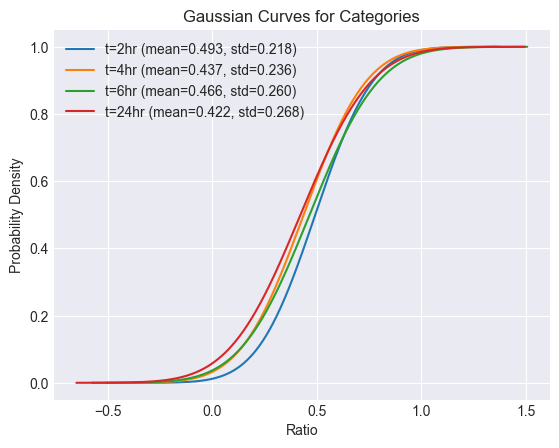

In [19]:
gaussian_curves = {"t=2hr": t2_gaussian_curve, "t=4hr": t4_gaussian_curve, "t=6hr": t6_gaussian_curve, "t=24hr": t24_gaussian_curve}
    
# Show the Gaussian curve for the analyzed categories
for category, curve_data in gaussian_curves.items():
    plt.plot(curve_data["x_values"], curve_data["y_values"], label=f'{category} (mean={curve_data["mean"]:.3f}, std={curve_data["std"]:.3f})')

plt.title("Gaussian Curves for Categories")
plt.xlabel("Ratio")
plt.ylabel("Probability Density")
plt.legend()

In [14]:
# # Example usage
# filename = 'data/csdna_v8_0.8nM_20nm_0.5nM_full_experiment02_t=6Hr_9824_T1_cropped_locs_render_picked_proper_orientation_avg_picked_avg.hdf5'
# k = 8
# flipped = False
# ratios2, categories2, gaussian_curves2 = process_multiple_origami_ratio_with_categorize_and_gaussian(filename, k, flipped, eps=0.9, min_samples=5)
                                                                                                     
